<a href="https://colab.research.google.com/github/santiagonajera/PlanificacionProduccion/blob/main/Forecast3500.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

# ===== CONFIGURATION =====
EXCEL_URL = "https://github.com/santiagonajera/PlanificacionProduccion/raw/refs/heads/main/ventas_mensuales_3500_items_2023_2025.xlsx"
SHEET_NAME = 'ITEMS'
TARGET_ITEM = 'ITEM-0001'  # Change this for different items
FORECAST_MONTHS = 10
# =========================

def load_and_prepare_data(url, sheet_name, item_name):
    """Load data from Excel and prepare time series"""
    df = pd.read_excel(url, sheet_name=sheet_name)

    # Transpose and clean the data
    item_data = df[df.iloc[:, 0] == item_name].iloc[:, 1:].T
    item_data.columns = ['sales']
    item_data = item_data.dropna()

    # Create proper datetime index
    dates = pd.date_range(start='2023-01', periods=len(item_data), freq='M')
    item_data.index = dates

    return item_data

def calculate_trend(series):
    """Calculate trend using moving average"""
    return series.rolling(window=12, min_periods=1, center=True).mean()

def calculate_seasonality(series, trend):
    """Calculate monthly seasonal factors"""
    # Get detrended series
    detrended = series / trend

    # Group by month and calculate average seasonal factors
    monthly_seasonal = detrended.groupby(detrended.index.month).mean()

    # Normalize to average 1.0
    monthly_seasonal = monthly_seasonal / monthly_seasonal.mean()

    return monthly_seasonal

def forecast_future(trend_series, seasonal_factors, periods):
    """Generate future forecast"""
    # Extend trend using linear regression on recent trend
    recent_trend = trend_series[-6:]  # Last 6 months for trend calculation
    x = np.arange(len(recent_trend))
    trend_coef = np.polyfit(x, recent_trend.values, 1)[0]

    # Generate future trend
    last_trend_value = trend_series.iloc[-1]
    future_trend = [last_trend_value + trend_coef * (i + 1) for i in range(periods)]

    # Generate future dates
    last_date = trend_series.index[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1),
                               periods=periods, freq='M')

    # Apply seasonality to trend
    future_forecast = []
    for i, date in enumerate(future_dates):
        month = date.month
        seasonal_factor = seasonal_factors[month]
        future_forecast.append(future_trend[i] * seasonal_factor)

    return pd.Series(future_forecast, index=future_dates)

def create_elegant_plot(historical, forecast, item_name):
    """Create professional visualization"""
    plt.style.use('seaborn-v0_8')
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot historical data
    ax.plot(historical.index, historical.values,
            label='Ventas Históricas', linewidth=2.5, color='#2E86AB', marker='o', markersize=4)

    # Plot forecast
    ax.plot(forecast.index, forecast.values,
            label='Pronóstico', linewidth=2.5, color='#A23B72', linestyle='--', marker='s', markersize=4)

    # Customize the plot
    ax.set_title(f'Pronóstico de Ventas - {item_name}', fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Fecha', fontsize=12, fontweight='bold')
    ax.set_ylabel('Unidades Vendidas', fontsize=12, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    # Format ticks
    plt.xticks(rotation=45)
    plt.tight_layout()

    return fig

# ===== MAIN EXECUTION =====
try:
    # Load data
    print("Cargando datos...")
    sales_data = load_and_prepare_data(EXCEL_URL, SHEET_NAME, TARGET_ITEM)

    # Calculate components
    print("Calculando tendencia y estacionalidad...")
    trend = calculate_trend(sales_data['sales'])
    seasonal_factors = calculate_seasonality(sales_data['sales'], trend)

    # Generate forecast
    print("Generando pronóstico...")
    future_forecast = forecast_future(trend, seasonal_factors, FORECAST_MONTHS)

    # Create visualization
    print("Creando gráfica...")
    fig = create_elegant_plot(sales_data['sales'], future_forecast, TARGET_ITEM)
    plt.show()

    # Print results
    print(f"\n=== FACTORES ESTACIONALES MENSUALES ===")
    months = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
             'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
    for i, month in enumerate(months, 1):
        print(f"{month}: {seasonal_factors.get(i, 1.0):.3f}")

    print(f"\n=== PRONÓSTICO PRÓXIMOS {FORECAST_MONTHS} MESES ===")
    for date, value in future_forecast.items():
        print(f"{date.strftime('%b-%Y')}: {value:.0f} unidades")

except Exception as e:
    print(f"Error: {e}")
    print("Por favor verifica la URL y los nombres de pestaña/ítem")

Cargando datos...
Error: Length mismatch: Expected axis has 0 elements, new values have 1 elements
Por favor verifica la URL y los nombres de pestaña/ítem


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para gráficas elegantes
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# URL del archivo
url = 'https://github.com/santiagonajera/PlanificacionProduccion/raw/refs/heads/main/ventas_mensuales_3500_items_2023_2025.xlsx'

# Leer el archivo Excel
print("Leyendo archivo desde GitHub...")
df = pd.read_excel(url, sheet_name='ITEMS')

# Procesar los datos
# La primera columna tiene los períodos, la segunda columna (B) tiene los valores
item_name = df.iloc[0, 1]  # Nombre del item
print(f"\nProcesando item: {item_name}")

# Extraer datos de ventas (desde la fila 2 en adelante, columna B)
data = []
dates = []

for i in range(2, len(df)):
    period = df.iloc[i, 0]
    value = df.iloc[i, 1]

    if pd.notna(period) and pd.notna(value):
        data.append(float(value))
        dates.append(str(period))

# Crear DataFrame con los datos históricos
historical_data = pd.DataFrame({
    'Periodo': dates,
    'Ventas': data
})

print(f"\nTotal de períodos históricos: {len(historical_data)}")
print(f"Rango de ventas: {min(data):.0f} - {max(data):.0f}")

# 1. CALCULAR LA TENDENCIA (usando regresión lineal)
print("\n--- CALCULANDO TENDENCIA ---")
x = np.arange(len(data))
y = np.array(data)

# Regresión lineal
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
tendencia = slope * x + intercept

print(f"Ecuación de tendencia: y = {slope:.2f}x + {intercept:.2f}")
print(f"R² = {r_value**2:.4f}")

# 2. CALCULAR LA ESTACIONALIDAD MENSUAL
print("\n--- CALCULANDO ESTACIONALIDAD ---")

# Crear un diccionario para agrupar por mes
meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
         'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

valores_por_mes = {mes: [] for mes in meses}

# Agrupar valores por mes y calcular índice estacional (valor real / tendencia)
for i, periodo in enumerate(dates):
    mes = periodo.split('-')[0].lower()
    if mes in valores_por_mes:
        indice_estacional = data[i] / tendencia[i]
        valores_por_mes[mes].append(indice_estacional)

# Calcular el índice promedio de estacionalidad para cada mes
estacionalidad = {}
for mes in meses:
    if valores_por_mes[mes]:
        estacionalidad[mes] = np.mean(valores_por_mes[mes])
    else:
        estacionalidad[mes] = 1.0

print("\nÍndices de Estacionalidad por mes:")
for mes in meses:
    print(f"{mes.upper()}: {estacionalidad[mes]:.4f}")

# 3. GENERAR FORECAST PARA LOS PRÓXIMOS 10 MESES
print("\n--- GENERANDO FORECAST ---")

# Determinar el último período
ultimo_periodo = dates[-1]
ultimo_mes, ultimo_anio = ultimo_periodo.split('-')
ultimo_anio = int('20' + ultimo_anio)

# Crear fechas para los próximos 10 meses
fecha_inicio = datetime(ultimo_anio, meses.index(ultimo_mes) + 1, 1)
fechas_forecast = []
periodos_forecast = []

for i in range(1, 11):
    nueva_fecha = fecha_inicio + relativedelta(months=i)
    mes_nombre = meses[nueva_fecha.month - 1]
    anio_corto = str(nueva_fecha.year)[2:]
    periodo = f"{mes_nombre}-{anio_corto}"
    periodos_forecast.append(periodo)
    fechas_forecast.append(nueva_fecha)

# Calcular forecast = Tendencia * Estacionalidad
forecast_values = []
for i, periodo in enumerate(periodos_forecast):
    mes = periodo.split('-')[0]
    # Índice para la tendencia (continuación de la serie)
    x_forecast = len(data) + i
    tendencia_valor = slope * x_forecast + intercept
    # Aplicar estacionalidad
    forecast = tendencia_valor * estacionalidad[mes]
    forecast_values.append(forecast)

# Crear DataFrame con forecast
df_forecast = pd.DataFrame({
    'Periodo': periodos_forecast,
    'Forecast': forecast_values
})

print("\nForecast para los próximos 10 meses:")
for i, row in df_forecast.iterrows():
    print(f"{row['Periodo']}: {row['Forecast']:.0f}")

# 4. CREAR GRÁFICA ELEGANTE
print("\n--- GENERANDO GRÁFICA ---")

fig, ax = plt.subplots(figsize=(16, 8))

# Crear eje x continuo
x_historical = np.arange(len(data))
x_forecast = np.arange(len(data), len(data) + len(forecast_values))

# Graficar datos históricos
ax.plot(x_historical, data, 'o-', linewidth=2.5, markersize=8,
        label='Ventas Reales', color='#2E86AB', alpha=0.8)

# Graficar tendencia
ax.plot(x_historical, tendencia, '--', linewidth=2,
        label='Tendencia', color='#A23B72', alpha=0.7)

# Graficar forecast
ax.plot(x_forecast, forecast_values, 's-', linewidth=2.5, markersize=8,
        label='Forecast', color='#F18F01', alpha=0.8)

# Añadir línea vertical separando histórico de forecast
ax.axvline(x=len(data)-0.5, color='gray', linestyle=':', linewidth=2, alpha=0.5)
ax.text(len(data)-0.5, ax.get_ylim()[1]*0.95, 'Inicio Forecast',
        rotation=90, verticalalignment='top', fontsize=10, color='gray')

# Configuración de la gráfica
ax.set_xlabel('Período', fontsize=14, fontweight='bold')
ax.set_ylabel('Ventas', fontsize=14, fontweight='bold')
ax.set_title(f'Forecast de Ventas - {item_name}\nMétodo: Tendencia × Estacionalidad',
             fontsize=16, fontweight='bold', pad=20)

# Configurar etiquetas del eje x
todos_periodos = dates + periodos_forecast
x_ticks = list(range(0, len(todos_periodos), max(1, len(todos_periodos)//15)))
ax.set_xticks(x_ticks)
ax.set_xticklabels([todos_periodos[i] for i in x_ticks], rotation=45, ha='right')

# Grid y leyenda
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.legend(loc='best', fontsize=12, framealpha=0.9, shadow=True)

# Añadir información adicional
textstr = f'R² = {r_value**2:.4f}\nPendiente = {slope:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

print("\n✓ Proceso completado exitosamente!")

Leyendo archivo desde GitHub...

Procesando item: 503

Total de períodos históricos: 31
Rango de ventas: 458 - 803

--- CALCULANDO TENDENCIA ---
Ecuación de tendencia: y = -1.16x + 634.23
R² = 0.0160

--- CALCULANDO ESTACIONALIDAD ---

Índices de Estacionalidad por mes:
ENE: 1.0000
FEB: 1.0000
MAR: 1.0000
ABR: 1.0000
MAY: 1.0000
JUN: 1.0000
JUL: 1.0000
AGO: 1.0000
SEP: 1.0000
OCT: 1.0000
NOV: 1.0000
DIC: 1.0000

--- GENERANDO FORECAST ---


ValueError: too many values to unpack (expected 2)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para gráficas elegantes
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# URL del archivo
url = 'https://github.com/santiagonajera/PlanificacionProduccion/raw/refs/heads/main/ventas_mensuales_3500_items_2023_2025.xlsx'

# Leer el archivo Excel
print("Leyendo archivo desde GitHub...")
df = pd.read_excel(url, sheet_name='ITEMS')

# Procesar los datos
# Buscar la fila donde dice "ITEM" en la columna A
item_row = None
for i in range(len(df)):
    if pd.notna(df.iloc[i, 0]) and str(df.iloc[i, 0]).strip().upper() == 'ITEM':
        item_row = i
        break

if item_row is None:
    print("No se encontró la fila 'ITEM'")
    exit()

# El nombre del item está en la columna B de la fila donde dice "ITEM"
item_name = df.iloc[item_row, 1]
print(f"\nProcesando item: {item_name}")

# Extraer datos de ventas (desde la fila siguiente al item)
data = []
dates = []

for i in range(item_row + 1, len(df)):
    period = df.iloc[i, 0]
    value = df.iloc[i, 1]

    if pd.notna(period) and pd.notna(value):
        # Convertir período a string y limpiar
        period_str = str(period).strip()
        # Si el período tiene formato de fecha, convertirlo a "mes-año"
        if len(period_str) > 10:  # Probablemente un datetime
            try:
                fecha = pd.to_datetime(period)
                meses_esp = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
                            'jul', 'ago', 'sep', 'oct', 'nov', 'dic']
                mes_nombre = meses_esp[fecha.month - 1]
                anio_corto = str(fecha.year)[2:]
                period_str = f"{mes_nombre}-{anio_corto}"
            except:
                pass

        data.append(float(value))
        dates.append(period_str)
    elif pd.notna(period) and str(period).strip().upper() == 'ITEM':
        # Si encontramos otro ITEM, terminamos
        break

# Crear DataFrame con los datos históricos
historical_data = pd.DataFrame({
    'Periodo': dates,
    'Ventas': data
})

# Verificar que tenemos datos suficientes
if len(data) < 12:
    print(f"\n⚠️  ADVERTENCIA: Solo se encontraron {len(data)} períodos. Se necesitan al menos 12 para calcular estacionalidad mensual.")

print(f"\nTotal de períodos históricos: {len(historical_data)}")
print(f"Rango de ventas: {min(data):.0f} - {max(data):.0f}")
print(f"\nPrimeros períodos: {dates[:5]}")
print(f"Últimos períodos: {dates[-5:]}")

# 1. CALCULAR LA TENDENCIA (usando regresión lineal)
print("\n--- CALCULANDO TENDENCIA ---")
x = np.arange(len(data))
y = np.array(data)

# Regresión lineal
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
tendencia = slope * x + intercept

print(f"Ecuación de tendencia: y = {slope:.2f}x + {intercept:.2f}")
print(f"R² = {r_value**2:.4f}")

# 2. CALCULAR LA ESTACIONALIDAD MENSUAL
print("\n--- CALCULANDO ESTACIONALIDAD ---")

# Crear un diccionario para agrupar por mes
meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
         'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

valores_por_mes = {mes: [] for mes in meses}

# Agrupar valores por mes y calcular índice estacional (valor real / tendencia)
for i, periodo in enumerate(dates):
    mes = periodo.split('-')[0].lower()
    if mes in valores_por_mes:
        indice_estacional = data[i] / tendencia[i]
        valores_por_mes[mes].append(indice_estacional)

# Calcular el índice promedio de estacionalidad para cada mes
estacionalidad = {}
for mes in meses:
    if valores_por_mes[mes]:
        estacionalidad[mes] = np.mean(valores_por_mes[mes])
    else:
        estacionalidad[mes] = 1.0

print("\nÍndices de Estacionalidad por mes:")
for mes in meses:
    print(f"{mes.upper()}: {estacionalidad[mes]:.4f}")

# 3. GENERAR FORECAST PARA LOS PRÓXIMOS 10 MESES
print("\n--- GENERANDO FORECAST ---")

# Determinar el último período
ultimo_periodo = dates[-1]
# Manejar diferentes formatos de fecha
if '-' in ultimo_periodo:
    partes = ultimo_periodo.split('-')
    if len(partes) == 2:
        ultimo_mes, ultimo_anio = partes
        # Si el año es de 2 dígitos, convertir a 4
        if len(ultimo_anio) == 2:
            ultimo_anio = int('20' + ultimo_anio)
        else:
            ultimo_anio = int(ultimo_anio)
    else:
        # Formato diferente, usar el último valor
        print(f"Formato de fecha no reconocido: {ultimo_periodo}")
        # Asumir que es el último mes de los datos
        ultimo_mes = 'dic'
        ultimo_anio = 2024
else:
    ultimo_mes = 'dic'
    ultimo_anio = 2024

# Crear fechas para los próximos 10 meses
meses_dict = {'ene': 1, 'feb': 2, 'mar': 3, 'abr': 4, 'may': 5, 'jun': 6,
              'jul': 7, 'ago': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dic': 12}

# Obtener el número del mes
if ultimo_mes.lower() in meses_dict:
    mes_num = meses_dict[ultimo_mes.lower()]
else:
    # Intentar convertir directamente si es un número
    try:
        mes_num = int(ultimo_mes)
    except:
        mes_num = 12  # Default a diciembre

fecha_inicio = datetime(ultimo_anio, mes_num, 1)
fechas_forecast = []
periodos_forecast = []

for i in range(1, 11):
    nueva_fecha = fecha_inicio + relativedelta(months=i)
    mes_nombre = meses[nueva_fecha.month - 1]
    anio_corto = str(nueva_fecha.year)[2:]
    periodo = f"{mes_nombre}-{anio_corto}"
    periodos_forecast.append(periodo)
    fechas_forecast.append(nueva_fecha)

# Calcular forecast = Tendencia * Estacionalidad
forecast_values = []
for i, periodo in enumerate(periodos_forecast):
    mes = periodo.split('-')[0].lower()
    # Índice para la tendencia (continuación de la serie)
    x_forecast = len(data) + i
    tendencia_valor = slope * x_forecast + intercept
    # Aplicar estacionalidad
    if mes in estacionalidad:
        forecast = tendencia_valor * estacionalidad[mes]
    else:
        forecast = tendencia_valor  # Sin estacionalidad si no se encuentra el mes
    forecast_values.append(forecast)

# Crear DataFrame con forecast
df_forecast = pd.DataFrame({
    'Periodo': periodos_forecast,
    'Forecast': forecast_values
})

print("\nForecast para los próximos 10 meses:")
for i, row in df_forecast.iterrows():
    print(f"{row['Periodo']}: {row['Forecast']:.0f}")

# 4. CREAR GRÁFICA ELEGANTE
print("\n--- GENERANDO GRÁFICA ---")

fig, ax = plt.subplots(figsize=(16, 8))

# Crear eje x continuo
x_historical = np.arange(len(data))
x_forecast = np.arange(len(data), len(data) + len(forecast_values))

# Graficar datos históricos
ax.plot(x_historical, data, 'o-', linewidth=2.5, markersize=8,
        label='Ventas Reales', color='#2E86AB', alpha=0.8)

# Graficar tendencia
ax.plot(x_historical, tendencia, '--', linewidth=2,
        label='Tendencia', color='#A23B72', alpha=0.7)

# Graficar forecast
ax.plot(x_forecast, forecast_values, 's-', linewidth=2.5, markersize=8,
        label='Forecast', color='#F18F01', alpha=0.8)

# Añadir línea vertical separando histórico de forecast
ax.axvline(x=len(data)-0.5, color='gray', linestyle=':', linewidth=2, alpha=0.5)
ax.text(len(data)-0.5, ax.get_ylim()[1]*0.95, 'Inicio Forecast',
        rotation=90, verticalalignment='top', fontsize=10, color='gray')

# Configuración de la gráfica
ax.set_xlabel('Período', fontsize=14, fontweight='bold')
ax.set_ylabel('Ventas', fontsize=14, fontweight='bold')
ax.set_title(f'Forecast de Ventas - {item_name}\nMétodo: Tendencia × Estacionalidad',
             fontsize=16, fontweight='bold', pad=20)

# Configurar etiquetas del eje x
todos_periodos = dates + periodos_forecast
x_ticks = list(range(0, len(todos_periodos), max(1, len(todos_periodos)//15)))
ax.set_xticks(x_ticks)
ax.set_xticklabels([todos_periodos[i] for i in x_ticks], rotation=45, ha='right')

# Grid y leyenda
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.legend(loc='best', fontsize=12, framealpha=0.9, shadow=True)

# Añadir información adicional
textstr = f'R² = {r_value**2:.4f}\nPendiente = {slope:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

print("\n✓ Proceso completado exitosamente!")

Leyendo archivo desde GitHub...
No se encontró la fila 'ITEM'


ValueError: Location based indexing can only have [integer, integer slice (START point is INCLUDED, END point is EXCLUDED), listlike of integers, boolean array] types

Leyendo archivo desde GitHub...

Procesando item: ITEM-0001

Total de períodos históricos: 33
Rango de ventas: 458 - 803
Períodos: 2023-01-01 00:00:00 hasta 2025-09-01 00:00:00

--- CALCULANDO TENDENCIA ---
Ecuación de tendencia: y = -0.16x + 614.73
R² = 0.0003

--- CALCULANDO ESTACIONALIDAD ---

Índices de Estacionalidad por mes:
ENE: 1.0000
FEB: 1.0000
MAR: 1.0000
ABR: 1.0000
MAY: 1.0000
JUN: 1.0000
JUL: 1.0000
AGO: 1.0000
SEP: 1.0000
OCT: 1.0000
NOV: 1.0000
DIC: 1.0000

--- GENERANDO FORECAST ---
Advertencia: No se pudo interpretar el último período: 2025-09-01 00:00:00

Forecast para los próximos 10 meses:
ene-25: 610
feb-25: 609
mar-25: 609
abr-25: 609
may-25: 609
jun-25: 609
jul-25: 609
ago-25: 608
sep-25: 608
oct-25: 608

--- GENERANDO GRÁFICA ---


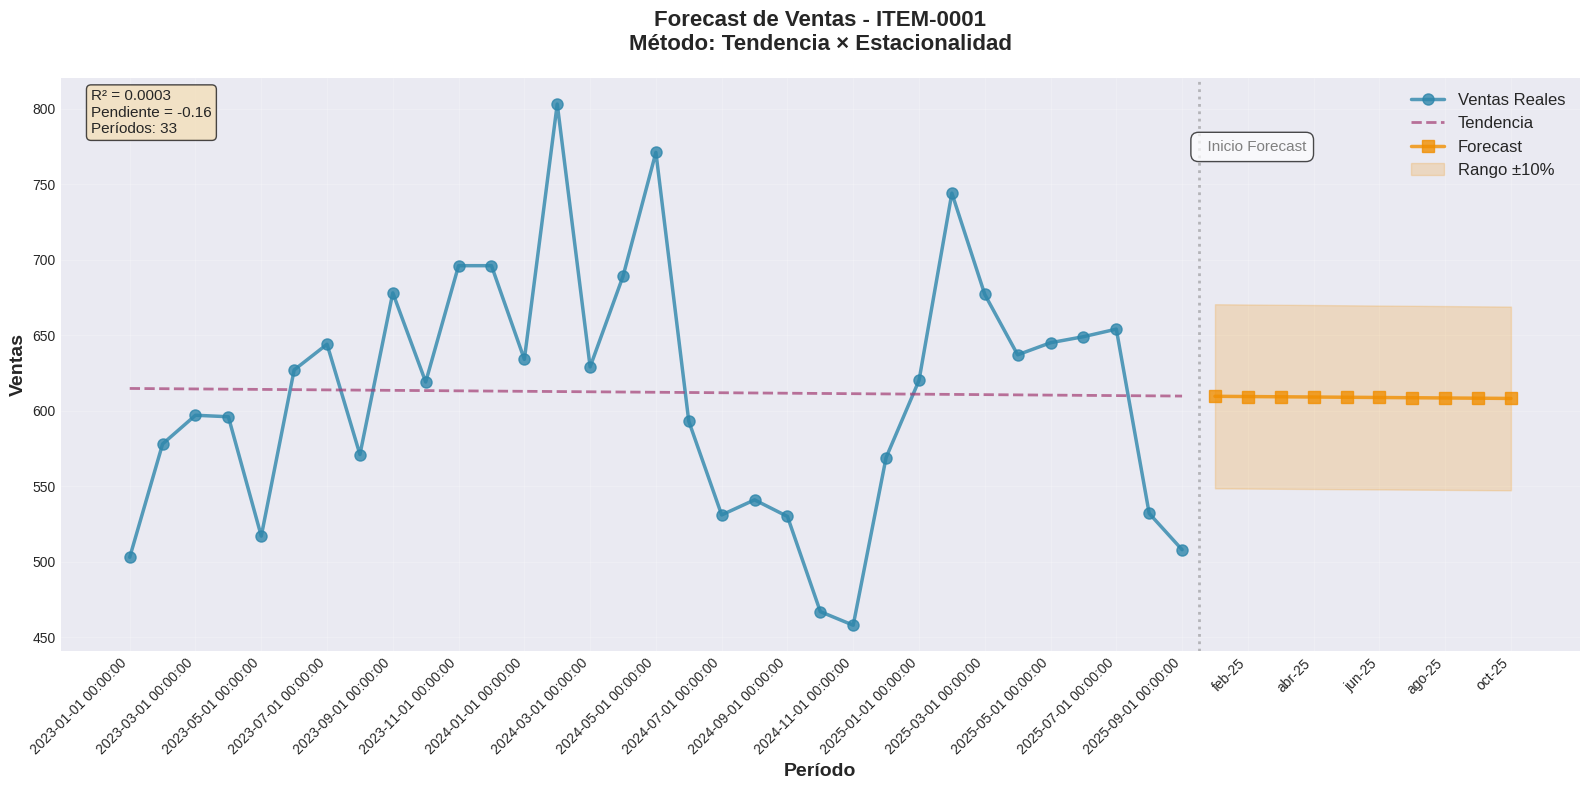


✓ Proceso completado exitosamente!

Resumen:
- Item analizado: ITEM-0001
- Períodos históricos: 33
- Tendencia: Decreciente
- R²: 0.0003
- Forecast generado: 10 meses


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para gráficas elegantes
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# URL del archivo
url = 'https://github.com/santiagonajera/PlanificacionProduccion/raw/refs/heads/main/ventas_mensuales_3500_items_2023_2025.xlsx'

# Leer el archivo Excel sin encabezados
print("Leyendo archivo desde GitHub...")
df = pd.read_excel(url, sheet_name='ITEMS', header=None)

# Buscar la columna que contiene "ITEM" en alguna fila
item_col = None
item_row = None

for col in range(df.shape[1]):
    for row in range(min(10, df.shape[0])):
        val = df.iloc[row, col]
        if pd.notna(val) and str(val).strip().upper() == 'ITEM':
            item_col = col
            item_row = row
            break
    if item_col is not None:
        break

if item_col is None:
    print("ERROR: No se encontró la columna con 'ITEM'")
    print("\nPrimeras filas del archivo:")
    print(df.head(10))
    exit()

# El nombre del item está en la siguiente columna (columna B si ITEM está en A)
item_name = df.iloc[item_row, item_col + 1]
print(f"\nProcesando item: {item_name}")

# Extraer períodos y ventas
# Los períodos están en la columna del ITEM, comenzando desde la fila siguiente
# Los valores están en la columna siguiente (donde está el nombre del item)
data = []
dates = []

for i in range(item_row + 1, df.shape[0]):
    period = df.iloc[i, item_col]
    value = df.iloc[i, item_col + 1]

    if pd.notna(period) and pd.notna(value):
        try:
            # Verificar si encontramos otro ITEM (inicio de otro producto)
            if str(period).strip().upper() == 'ITEM':
                break

            period_str = str(period).strip()
            value_num = float(value)

            dates.append(period_str)
            data.append(value_num)
        except:
            # Si hay error al convertir, probablemente terminaron los datos
            break
    else:
        # Si hay filas vacías, verificar si es fin de datos
        if len(data) > 0:
            break

if len(data) == 0:
    print("ERROR: No se encontraron datos de ventas")
    exit()

print(f"\nTotal de períodos históricos: {len(data)}")
print(f"Rango de ventas: {min(data):.0f} - {max(data):.0f}")
print(f"Períodos: {dates[0]} hasta {dates[-1]}")

# 1. CALCULAR LA TENDENCIA (usando regresión lineal)
print("\n--- CALCULANDO TENDENCIA ---")
x = np.arange(len(data))
y = np.array(data)

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
tendencia = slope * x + intercept

print(f"Ecuación de tendencia: y = {slope:.2f}x + {intercept:.2f}")
print(f"R² = {r_value**2:.4f}")

# 2. CALCULAR LA ESTACIONALIDAD MENSUAL
print("\n--- CALCULANDO ESTACIONALIDAD ---")

meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
         'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

valores_por_mes = {mes: [] for mes in meses}

# Agrupar valores por mes y calcular índice estacional
for i, periodo in enumerate(dates):
    # Extraer el mes del período (formato: mes-año, ej: "ene-23")
    try:
        mes_parte = periodo.split('-')[0].lower()
        if mes_parte in valores_por_mes:
            # Índice estacional = valor real / valor de tendencia
            indice_estacional = data[i] / tendencia[i] if tendencia[i] != 0 else 1.0
            valores_por_mes[mes_parte].append(indice_estacional)
    except:
        continue

# Calcular el índice promedio de estacionalidad para cada mes
estacionalidad = {}
for mes in meses:
    if valores_por_mes[mes]:
        estacionalidad[mes] = np.mean(valores_por_mes[mes])
    else:
        estacionalidad[mes] = 1.0

print("\nÍndices de Estacionalidad por mes:")
for mes in meses:
    print(f"{mes.upper()}: {estacionalidad[mes]:.4f}")

# 3. GENERAR FORECAST PARA LOS PRÓXIMOS 10 MESES
print("\n--- GENERANDO FORECAST ---")

# Determinar el último período
ultimo_periodo = dates[-1]
try:
    ultimo_mes_str, ultimo_anio_str = ultimo_periodo.split('-')
    ultimo_mes_str = ultimo_mes_str.lower()

    # Convertir año a 4 dígitos
    if len(ultimo_anio_str) == 2:
        ultimo_anio = int('20' + ultimo_anio_str)
    else:
        ultimo_anio = int(ultimo_anio_str)

    # Obtener número del mes
    if ultimo_mes_str in meses:
        ultimo_mes_num = meses.index(ultimo_mes_str) + 1
    else:
        ultimo_mes_num = 12

except:
    print(f"Advertencia: No se pudo interpretar el último período: {ultimo_periodo}")
    ultimo_anio = 2024
    ultimo_mes_num = 12

# Crear fechas para los próximos 10 meses
fecha_inicio = datetime(ultimo_anio, ultimo_mes_num, 1)
periodos_forecast = []

for i in range(1, 11):
    nueva_fecha = fecha_inicio + relativedelta(months=i)
    mes_nombre = meses[nueva_fecha.month - 1]
    anio_corto = str(nueva_fecha.year)[2:]
    periodo = f"{mes_nombre}-{anio_corto}"
    periodos_forecast.append(periodo)

# Calcular forecast = Tendencia * Estacionalidad
forecast_values = []
for i, periodo in enumerate(periodos_forecast):
    mes = periodo.split('-')[0].lower()
    # Índice para la tendencia (continuación de la serie)
    x_forecast = len(data) + i
    tendencia_valor = slope * x_forecast + intercept
    # Aplicar estacionalidad
    forecast = tendencia_valor * estacionalidad.get(mes, 1.0)
    forecast_values.append(forecast)

# Crear DataFrame con forecast
df_forecast = pd.DataFrame({
    'Periodo': periodos_forecast,
    'Forecast': forecast_values
})

print("\nForecast para los próximos 10 meses:")
for i, row in df_forecast.iterrows():
    print(f"{row['Periodo']}: {row['Forecast']:.0f}")

# 4. CREAR GRÁFICA ELEGANTE
print("\n--- GENERANDO GRÁFICA ---")

fig, ax = plt.subplots(figsize=(16, 8))

# Crear eje x continuo
x_historical = np.arange(len(data))
x_forecast = np.arange(len(data), len(data) + len(forecast_values))

# Graficar datos históricos
ax.plot(x_historical, data, 'o-', linewidth=2.5, markersize=8,
        label='Ventas Reales', color='#2E86AB', alpha=0.8)

# Graficar tendencia
ax.plot(x_historical, tendencia, '--', linewidth=2,
        label='Tendencia', color='#A23B72', alpha=0.7)

# Graficar forecast
ax.plot(x_forecast, forecast_values, 's-', linewidth=2.5, markersize=8,
        label='Forecast', color='#F18F01', alpha=0.8)

# Área sombreada para el forecast (intervalo de confianza visual)
ax.fill_between(x_forecast,
                np.array(forecast_values) * 0.9,
                np.array(forecast_values) * 1.1,
                alpha=0.2, color='#F18F01', label='Rango ±10%')

# Añadir línea vertical separando histórico de forecast
ax.axvline(x=len(data)-0.5, color='gray', linestyle=':', linewidth=2, alpha=0.5)
ax.text(len(data)-0.5, ax.get_ylim()[1]*0.95, '  Inicio Forecast',
        rotation=0, verticalalignment='top', fontsize=11, color='gray',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7))

# Configuración de la gráfica
ax.set_xlabel('Período', fontsize=14, fontweight='bold')
ax.set_ylabel('Ventas', fontsize=14, fontweight='bold')
ax.set_title(f'Forecast de Ventas - {item_name}\nMétodo: Tendencia × Estacionalidad',
             fontsize=16, fontweight='bold', pad=20)

# Configurar etiquetas del eje x
todos_periodos = dates + periodos_forecast
x_ticks = list(range(0, len(todos_periodos), max(1, len(todos_periodos)//15)))
ax.set_xticks(x_ticks)
ax.set_xticklabels([todos_periodos[i] for i in x_ticks], rotation=45, ha='right')

# Grid y leyenda
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.legend(loc='best', fontsize=12, framealpha=0.9, shadow=True)

# Añadir información adicional
textstr = f'R² = {r_value**2:.4f}\nPendiente = {slope:.2f}\nPeríodos: {len(data)}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

print("\n✓ Proceso completado exitosamente!")
print(f"\nResumen:")
print(f"- Item analizado: {item_name}")
print(f"- Períodos históricos: {len(data)}")
print(f"- Tendencia: {'Creciente' if slope > 0 else 'Decreciente'}")
print(f"- R²: {r_value**2:.4f}")
print(f"- Forecast generado: {len(forecast_values)} meses")

Leyendo archivo desde GitHub...

Procesando item: ITEM-0001

Total de períodos históricos: 33
Rango de ventas: 458 - 803
Períodos: 2023-01-01 00:00:00 hasta 2025-09-01 00:00:00

--- CALCULANDO TENDENCIA ---
Ecuación de tendencia: y = -0.16x + 614.73
R² = 0.0003

--- CALCULANDO ESTACIONALIDAD ---

Promedios anuales:

Índices de Estacionalidad por mes:
ENE: 1.0000 (basado en 0 observaciones)
FEB: 1.0000 (basado en 0 observaciones)
MAR: 1.0000 (basado en 0 observaciones)
ABR: 1.0000 (basado en 0 observaciones)
MAY: 1.0000 (basado en 0 observaciones)
JUN: 1.0000 (basado en 0 observaciones)
JUL: 1.0000 (basado en 0 observaciones)
AGO: 1.0000 (basado en 0 observaciones)
SEP: 1.0000 (basado en 0 observaciones)
OCT: 1.0000 (basado en 0 observaciones)
NOV: 1.0000 (basado en 0 observaciones)
DIC: 1.0000 (basado en 0 observaciones)

--- GENERANDO FORECAST ---
Advertencia: No se pudo interpretar el último período: 2025-09-01 00:00:00

Forecast para los próximos 10 meses:
ene-25: 610
feb-25: 609
ma

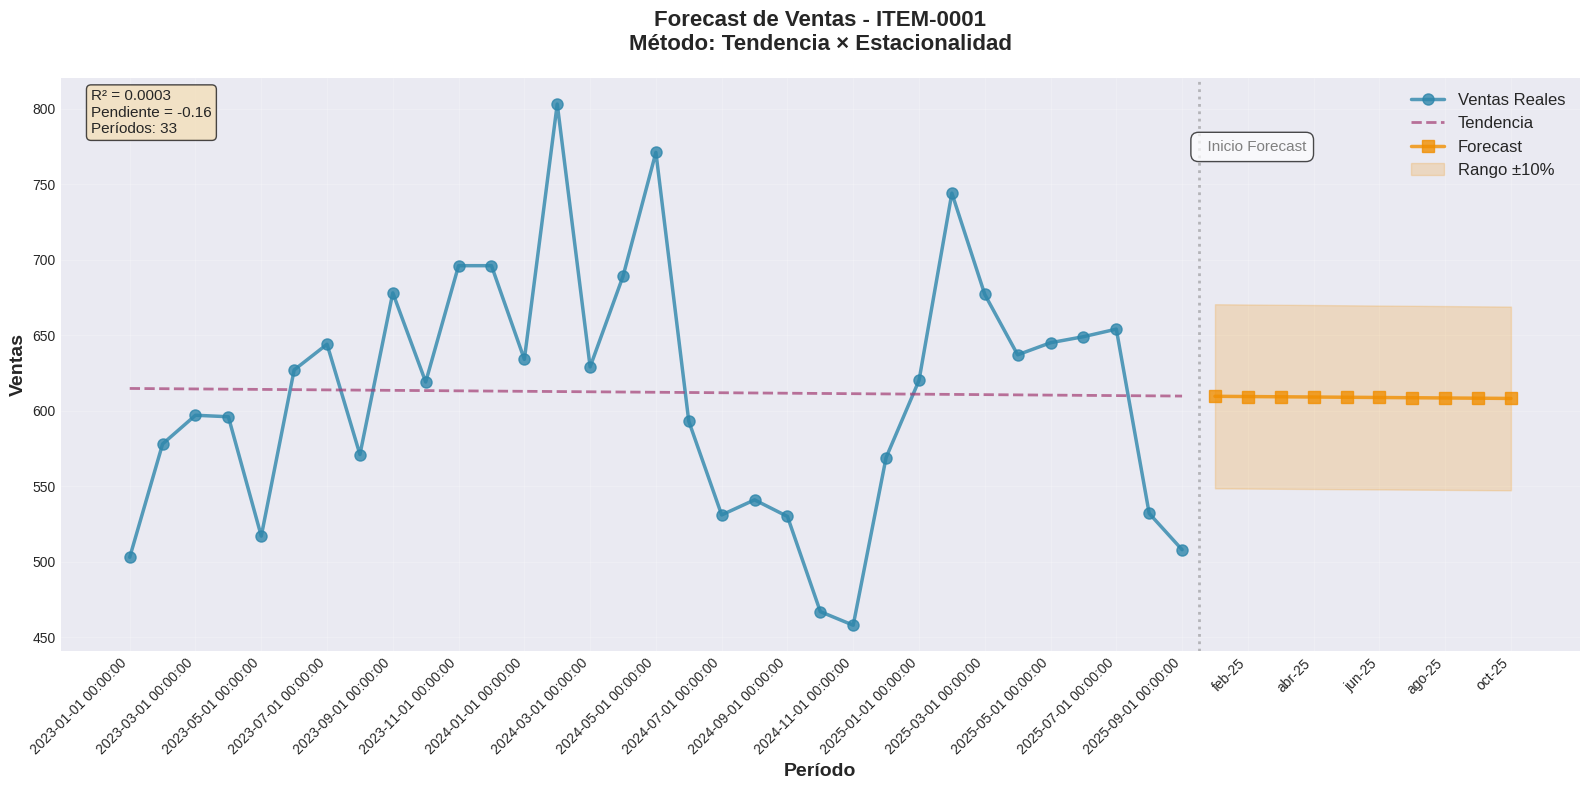


✓ Proceso completado exitosamente!

Resumen:
- Item analizado: ITEM-0001
- Períodos históricos: 33
- Tendencia: Decreciente
- R²: 0.0003
- Forecast generado: 10 meses


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para gráficas elegantes
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# URL del archivo
url = 'https://github.com/santiagonajera/PlanificacionProduccion/raw/refs/heads/main/ventas_mensuales_3500_items_2023_2025.xlsx'

# Leer el archivo Excel sin encabezados
print("Leyendo archivo desde GitHub...")
df = pd.read_excel(url, sheet_name='ITEMS', header=None)

# Buscar la columna que contiene "ITEM" en alguna fila
item_col = None
item_row = None

for col in range(df.shape[1]):
    for row in range(min(10, df.shape[0])):
        val = df.iloc[row, col]
        if pd.notna(val) and str(val).strip().upper() == 'ITEM':
            item_col = col
            item_row = row
            break
    if item_col is not None:
        break

if item_col is None:
    print("ERROR: No se encontró la columna con 'ITEM'")
    print("\nPrimeras filas del archivo:")
    print(df.head(10))
    exit()

# El nombre del item está en la siguiente columna (columna B si ITEM está en A)
item_name = df.iloc[item_row, item_col + 1]
print(f"\nProcesando item: {item_name}")

# Extraer períodos y ventas
# Los períodos están en la columna del ITEM, comenzando desde la fila siguiente
# Los valores están en la columna siguiente (donde está el nombre del item)
data = []
dates = []

for i in range(item_row + 1, df.shape[0]):
    period = df.iloc[i, item_col]
    value = df.iloc[i, item_col + 1]

    if pd.notna(period) and pd.notna(value):
        try:
            # Verificar si encontramos otro ITEM (inicio de otro producto)
            if str(period).strip().upper() == 'ITEM':
                break

            period_str = str(period).strip()
            value_num = float(value)

            dates.append(period_str)
            data.append(value_num)
        except:
            # Si hay error al convertir, probablemente terminaron los datos
            break
    else:
        # Si hay filas vacías, verificar si es fin de datos
        if len(data) > 0:
            break

if len(data) == 0:
    print("ERROR: No se encontraron datos de ventas")
    exit()

print(f"\nTotal de períodos históricos: {len(data)}")
print(f"Rango de ventas: {min(data):.0f} - {max(data):.0f}")
print(f"Períodos: {dates[0]} hasta {dates[-1]}")

# 1. CALCULAR LA TENDENCIA (usando regresión lineal)
print("\n--- CALCULANDO TENDENCIA ---")
x = np.arange(len(data))
y = np.array(data)

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
tendencia = slope * x + intercept

print(f"Ecuación de tendencia: y = {slope:.2f}x + {intercept:.2f}")
print(f"R² = {r_value**2:.4f}")

# 2. CALCULAR LA ESTACIONALIDAD MENSUAL
print("\n--- CALCULANDO ESTACIONALIDAD ---")

meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
         'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

# Primero, agrupar los datos por año y calcular el promedio de cada año
datos_por_anio = {}

for i, periodo in enumerate(dates):
    try:
        mes_parte, anio_parte = periodo.split('-')
        mes_parte = mes_parte.lower()

        # Convertir año a formato completo
        if len(anio_parte) == 2:
            anio_completo = '20' + anio_parte
        else:
            anio_completo = anio_parte

        # Agrupar por año
        if anio_completo not in datos_por_anio:
            datos_por_anio[anio_completo] = []
        datos_por_anio[anio_completo].append(data[i])
    except:
        continue

# Calcular el promedio de cada año
promedio_por_anio = {}
print("\nPromedios anuales:")
for anio in sorted(datos_por_anio.keys()):
    promedio_por_anio[anio] = np.mean(datos_por_anio[anio])
    print(f"Año {anio}: {promedio_por_anio[anio]:.2f} (basado en {len(datos_por_anio[anio])} meses)")

# Calcular índice estacional: demanda del mes / promedio del año
valores_por_mes = {mes: [] for mes in meses}

for i, periodo in enumerate(dates):
    try:
        mes_parte, anio_parte = periodo.split('-')
        mes_parte = mes_parte.lower()

        # Convertir año a formato completo
        if len(anio_parte) == 2:
            anio_completo = '20' + anio_parte
        else:
            anio_completo = anio_parte

        if mes_parte in valores_por_mes and anio_completo in promedio_por_anio:
            # ÍNDICE ESTACIONAL = demanda del mes / promedio anual
            indice_estacional = data[i] / promedio_por_anio[anio_completo]
            valores_por_mes[mes_parte].append(indice_estacional)
    except:
        continue

# Calcular el índice promedio de estacionalidad para cada mes
estacionalidad = {}
for mes in meses:
    if valores_por_mes[mes]:
        estacionalidad[mes] = np.mean(valores_por_mes[mes])
    else:
        estacionalidad[mes] = 1.0

print("\nÍndices de Estacionalidad por mes:")
for mes in meses:
    observaciones = len(valores_por_mes[mes])
    print(f"{mes.upper()}: {estacionalidad[mes]:.4f} (basado en {observaciones} observaciones)")

# 3. GENERAR FORECAST PARA LOS PRÓXIMOS 10 MESES
print("\n--- GENERANDO FORECAST ---")

# Determinar el último período
ultimo_periodo = dates[-1]
try:
    ultimo_mes_str, ultimo_anio_str = ultimo_periodo.split('-')
    ultimo_mes_str = ultimo_mes_str.lower()

    # Convertir año a 4 dígitos
    if len(ultimo_anio_str) == 2:
        ultimo_anio = int('20' + ultimo_anio_str)
    else:
        ultimo_anio = int(ultimo_anio_str)

    # Obtener número del mes
    if ultimo_mes_str in meses:
        ultimo_mes_num = meses.index(ultimo_mes_str) + 1
    else:
        ultimo_mes_num = 12

except:
    print(f"Advertencia: No se pudo interpretar el último período: {ultimo_periodo}")
    ultimo_anio = 2024
    ultimo_mes_num = 12

# Crear fechas para los próximos 10 meses
fecha_inicio = datetime(ultimo_anio, ultimo_mes_num, 1)
periodos_forecast = []

for i in range(1, 11):
    nueva_fecha = fecha_inicio + relativedelta(months=i)
    mes_nombre = meses[nueva_fecha.month - 1]
    anio_corto = str(nueva_fecha.year)[2:]
    periodo = f"{mes_nombre}-{anio_corto}"
    periodos_forecast.append(periodo)

# Calcular forecast = Tendencia * Estacionalidad
forecast_values = []
for i, periodo in enumerate(periodos_forecast):
    mes = periodo.split('-')[0].lower()
    # Índice para la tendencia (continuación de la serie)
    x_forecast = len(data) + i
    tendencia_valor = slope * x_forecast + intercept
    # Aplicar estacionalidad
    forecast = tendencia_valor * estacionalidad.get(mes, 1.0)
    forecast_values.append(forecast)

# Crear DataFrame con forecast
df_forecast = pd.DataFrame({
    'Periodo': periodos_forecast,
    'Forecast': forecast_values
})

print("\nForecast para los próximos 10 meses:")
for i, row in df_forecast.iterrows():
    print(f"{row['Periodo']}: {row['Forecast']:.0f}")

# 4. CREAR GRÁFICA ELEGANTE
print("\n--- GENERANDO GRÁFICA ---")

fig, ax = plt.subplots(figsize=(16, 8))

# Crear eje x continuo
x_historical = np.arange(len(data))
x_forecast = np.arange(len(data), len(data) + len(forecast_values))

# Graficar datos históricos
ax.plot(x_historical, data, 'o-', linewidth=2.5, markersize=8,
        label='Ventas Reales', color='#2E86AB', alpha=0.8)

# Graficar tendencia
ax.plot(x_historical, tendencia, '--', linewidth=2,
        label='Tendencia', color='#A23B72', alpha=0.7)

# Graficar forecast
ax.plot(x_forecast, forecast_values, 's-', linewidth=2.5, markersize=8,
        label='Forecast', color='#F18F01', alpha=0.8)

# Área sombreada para el forecast (intervalo de confianza visual)
ax.fill_between(x_forecast,
                np.array(forecast_values) * 0.9,
                np.array(forecast_values) * 1.1,
                alpha=0.2, color='#F18F01', label='Rango ±10%')

# Añadir línea vertical separando histórico de forecast
ax.axvline(x=len(data)-0.5, color='gray', linestyle=':', linewidth=2, alpha=0.5)
ax.text(len(data)-0.5, ax.get_ylim()[1]*0.95, '  Inicio Forecast',
        rotation=0, verticalalignment='top', fontsize=11, color='gray',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7))

# Configuración de la gráfica
ax.set_xlabel('Período', fontsize=14, fontweight='bold')
ax.set_ylabel('Ventas', fontsize=14, fontweight='bold')
ax.set_title(f'Forecast de Ventas - {item_name}\nMétodo: Tendencia × Estacionalidad',
             fontsize=16, fontweight='bold', pad=20)

# Configurar etiquetas del eje x
todos_periodos = dates + periodos_forecast
x_ticks = list(range(0, len(todos_periodos), max(1, len(todos_periodos)//15)))
ax.set_xticks(x_ticks)
ax.set_xticklabels([todos_periodos[i] for i in x_ticks], rotation=45, ha='right')

# Grid y leyenda
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.legend(loc='best', fontsize=12, framealpha=0.9, shadow=True)

# Añadir información adicional
textstr = f'R² = {r_value**2:.4f}\nPendiente = {slope:.2f}\nPeríodos: {len(data)}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

print("\n✓ Proceso completado exitosamente!")
print(f"\nResumen:")
print(f"- Item analizado: {item_name}")
print(f"- Períodos históricos: {len(data)}")
print(f"- Tendencia: {'Creciente' if slope > 0 else 'Decreciente'}")
print(f"- R²: {r_value**2:.4f}")
print(f"- Forecast generado: {len(forecast_values)} meses")

Leyendo archivo desde GitHub...

Procesando item: ITEM-0001

Total de períodos históricos: 33
Rango de ventas: 458 - 803
Períodos: 2023-01-01 00:00:00 hasta 2025-09-01 00:00:00

--- CALCULANDO TENDENCIA ---
Ecuación de tendencia: y = -0.16x + 614.73
R² = 0.0003

--- CALCULANDO ESTACIONALIDAD ---

Muestra de períodos detectados:
  2023-01-01 00:00:00 -> Mes: ene, Año: 2023
  2023-02-01 00:00:00 -> Mes: feb, Año: 2023
  2023-03-01 00:00:00 -> Mes: mar, Año: 2023
  2023-04-01 00:00:00 -> Mes: abr, Año: 2023
  2023-05-01 00:00:00 -> Mes: may, Año: 2023

Promedios anuales:
Año 2023: 610.17 (basado en 12 meses)
Año 2024: 601.25 (basado en 12 meses)
Año 2025: 629.56 (basado en 9 meses)

Detalle del cálculo de estacionalidad:
  2023-01-01 00:00:00: 503 / 610.17 = 0.8244 (82%)
  2023-02-01 00:00:00: 578 / 610.17 = 0.9473 (95%)
  2023-03-01 00:00:00: 597 / 610.17 = 0.9784 (98%)

Índices de Estacionalidad por mes:
ENE: 0.9546 (95%) - basado en 3 observaciones
FEB: 1.1549 (115%) - basado en 3 obse

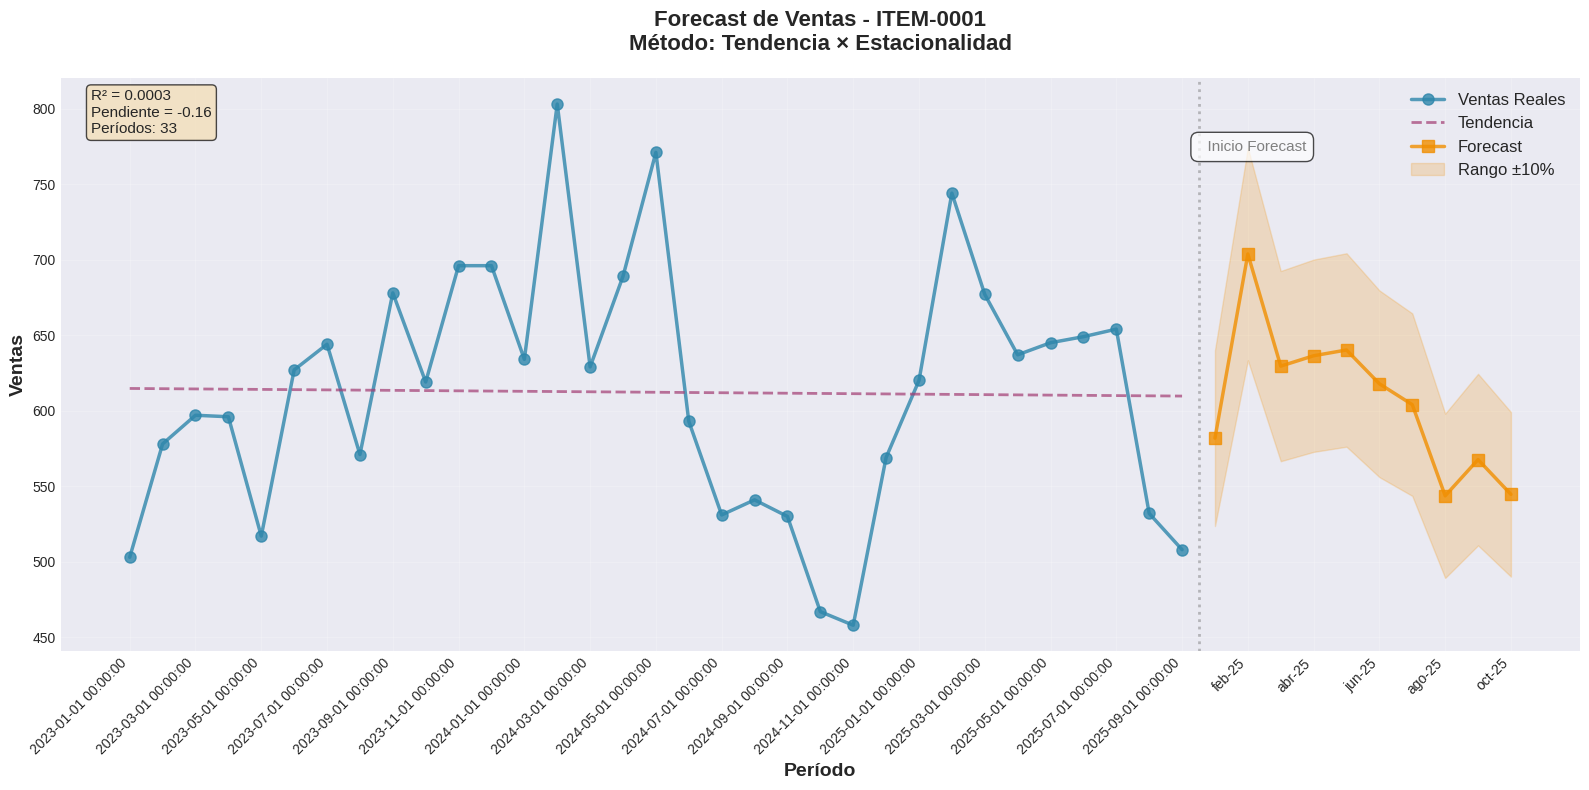


✓ Proceso completado exitosamente!

Resumen:
- Item analizado: ITEM-0001
- Períodos históricos: 33
- Tendencia: Decreciente
- R²: 0.0003
- Forecast generado: 10 meses


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para gráficas elegantes
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# URL del archivo
url = 'https://github.com/santiagonajera/PlanificacionProduccion/raw/refs/heads/main/ventas_mensuales_3500_items_2023_2025.xlsx'

# Leer el archivo Excel sin encabezados
print("Leyendo archivo desde GitHub...")
df = pd.read_excel(url, sheet_name='ITEMS', header=None)

# Buscar la columna que contiene "ITEM" en alguna fila
item_col = None
item_row = None

for col in range(df.shape[1]):
    for row in range(min(10, df.shape[0])):
        val = df.iloc[row, col]
        if pd.notna(val) and str(val).strip().upper() == 'ITEM':
            item_col = col
            item_row = row
            break
    if item_col is not None:
        break

if item_col is None:
    print("ERROR: No se encontró la columna con 'ITEM'")
    print("\nPrimeras filas del archivo:")
    print(df.head(10))
    exit()

# El nombre del item está en la siguiente columna (columna B si ITEM está en A)
item_name = df.iloc[item_row, item_col + 1]
print(f"\nProcesando item: {item_name}")

# Extraer períodos y ventas
# Los períodos están en la columna del ITEM, comenzando desde la fila siguiente
# Los valores están en la columna siguiente (donde está el nombre del item)
data = []
dates = []

for i in range(item_row + 1, df.shape[0]):
    period = df.iloc[i, item_col]
    value = df.iloc[i, item_col + 1]

    if pd.notna(period) and pd.notna(value):
        try:
            # Verificar si encontramos otro ITEM (inicio de otro producto)
            if str(period).strip().upper() == 'ITEM':
                break

            period_str = str(period).strip()
            value_num = float(value)

            dates.append(period_str)
            data.append(value_num)
        except:
            # Si hay error al convertir, probablemente terminaron los datos
            break
    else:
        # Si hay filas vacías, verificar si es fin de datos
        if len(data) > 0:
            break

if len(data) == 0:
    print("ERROR: No se encontraron datos de ventas")
    exit()

print(f"\nTotal de períodos históricos: {len(data)}")
print(f"Rango de ventas: {min(data):.0f} - {max(data):.0f}")
print(f"Períodos: {dates[0]} hasta {dates[-1]}")

# 1. CALCULAR LA TENDENCIA (usando regresión lineal)
print("\n--- CALCULANDO TENDENCIA ---")
x = np.arange(len(data))
y = np.array(data)

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
tendencia = slope * x + intercept

print(f"Ecuación de tendencia: y = {slope:.2f}x + {intercept:.2f}")
print(f"R² = {r_value**2:.4f}")

# 2. CALCULAR LA ESTACIONALIDAD MENSUAL
print("\n--- CALCULANDO ESTACIONALIDAD ---")

meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
         'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

# Función para extraer mes y año del período
def extraer_mes_anio(periodo_str):
    """Extrae el mes y año de diferentes formatos de período"""
    periodo_str = str(periodo_str).strip().lower()

    # Intentar formato "mes-año" (ej: "ene-23", "enero-2023")
    if '-' in periodo_str:
        partes = periodo_str.split('-')
        mes_str = partes[0].strip()
        anio_str = partes[1].strip()

        # Buscar el mes en la lista
        for mes_idx, mes_nombre in enumerate(meses):
            if mes_str.startswith(mes_nombre[:3]):
                # Convertir año a formato completo
                if len(anio_str) == 2:
                    anio = '20' + anio_str
                else:
                    anio = anio_str
                return mes_nombre, anio

    # Si es un objeto datetime de pandas
    try:
        fecha = pd.to_datetime(periodo_str)
        mes_nombre = meses[fecha.month - 1]
        anio = str(fecha.year)
        return mes_nombre, anio
    except:
        pass

    return None, None

print("\nMuestra de períodos detectados:")
for i in range(min(5, len(dates))):
    mes, anio = extraer_mes_anio(dates[i])
    print(f"  {dates[i]} -> Mes: {mes}, Año: {anio}")

# Primero, agrupar los datos por año y calcular el promedio de cada año
datos_por_anio = {}

for i, periodo in enumerate(dates):
    mes, anio = extraer_mes_anio(periodo)
    if mes and anio:
        # Agrupar por año
        if anio not in datos_por_anio:
            datos_por_anio[anio] = []
        datos_por_anio[anio].append(data[i])

# Calcular el promedio de cada año
promedio_por_anio = {}
print("\nPromedios anuales:")
for anio in sorted(datos_por_anio.keys()):
    promedio_por_anio[anio] = np.mean(datos_por_anio[anio])
    print(f"Año {anio}: {promedio_por_anio[anio]:.2f} (basado en {len(datos_por_anio[anio])} meses)")

# Calcular índice estacional: demanda del mes / promedio del año
valores_por_mes = {mes: [] for mes in meses}

print("\nDetalle del cálculo de estacionalidad:")
for i, periodo in enumerate(dates):
    mes, anio = extraer_mes_anio(periodo)
    if mes and anio and anio in promedio_por_anio:
        # ÍNDICE ESTACIONAL = demanda del mes / promedio anual
        indice_estacional = data[i] / promedio_por_anio[anio]
        valores_por_mes[mes].append(indice_estacional)

        # Mostrar primeros 3 ejemplos
        if i < 3:
            print(f"  {periodo}: {data[i]:.0f} / {promedio_por_anio[anio]:.2f} = {indice_estacional:.4f} ({indice_estacional*100:.0f}%)")

# Calcular el índice promedio de estacionalidad para cada mes
estacionalidad = {}
for mes in meses:
    if valores_por_mes[mes]:
        estacionalidad[mes] = np.mean(valores_por_mes[mes])
    else:
        estacionalidad[mes] = 1.0

print("\nÍndices de Estacionalidad por mes:")
for mes in meses:
    observaciones = len(valores_por_mes[mes])
    if observaciones > 0:
        print(f"{mes.upper()}: {estacionalidad[mes]:.4f} ({estacionalidad[mes]*100:.0f}%) - basado en {observaciones} observaciones")
    else:
        print(f"{mes.upper()}: {estacionalidad[mes]:.4f} (sin datos)")

# 3. GENERAR FORECAST PARA LOS PRÓXIMOS 10 MESES
print("\n--- GENERANDO FORECAST ---")

# Determinar el último período
ultimo_periodo = dates[-1]
try:
    ultimo_mes_str, ultimo_anio_str = ultimo_periodo.split('-')
    ultimo_mes_str = ultimo_mes_str.lower()

    # Convertir año a 4 dígitos
    if len(ultimo_anio_str) == 2:
        ultimo_anio = int('20' + ultimo_anio_str)
    else:
        ultimo_anio = int(ultimo_anio_str)

    # Obtener número del mes
    if ultimo_mes_str in meses:
        ultimo_mes_num = meses.index(ultimo_mes_str) + 1
    else:
        ultimo_mes_num = 12

except:
    print(f"Advertencia: No se pudo interpretar el último período: {ultimo_periodo}")
    ultimo_anio = 2024
    ultimo_mes_num = 12

# Crear fechas para los próximos 10 meses
fecha_inicio = datetime(ultimo_anio, ultimo_mes_num, 1)
periodos_forecast = []

for i in range(1, 11):
    nueva_fecha = fecha_inicio + relativedelta(months=i)
    mes_nombre = meses[nueva_fecha.month - 1]
    anio_corto = str(nueva_fecha.year)[2:]
    periodo = f"{mes_nombre}-{anio_corto}"
    periodos_forecast.append(periodo)

# Calcular forecast = Tendencia * Estacionalidad
forecast_values = []
for i, periodo in enumerate(periodos_forecast):
    mes = periodo.split('-')[0].lower()
    # Índice para la tendencia (continuación de la serie)
    x_forecast = len(data) + i
    tendencia_valor = slope * x_forecast + intercept
    # Aplicar estacionalidad
    forecast = tendencia_valor * estacionalidad.get(mes, 1.0)
    forecast_values.append(forecast)

# Crear DataFrame con forecast
df_forecast = pd.DataFrame({
    'Periodo': periodos_forecast,
    'Forecast': forecast_values
})

print("\nForecast para los próximos 10 meses:")
for i, row in df_forecast.iterrows():
    print(f"{row['Periodo']}: {row['Forecast']:.0f}")

# 4. CREAR GRÁFICA ELEGANTE
print("\n--- GENERANDO GRÁFICA ---")

fig, ax = plt.subplots(figsize=(16, 8))

# Crear eje x continuo
x_historical = np.arange(len(data))
x_forecast = np.arange(len(data), len(data) + len(forecast_values))

# Graficar datos históricos
ax.plot(x_historical, data, 'o-', linewidth=2.5, markersize=8,
        label='Ventas Reales', color='#2E86AB', alpha=0.8)

# Graficar tendencia
ax.plot(x_historical, tendencia, '--', linewidth=2,
        label='Tendencia', color='#A23B72', alpha=0.7)

# Graficar forecast
ax.plot(x_forecast, forecast_values, 's-', linewidth=2.5, markersize=8,
        label='Forecast', color='#F18F01', alpha=0.8)

# Área sombreada para el forecast (intervalo de confianza visual)
ax.fill_between(x_forecast,
                np.array(forecast_values) * 0.9,
                np.array(forecast_values) * 1.1,
                alpha=0.2, color='#F18F01', label='Rango ±10%')

# Añadir línea vertical separando histórico de forecast
ax.axvline(x=len(data)-0.5, color='gray', linestyle=':', linewidth=2, alpha=0.5)
ax.text(len(data)-0.5, ax.get_ylim()[1]*0.95, '  Inicio Forecast',
        rotation=0, verticalalignment='top', fontsize=11, color='gray',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7))

# Configuración de la gráfica
ax.set_xlabel('Período', fontsize=14, fontweight='bold')
ax.set_ylabel('Ventas', fontsize=14, fontweight='bold')
ax.set_title(f'Forecast de Ventas - {item_name}\nMétodo: Tendencia × Estacionalidad',
             fontsize=16, fontweight='bold', pad=20)

# Configurar etiquetas del eje x
todos_periodos = dates + periodos_forecast
x_ticks = list(range(0, len(todos_periodos), max(1, len(todos_periodos)//15)))
ax.set_xticks(x_ticks)
ax.set_xticklabels([todos_periodos[i] for i in x_ticks], rotation=45, ha='right')

# Grid y leyenda
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.legend(loc='best', fontsize=12, framealpha=0.9, shadow=True)

# Añadir información adicional
textstr = f'R² = {r_value**2:.4f}\nPendiente = {slope:.2f}\nPeríodos: {len(data)}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

print("\n✓ Proceso completado exitosamente!")
print(f"\nResumen:")
print(f"- Item analizado: {item_name}")
print(f"- Períodos históricos: {len(data)}")
print(f"- Tendencia: {'Creciente' if slope > 0 else 'Decreciente'}")
print(f"- R²: {r_value**2:.4f}")
print(f"- Forecast generado: {len(forecast_values)} meses")

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para gráficas elegantes
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# URL del archivo
url = 'https://github.com/santiagonajera/PlanificacionProduccion/raw/refs/heads/main/ventas_mensuales_3500_items_2023_2025.xlsx'

# ==========================================
# CONFIGURACIÓN: Selecciona la columna del item a analizar
# ==========================================
# Opciones: 'A', 'B', 'C', ..., 'X', 'Y', 'Z', etc.
COLUMNA_ITEM = 'X'  # <-- CAMBIA ESTA LETRA PARA ANALIZAR OTRO ITEM
# ==========================================

# Convertir letra de columna a índice numérico (A=0, B=1, X=23, etc.)
def columna_a_indice(letra):
    """Convierte letra de columna a índice (A=0, B=1, etc.)"""
    letra = letra.upper()
    indice = 0
    for i, char in enumerate(reversed(letra)):
        indice += (ord(char) - ord('A') + 1) * (26 ** i)
    return indice - 1

item_col = columna_a_indice(COLUMNA_ITEM)

# Leer el archivo Excel sin encabezados
print(f"Leyendo archivo desde GitHub...")
print(f"Analizando item en columna: {COLUMNA_ITEM} (índice {item_col})")
df = pd.read_excel(url, sheet_name='ITEMS', header=None)

# Buscar la fila que contiene "ITEM" en la columna seleccionada
item_row = None

for row in range(min(10, df.shape[0])):
    val = df.iloc[row, item_col]
    if pd.notna(val) and str(val).strip().upper() == 'ITEM':
        item_row = row
        break

if item_row is None:
    print(f"ERROR: No se encontró 'ITEM' en la columna {COLUMNA_ITEM}")
    print(f"\nPrimeras filas de la columna {COLUMNA_ITEM}:")
    print(df.iloc[:10, item_col])
    exit()

# El nombre del item está en la siguiente columna (columna B si ITEM está en A)
item_name = df.iloc[item_row, item_col + 1]
print(f"\nProcesando item: {item_name}")

# Extraer períodos y ventas
# Los períodos están en la columna del ITEM, comenzando desde la fila siguiente
# Los valores están en la columna siguiente (donde está el nombre del item)
data = []
dates = []

for i in range(item_row + 1, df.shape[0]):
    period = df.iloc[i, item_col]
    value = df.iloc[i, item_col + 1]

    if pd.notna(period) and pd.notna(value):
        try:
            # Verificar si encontramos otro ITEM (inicio de otro producto)
            if str(period).strip().upper() == 'ITEM':
                break

            period_str = str(period).strip()
            value_num = float(value)

            dates.append(period_str)
            data.append(value_num)
        except:
            # Si hay error al convertir, probablemente terminaron los datos
            break
    else:
        # Si hay filas vacías, verificar si es fin de datos
        if len(data) > 0:
            break

if len(data) == 0:
    print("ERROR: No se encontraron datos de ventas")
    exit()

print(f"\nTotal de períodos históricos: {len(data)}")
print(f"Rango de ventas: {min(data):.0f} - {max(data):.0f}")
print(f"Períodos: {dates[0]} hasta {dates[-1]}")

# 1. CALCULAR LA TENDENCIA (usando regresión lineal)
print("\n--- CALCULANDO TENDENCIA ---")
x = np.arange(len(data))
y = np.array(data)

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
tendencia = slope * x + intercept

print(f"Ecuación de tendencia: y = {slope:.2f}x + {intercept:.2f}")
print(f"R² = {r_value**2:.4f}")

# 2. CALCULAR LA ESTACIONALIDAD MENSUAL
print("\n--- CALCULANDO ESTACIONALIDAD ---")

meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
         'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

# Función para extraer mes y año del período
def extraer_mes_anio(periodo_str):
    """Extrae el mes y año de diferentes formatos de período"""
    periodo_str = str(periodo_str).strip().lower()

    # Intentar formato "mes-año" (ej: "ene-23", "enero-2023")
    if '-' in periodo_str:
        partes = periodo_str.split('-')
        mes_str = partes[0].strip()
        anio_str = partes[1].strip()

        # Buscar el mes en la lista
        for mes_idx, mes_nombre in enumerate(meses):
            if mes_str.startswith(mes_nombre[:3]):
                # Convertir año a formato completo
                if len(anio_str) == 2:
                    anio = '20' + anio_str
                else:
                    anio = anio_str
                return mes_nombre, anio

    # Si es un objeto datetime de pandas
    try:
        fecha = pd.to_datetime(periodo_str)
        mes_nombre = meses[fecha.month - 1]
        anio = str(fecha.year)
        return mes_nombre, anio
    except:
        pass

    return None, None

print("\nMuestra de períodos detectados:")
for i in range(min(5, len(dates))):
    mes, anio = extraer_mes_anio(dates[i])
    print(f"  {dates[i]} -> Mes: {mes}, Año: {anio}")

# Primero, agrupar los datos por año y calcular el promedio de cada año
datos_por_anio = {}

for i, periodo in enumerate(dates):
    mes, anio = extraer_mes_anio(periodo)
    if mes and anio:
        # Agrupar por año
        if anio not in datos_por_anio:
            datos_por_anio[anio] = []
        datos_por_anio[anio].append(data[i])

# Calcular el promedio de cada año
promedio_por_anio = {}
print("\nPromedios anuales:")
for anio in sorted(datos_por_anio.keys()):
    promedio_por_anio[anio] = np.mean(datos_por_anio[anio])
    print(f"Año {anio}: {promedio_por_anio[anio]:.2f} (basado en {len(datos_por_anio[anio])} meses)")

# Calcular índice estacional: demanda del mes / promedio del año
valores_por_mes = {mes: [] for mes in meses}

print("\nDetalle del cálculo de estacionalidad:")
for i, periodo in enumerate(dates):
    mes, anio = extraer_mes_anio(periodo)
    if mes and anio and anio in promedio_por_anio:
        # ÍNDICE ESTACIONAL = demanda del mes / promedio anual
        indice_estacional = data[i] / promedio_por_anio[anio]
        valores_por_mes[mes].append(indice_estacional)

        # Mostrar primeros 3 ejemplos
        if i < 3:
            print(f"  {periodo}: {data[i]:.0f} / {promedio_por_anio[anio]:.2f} = {indice_estacional:.4f} ({indice_estacional*100:.0f}%)")

# Calcular el índice promedio de estacionalidad para cada mes
estacionalidad = {}
for mes in meses:
    if valores_por_mes[mes]:
        estacionalidad[mes] = np.mean(valores_por_mes[mes])
    else:
        estacionalidad[mes] = 1.0

print("\nÍndices de Estacionalidad por mes:")
for mes in meses:
    observaciones = len(valores_por_mes[mes])
    if observaciones > 0:
        print(f"{mes.upper()}: {estacionalidad[mes]:.4f} ({estacionalidad[mes]*100:.0f}%) - basado en {observaciones} observaciones")
    else:
        print(f"{mes.upper()}: {estacionalidad[mes]:.4f} (sin datos)")

# 3. GENERAR FORECAST PARA LOS PRÓXIMOS 10 MESES
print("\n--- GENERANDO FORECAST ---")

# Determinar el último período
ultimo_periodo = dates[-1]
try:
    ultimo_mes_str, ultimo_anio_str = ultimo_periodo.split('-')
    ultimo_mes_str = ultimo_mes_str.lower()

    # Convertir año a 4 dígitos
    if len(ultimo_anio_str) == 2:
        ultimo_anio = int('20' + ultimo_anio_str)
    else:
        ultimo_anio = int(ultimo_anio_str)

    # Obtener número del mes
    if ultimo_mes_str in meses:
        ultimo_mes_num = meses.index(ultimo_mes_str) + 1
    else:
        ultimo_mes_num = 12

except:
    print(f"Advertencia: No se pudo interpretar el último período: {ultimo_periodo}")
    ultimo_anio = 2024
    ultimo_mes_num = 12

# Crear fechas para los próximos 10 meses
fecha_inicio = datetime(ultimo_anio, ultimo_mes_num, 1)
periodos_forecast = []

for i in range(1, 11):
    nueva_fecha = fecha_inicio + relativedelta(months=i)
    mes_nombre = meses[nueva_fecha.month - 1]
    anio_corto = str(nueva_fecha.year)[2:]
    periodo = f"{mes_nombre}-{anio_corto}"
    periodos_forecast.append(periodo)

# Calcular forecast = Tendencia * Estacionalidad
forecast_values = []
for i, periodo in enumerate(periodos_forecast):
    mes = periodo.split('-')[0].lower()
    # Índice para la tendencia (continuación de la serie)
    x_forecast = len(data) + i
    tendencia_valor = slope * x_forecast + intercept
    # Aplicar estacionalidad
    forecast = tendencia_valor * estacionalidad.get(mes, 1.0)
    forecast_values.append(forecast)

# Crear DataFrame con forecast
df_forecast = pd.DataFrame({
    'Periodo': periodos_forecast,
    'Forecast': forecast_values
})

print("\nForecast para los próximos 10 meses:")
for i, row in df_forecast.iterrows():
    print(f"{row['Periodo']}: {row['Forecast']:.0f}")

# 4. CREAR GRÁFICA ELEGANTE
print("\n--- GENERANDO GRÁFICA ---")

fig, ax = plt.subplots(figsize=(16, 8))

# Crear eje x continuo
x_historical = np.arange(len(data))
x_forecast = np.arange(len(data), len(data) + len(forecast_values))

# Graficar datos históricos
ax.plot(x_historical, data, 'o-', linewidth=2.5, markersize=8,
        label='Ventas Reales', color='#2E86AB', alpha=0.8)

# Graficar tendencia
ax.plot(x_historical, tendencia, '--', linewidth=2,
        label='Tendencia', color='#A23B72', alpha=0.7)

# Graficar forecast
ax.plot(x_forecast, forecast_values, 's-', linewidth=2.5, markersize=8,
        label='Forecast', color='#F18F01', alpha=0.8)

# Área sombreada para el forecast (intervalo de confianza visual)
ax.fill_between(x_forecast,
                np.array(forecast_values) * 0.9,
                np.array(forecast_values) * 1.1,
                alpha=0.2, color='#F18F01', label='Rango ±10%')

# Añadir línea vertical separando histórico de forecast
ax.axvline(x=len(data)-0.5, color='gray', linestyle=':', linewidth=2, alpha=0.5)
ax.text(len(data)-0.5, ax.get_ylim()[1]*0.95, '  Inicio Forecast',
        rotation=0, verticalalignment='top', fontsize=11, color='gray',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7))

# Configuración de la gráfica
ax.set_xlabel('Período', fontsize=14, fontweight='bold')
ax.set_ylabel('Ventas', fontsize=14, fontweight='bold')
ax.set_title(f'Forecast de Ventas - {item_name}\nMétodo: Tendencia × Estacionalidad',
             fontsize=16, fontweight='bold', pad=20)

# Configurar etiquetas del eje x
todos_periodos = dates + periodos_forecast
x_ticks = list(range(0, len(todos_periodos), max(1, len(todos_periodos)//15)))
ax.set_xticks(x_ticks)
ax.set_xticklabels([todos_periodos[i] for i in x_ticks], rotation=45, ha='right')

# Grid y leyenda
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.legend(loc='best', fontsize=12, framealpha=0.9, shadow=True)

# Añadir información adicional
textstr = f'R² = {r_value**2:.4f}\nPendiente = {slope:.2f}\nPeríodos: {len(data)}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

print("\n✓ Proceso completado exitosamente!")
print(f"\nResumen:")
print(f"- Item analizado: {item_name}")
print(f"- Períodos históricos: {len(data)}")
print(f"- Tendencia: {'Creciente' if slope > 0 else 'Decreciente'}")
print(f"- R²: {r_value**2:.4f}")
print(f"- Forecast generado: {len(forecast_values)} meses")

Leyendo archivo desde GitHub...
Analizando item en columna: X (índice 23)
ERROR: No se encontró 'ITEM' en la columna X

Primeras filas de la columna X:
0    ITEM-0023
1          546
2          593
3          775
4          593
5          618
6          654
7          708
8          532
9          546
Name: 23, dtype: object


ValueError: Location based indexing can only have [integer, integer slice (START point is INCLUDED, END point is EXCLUDED), listlike of integers, boolean array] types

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para gráficas elegantes
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# URL del archivo
url = 'https://github.com/santiagonajera/PlanificacionProduccion/raw/refs/heads/main/ventas_mensuales_3500_items_2023_2025.xlsx'

# ==========================================
# CONFIGURACIÓN: Selecciona la columna del item a analizar
# ==========================================
# Opciones: 'A', 'B', 'C', ..., 'X', 'Y', 'Z', etc.
COLUMNA_ITEM = 'X'  # <-- CAMBIA ESTA LETRA PARA ANALIZAR OTRO ITEM
# ==========================================

# Convertir letra de columna a índice numérico (A=0, B=1, X=23, etc.)
def columna_a_indice(letra):
    """Convierte letra de columna a índice (A=0, B=1, etc.)"""
    letra = letra.upper()
    indice = 0
    for i, char in enumerate(reversed(letra)):
        indice += (ord(char) - ord('A') + 1) * (26 ** i)
    return indice - 1

item_col = columna_a_indice(COLUMNA_ITEM)

# Leer el archivo Excel sin encabezados
print(f"Leyendo archivo desde GitHub...")
print(f"Analizando item en columna: {COLUMNA_ITEM} (índice {item_col})")
df = pd.read_excel(url, sheet_name='ITEMS', header=None)

# Buscar la fila que contiene "ITEM" en la columna seleccionada
item_row = None

for row in range(min(10, df.shape[0])):
    val = df.iloc[row, item_col]
    if pd.notna(val) and str(val).strip().upper() == 'ITEM':
        item_row = row
        break

if item_row is None:
    print(f"ERROR: No se encontró 'ITEM' en la columna {COLUMNA_ITEM}")
    print(f"\nPrimeras filas de la columna {COLUMNA_ITEM}:")
    print(df.iloc[:10, item_col])
    exit()

# El nombre del item está en la siguiente columna (columna B si ITEM está en A)
item_name = df.iloc[item_row, item_col + 1]
print(f"\nProcesando item: {item_name}")

# Extraer períodos y ventas
# Fila 0: encabezados (ITEM, ITEM-0001, ITEM-0002, etc.)
# Fila 1 en adelante: fechas en columna A, valores en las demás columnas
data = []
dates = []

for i in range(1, df.shape[0]):  # Empezar desde fila 1 (fila 0 son encabezados)
    period = df.iloc[i, fecha_col]  # Fecha en columna A
    value = df.iloc[i, item_col]    # Valor en la columna del item

    if pd.notna(period) and pd.notna(value):
        try:
            period_str = str(period).strip()
            value_num = float(value)

            dates.append(period_str)
            data.append(value_num)
        except:
            # Si hay error al convertir, probablemente terminaron los datos
            break
    elif pd.notna(period):
        # Si hay fecha pero no valor, seguir (puede haber celdas vacías)
        continue
    else:
        # Si no hay fecha, terminaron los datos
        break

if len(data) == 0:
    print("ERROR: No se encontraron datos de ventas")
    exit()

print(f"\nTotal de períodos históricos: {len(data)}")
print(f"Rango de ventas: {min(data):.0f} - {max(data):.0f}")
print(f"Períodos: {dates[0]} hasta {dates[-1]}")

# 1. CALCULAR LA TENDENCIA (usando regresión lineal)
print("\n--- CALCULANDO TENDENCIA ---")
x = np.arange(len(data))
y = np.array(data)

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
tendencia = slope * x + intercept

print(f"Ecuación de tendencia: y = {slope:.2f}x + {intercept:.2f}")
print(f"R² = {r_value**2:.4f}")

# 2. CALCULAR LA ESTACIONALIDAD MENSUAL
print("\n--- CALCULANDO ESTACIONALIDAD ---")

meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
         'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

# Función para extraer mes y año del período
def extraer_mes_anio(periodo_str):
    """Extrae el mes y año de diferentes formatos de período"""
    periodo_str = str(periodo_str).strip().lower()

    # Intentar formato "mes-año" (ej: "ene-23", "enero-2023")
    if '-' in periodo_str:
        partes = periodo_str.split('-')
        mes_str = partes[0].strip()
        anio_str = partes[1].strip()

        # Buscar el mes en la lista
        for mes_idx, mes_nombre in enumerate(meses):
            if mes_str.startswith(mes_nombre[:3]):
                # Convertir año a formato completo
                if len(anio_str) == 2:
                    anio = '20' + anio_str
                else:
                    anio = anio_str
                return mes_nombre, anio

    # Si es un objeto datetime de pandas
    try:
        fecha = pd.to_datetime(periodo_str)
        mes_nombre = meses[fecha.month - 1]
        anio = str(fecha.year)
        return mes_nombre, anio
    except:
        pass

    return None, None

print("\nMuestra de períodos detectados:")
for i in range(min(5, len(dates))):
    mes, anio = extraer_mes_anio(dates[i])
    print(f"  {dates[i]} -> Mes: {mes}, Año: {anio}")

# Primero, agrupar los datos por año y calcular el promedio de cada año
datos_por_anio = {}

for i, periodo in enumerate(dates):
    mes, anio = extraer_mes_anio(periodo)
    if mes and anio:
        # Agrupar por año
        if anio not in datos_por_anio:
            datos_por_anio[anio] = []
        datos_por_anio[anio].append(data[i])

# Calcular el promedio de cada año
promedio_por_anio = {}
print("\nPromedios anuales:")
for anio in sorted(datos_por_anio.keys()):
    promedio_por_anio[anio] = np.mean(datos_por_anio[anio])
    print(f"Año {anio}: {promedio_por_anio[anio]:.2f} (basado en {len(datos_por_anio[anio])} meses)")

# Calcular índice estacional: demanda del mes / promedio del año
valores_por_mes = {mes: [] for mes in meses}

print("\nDetalle del cálculo de estacionalidad:")
for i, periodo in enumerate(dates):
    mes, anio = extraer_mes_anio(periodo)
    if mes and anio and anio in promedio_por_anio:
        # ÍNDICE ESTACIONAL = demanda del mes / promedio anual
        indice_estacional = data[i] / promedio_por_anio[anio]
        valores_por_mes[mes].append(indice_estacional)

        # Mostrar primeros 3 ejemplos
        if i < 3:
            print(f"  {periodo}: {data[i]:.0f} / {promedio_por_anio[anio]:.2f} = {indice_estacional:.4f} ({indice_estacional*100:.0f}%)")

# Calcular el índice promedio de estacionalidad para cada mes
estacionalidad = {}
for mes in meses:
    if valores_por_mes[mes]:
        estacionalidad[mes] = np.mean(valores_por_mes[mes])
    else:
        estacionalidad[mes] = 1.0

print("\nÍndices de Estacionalidad por mes:")
for mes in meses:
    observaciones = len(valores_por_mes[mes])
    if observaciones > 0:
        print(f"{mes.upper()}: {estacionalidad[mes]:.4f} ({estacionalidad[mes]*100:.0f}%) - basado en {observaciones} observaciones")
    else:
        print(f"{mes.upper()}: {estacionalidad[mes]:.4f} (sin datos)")

# 3. GENERAR FORECAST PARA LOS PRÓXIMOS 10 MESES
print("\n--- GENERANDO FORECAST ---")

# Determinar el último período
ultimo_periodo = dates[-1]
try:
    ultimo_mes_str, ultimo_anio_str = ultimo_periodo.split('-')
    ultimo_mes_str = ultimo_mes_str.lower()

    # Convertir año a 4 dígitos
    if len(ultimo_anio_str) == 2:
        ultimo_anio = int('20' + ultimo_anio_str)
    else:
        ultimo_anio = int(ultimo_anio_str)

    # Obtener número del mes
    if ultimo_mes_str in meses:
        ultimo_mes_num = meses.index(ultimo_mes_str) + 1
    else:
        ultimo_mes_num = 12

except:
    print(f"Advertencia: No se pudo interpretar el último período: {ultimo_periodo}")
    ultimo_anio = 2024
    ultimo_mes_num = 12

# Crear fechas para los próximos 10 meses
fecha_inicio = datetime(ultimo_anio, ultimo_mes_num, 1)
periodos_forecast = []

for i in range(1, 11):
    nueva_fecha = fecha_inicio + relativedelta(months=i)
    mes_nombre = meses[nueva_fecha.month - 1]
    anio_corto = str(nueva_fecha.year)[2:]
    periodo = f"{mes_nombre}-{anio_corto}"
    periodos_forecast.append(periodo)

# Calcular forecast = Tendencia * Estacionalidad
forecast_values = []
for i, periodo in enumerate(periodos_forecast):
    mes = periodo.split('-')[0].lower()
    # Índice para la tendencia (continuación de la serie)
    x_forecast = len(data) + i
    tendencia_valor = slope * x_forecast + intercept
    # Aplicar estacionalidad
    forecast = tendencia_valor * estacionalidad.get(mes, 1.0)
    forecast_values.append(forecast)

# Crear DataFrame con forecast
df_forecast = pd.DataFrame({
    'Periodo': periodos_forecast,
    'Forecast': forecast_values
})

print("\nForecast para los próximos 10 meses:")
for i, row in df_forecast.iterrows():
    print(f"{row['Periodo']}: {row['Forecast']:.0f}")

# 4. CREAR GRÁFICA ELEGANTE
print("\n--- GENERANDO GRÁFICA ---")

fig, ax = plt.subplots(figsize=(16, 8))

# Crear eje x continuo
x_historical = np.arange(len(data))
x_forecast = np.arange(len(data), len(data) + len(forecast_values))

# Graficar datos históricos
ax.plot(x_historical, data, 'o-', linewidth=2.5, markersize=8,
        label='Ventas Reales', color='#2E86AB', alpha=0.8)

# Graficar tendencia
ax.plot(x_historical, tendencia, '--', linewidth=2,
        label='Tendencia', color='#A23B72', alpha=0.7)

# Graficar forecast
ax.plot(x_forecast, forecast_values, 's-', linewidth=2.5, markersize=8,
        label='Forecast', color='#F18F01', alpha=0.8)

# Área sombreada para el forecast (intervalo de confianza visual)
ax.fill_between(x_forecast,
                np.array(forecast_values) * 0.9,
                np.array(forecast_values) * 1.1,
                alpha=0.2, color='#F18F01', label='Rango ±10%')

# Añadir línea vertical separando histórico de forecast
ax.axvline(x=len(data)-0.5, color='gray', linestyle=':', linewidth=2, alpha=0.5)
ax.text(len(data)-0.5, ax.get_ylim()[1]*0.95, '  Inicio Forecast',
        rotation=0, verticalalignment='top', fontsize=11, color='gray',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7))

# Configuración de la gráfica
ax.set_xlabel('Período', fontsize=14, fontweight='bold')
ax.set_ylabel('Ventas', fontsize=14, fontweight='bold')
ax.set_title(f'Forecast de Ventas - {item_name}\nMétodo: Tendencia × Estacionalidad',
             fontsize=16, fontweight='bold', pad=20)

# Configurar etiquetas del eje x
todos_periodos = dates + periodos_forecast
x_ticks = list(range(0, len(todos_periodos), max(1, len(todos_periodos)//15)))
ax.set_xticks(x_ticks)
ax.set_xticklabels([todos_periodos[i] for i in x_ticks], rotation=45, ha='right')

# Grid y leyenda
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.legend(loc='best', fontsize=12, framealpha=0.9, shadow=True)

# Añadir información adicional
textstr = f'R² = {r_value**2:.4f}\nPendiente = {slope:.2f}\nPeríodos: {len(data)}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

print("\n✓ Proceso completado exitosamente!")
print(f"\nResumen:")
print(f"- Item analizado: {item_name}")
print(f"- Períodos históricos: {len(data)}")
print(f"- Tendencia: {'Creciente' if slope > 0 else 'Decreciente'}")
print(f"- R²: {r_value**2:.4f}")
print(f"- Forecast generado: {len(forecast_values)} meses")

Leyendo archivo desde GitHub...
Analizando item en columna: X (índice 23)
ERROR: No se encontró 'ITEM' en la columna X

Primeras filas de la columna X:
0    ITEM-0023
1          546
2          593
3          775
4          593
5          618
6          654
7          708
8          532
9          546
Name: 23, dtype: object


ValueError: Location based indexing can only have [integer, integer slice (START point is INCLUDED, END point is EXCLUDED), listlike of integers, boolean array] types

Leyendo archivo desde GitHub...
Analizando item en columna: AB (índice 27)

Procesando item: ITEM-0027

Total de períodos históricos: 33
Rango de ventas: 230 - 742
Períodos: 2023-01-01 00:00:00 hasta 2025-09-01 00:00:00

--- CALCULANDO TENDENCIA ---
Ecuación de tendencia: y = -2.90x + 506.22
R² = 0.0359

--- CALCULANDO ESTACIONALIDAD ---

Muestra de períodos detectados:
  2023-01-01 00:00:00 -> Mes: ene, Año: 2023
  2023-02-01 00:00:00 -> Mes: feb, Año: 2023
  2023-03-01 00:00:00 -> Mes: mar, Año: 2023
  2023-04-01 00:00:00 -> Mes: abr, Año: 2023
  2023-05-01 00:00:00 -> Mes: may, Año: 2023

Promedios anuales:
  Año 2023: 471.67 (basado en 12 meses)
  Año 2024: 460.58 (basado en 12 meses)
  Año 2025: 443.11 (basado en 9 meses)

Detalle del cálculo de estacionalidad (primeros 3):
  2023-01-01 00:00:00: 673 / 471.67 = 1.4269 (143%)
  2023-02-01 00:00:00: 625 / 471.67 = 1.3251 (133%)
  2023-03-01 00:00:00: 713 / 471.67 = 1.5117 (151%)

Índices de Estacionalidad por mes:
  ENE: 1.5339 (153

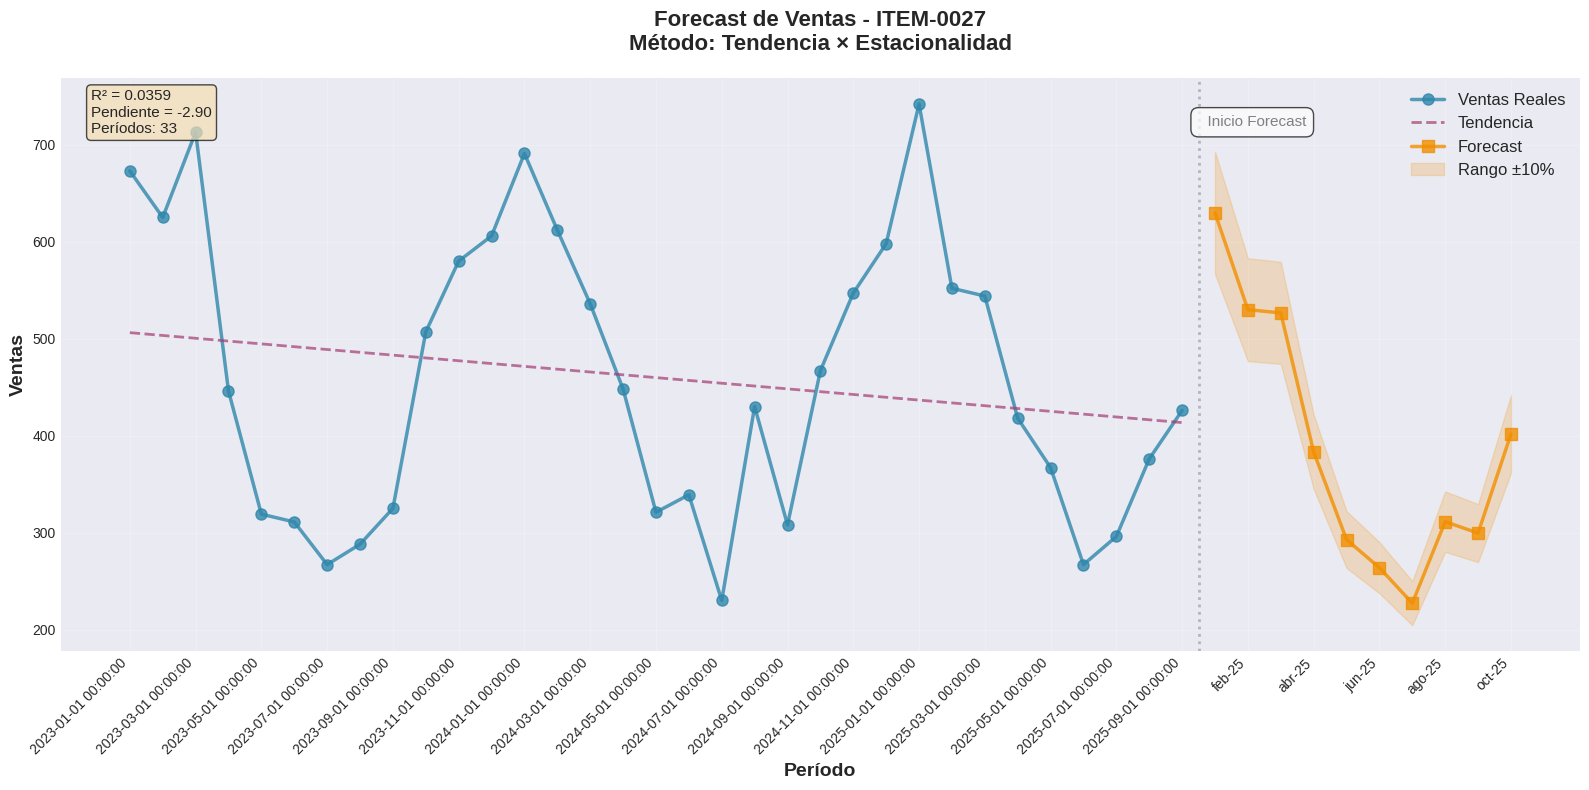


✓ Proceso completado exitosamente!

Resumen:
  - Item analizado: ITEM-0027
  - Columna: AB
  - Períodos históricos: 33
  - Tendencia: Decreciente
  - R²: 0.0359
  - Forecast generado: 10 meses


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para gráficas elegantes
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# URL del archivo
url = 'https://github.com/santiagonajera/PlanificacionProduccion/raw/refs/heads/main/ventas_mensuales_3500_items_2023_2025.xlsx'

# ==========================================
# CONFIGURACIÓN: Selecciona la columna del item a analizar
# ==========================================
# Opciones: 'B', 'C', 'D', ..., 'X', 'Y', 'Z', etc.
# (La columna A contiene las fechas, no un item)
COLUMNA_ITEM = 'AB'  # <-- CAMBIA ESTA LETRA PARA ANALIZAR OTRO ITEM
# ==========================================

# Convertir letra de columna a índice numérico (A=0, B=1, X=23, etc.)
def columna_a_indice(letra):
    """Convierte letra de columna a índice (A=0, B=1, etc.)"""
    letra = letra.upper()
    indice = 0
    for i, char in enumerate(reversed(letra)):
        indice += (ord(char) - ord('A') + 1) * (26 ** i)
    return indice - 1

item_col = columna_a_indice(COLUMNA_ITEM)
fecha_col = 0  # La columna A (índice 0) siempre tiene las fechas

# Leer el archivo Excel sin encabezados
print(f"Leyendo archivo desde GitHub...")
print(f"Analizando item en columna: {COLUMNA_ITEM} (índice {item_col})\n")
df = pd.read_excel(url, sheet_name='ITEMS', header=None)

# Verificar que la columna existe
if item_col >= df.shape[1]:
    print(f"ERROR: La columna {COLUMNA_ITEM} no existe en el archivo")
    print(f"El archivo tiene {df.shape[1]} columnas (A hasta {chr(65 + df.shape[1] - 1)})")
    exit()

# La fila 0 contiene los encabezados
# Columna A debe tener "ITEM"
# Las demás columnas tienen los códigos de items (ej: "ITEM-0023")
item_name = df.iloc[0, item_col]

if pd.isna(item_name):
    print(f"ERROR: La columna {COLUMNA_ITEM} no tiene un código de item en la fila 0")
    exit()

print(f"Procesando item: {item_name}")

# Extraer períodos y ventas
# Fila 0: encabezados (ITEM en col A, ITEM-0001 en col B, etc.)
# Fila 1 en adelante: fechas en columna A, valores en las demás columnas
data = []
dates = []

for i in range(1, df.shape[0]):  # Empezar desde fila 1
    period = df.iloc[i, fecha_col]  # Fecha en columna A (índice 0)
    value = df.iloc[i, item_col]    # Valor en la columna del item

    if pd.notna(period) and pd.notna(value):
        try:
            period_str = str(period).strip()
            value_num = float(value)

            dates.append(period_str)
            data.append(value_num)
        except:
            # Si hay error al convertir, seguir o terminar
            continue
    elif not pd.notna(period):
        # Si no hay fecha, terminaron los datos
        break

if len(data) == 0:
    print("ERROR: No se encontraron datos de ventas")
    exit()

print(f"\nTotal de períodos históricos: {len(data)}")
print(f"Rango de ventas: {min(data):.0f} - {max(data):.0f}")
print(f"Períodos: {dates[0]} hasta {dates[-1]}")

# 1. CALCULAR LA TENDENCIA (usando regresión lineal)
print("\n--- CALCULANDO TENDENCIA ---")
x = np.arange(len(data))
y = np.array(data)

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
tendencia = slope * x + intercept

print(f"Ecuación de tendencia: y = {slope:.2f}x + {intercept:.2f}")
print(f"R² = {r_value**2:.4f}")

# 2. CALCULAR LA ESTACIONALIDAD MENSUAL
print("\n--- CALCULANDO ESTACIONALIDAD ---")

meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
         'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

# Función para extraer mes y año del período
def extraer_mes_anio(periodo_str):
    """Extrae el mes y año de diferentes formatos de período"""
    periodo_str = str(periodo_str).strip().lower()

    # Intentar formato "mes-año" (ej: "ene-23", "enero-2023")
    if '-' in periodo_str:
        partes = periodo_str.split('-')
        mes_str = partes[0].strip()
        anio_str = partes[1].strip()

        # Buscar el mes en la lista
        for mes_nombre in meses:
            if mes_str.startswith(mes_nombre[:3]):
                # Convertir año a formato completo
                if len(anio_str) == 2:
                    anio = '20' + anio_str
                else:
                    anio = anio_str
                return mes_nombre, anio

    # Si es un objeto datetime de pandas
    try:
        fecha = pd.to_datetime(periodo_str)
        mes_nombre = meses[fecha.month - 1]
        anio = str(fecha.year)
        return mes_nombre, anio
    except:
        pass

    return None, None

print("\nMuestra de períodos detectados:")
for i in range(min(5, len(dates))):
    mes, anio = extraer_mes_anio(dates[i])
    print(f"  {dates[i]} -> Mes: {mes}, Año: {anio}")

# Primero, agrupar los datos por año y calcular el promedio de cada año
datos_por_anio = {}

for i, periodo in enumerate(dates):
    mes, anio = extraer_mes_anio(periodo)
    if mes and anio:
        if anio not in datos_por_anio:
            datos_por_anio[anio] = []
        datos_por_anio[anio].append(data[i])

# Calcular el promedio de cada año
promedio_por_anio = {}
print("\nPromedios anuales:")
for anio in sorted(datos_por_anio.keys()):
    promedio_por_anio[anio] = np.mean(datos_por_anio[anio])
    print(f"  Año {anio}: {promedio_por_anio[anio]:.2f} (basado en {len(datos_por_anio[anio])} meses)")

# Calcular índice estacional: demanda del mes / promedio del año
valores_por_mes = {mes: [] for mes in meses}

print("\nDetalle del cálculo de estacionalidad (primeros 3):")
count = 0
for i, periodo in enumerate(dates):
    mes, anio = extraer_mes_anio(periodo)
    if mes and anio and anio in promedio_por_anio:
        # ÍNDICE ESTACIONAL = demanda del mes / promedio anual
        indice_estacional = data[i] / promedio_por_anio[anio]
        valores_por_mes[mes].append(indice_estacional)

        # Mostrar primeros 3 ejemplos
        if count < 3:
            print(f"  {periodo}: {data[i]:.0f} / {promedio_por_anio[anio]:.2f} = {indice_estacional:.4f} ({indice_estacional*100:.0f}%)")
            count += 1

# Calcular el índice promedio de estacionalidad para cada mes
estacionalidad = {}
for mes in meses:
    if valores_por_mes[mes]:
        estacionalidad[mes] = np.mean(valores_por_mes[mes])
    else:
        estacionalidad[mes] = 1.0

print("\nÍndices de Estacionalidad por mes:")
for mes in meses:
    observaciones = len(valores_por_mes[mes])
    if observaciones > 0:
        print(f"  {mes.upper()}: {estacionalidad[mes]:.4f} ({estacionalidad[mes]*100:.0f}%) - {observaciones} obs")
    else:
        print(f"  {mes.upper()}: {estacionalidad[mes]:.4f} (sin datos)")

# 3. GENERAR FORECAST PARA LOS PRÓXIMOS 10 MESES
print("\n--- GENERANDO FORECAST ---")

# Determinar el último período
ultimo_periodo = dates[-1]
try:
    ultimo_mes_str, ultimo_anio_str = ultimo_periodo.split('-')
    ultimo_mes_str = ultimo_mes_str.lower()

    # Convertir año a 4 dígitos
    if len(ultimo_anio_str) == 2:
        ultimo_anio = int('20' + ultimo_anio_str)
    else:
        ultimo_anio = int(ultimo_anio_str)

    # Obtener número del mes
    if ultimo_mes_str in meses:
        ultimo_mes_num = meses.index(ultimo_mes_str) + 1
    else:
        ultimo_mes_num = 12

except:
    print(f"Advertencia: No se pudo interpretar el último período: {ultimo_periodo}")
    ultimo_anio = 2024
    ultimo_mes_num = 12

# Crear fechas para los próximos 10 meses
fecha_inicio = datetime(ultimo_anio, ultimo_mes_num, 1)
periodos_forecast = []

for i in range(1, 11):
    nueva_fecha = fecha_inicio + relativedelta(months=i)
    mes_nombre = meses[nueva_fecha.month - 1]
    anio_corto = str(nueva_fecha.year)[2:]
    periodo = f"{mes_nombre}-{anio_corto}"
    periodos_forecast.append(periodo)

# Calcular forecast = Tendencia * Estacionalidad
forecast_values = []
for i, periodo in enumerate(periodos_forecast):
    mes = periodo.split('-')[0].lower()
    # Índice para la tendencia (continuación de la serie)
    x_forecast = len(data) + i
    tendencia_valor = slope * x_forecast + intercept
    # Aplicar estacionalidad
    forecast = tendencia_valor * estacionalidad.get(mes, 1.0)
    forecast_values.append(forecast)

# Crear DataFrame con forecast
df_forecast = pd.DataFrame({
    'Periodo': periodos_forecast,
    'Forecast': forecast_values
})

print("\nForecast para los próximos 10 meses:")
for i, row in df_forecast.iterrows():
    print(f"  {row['Periodo']}: {row['Forecast']:.0f}")

# 4. CREAR GRÁFICA ELEGANTE
print("\n--- GENERANDO GRÁFICA ---")

fig, ax = plt.subplots(figsize=(16, 8))

# Crear eje x continuo
x_historical = np.arange(len(data))
x_forecast = np.arange(len(data), len(data) + len(forecast_values))

# Graficar datos históricos
ax.plot(x_historical, data, 'o-', linewidth=2.5, markersize=8,
        label='Ventas Reales', color='#2E86AB', alpha=0.8)

# Graficar tendencia
ax.plot(x_historical, tendencia, '--', linewidth=2,
        label='Tendencia', color='#A23B72', alpha=0.7)

# Graficar forecast
ax.plot(x_forecast, forecast_values, 's-', linewidth=2.5, markersize=8,
        label='Forecast', color='#F18F01', alpha=0.8)

# Área sombreada para el forecast (intervalo de confianza visual)
ax.fill_between(x_forecast,
                np.array(forecast_values) * 0.9,
                np.array(forecast_values) * 1.1,
                alpha=0.2, color='#F18F01', label='Rango ±10%')

# Añadir línea vertical separando histórico de forecast
ax.axvline(x=len(data)-0.5, color='gray', linestyle=':', linewidth=2, alpha=0.5)
ax.text(len(data)-0.5, ax.get_ylim()[1]*0.95, '  Inicio Forecast',
        rotation=0, verticalalignment='top', fontsize=11, color='gray',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7))

# Configuración de la gráfica
ax.set_xlabel('Período', fontsize=14, fontweight='bold')
ax.set_ylabel('Ventas', fontsize=14, fontweight='bold')
ax.set_title(f'Forecast de Ventas - {item_name}\nMétodo: Tendencia × Estacionalidad',
             fontsize=16, fontweight='bold', pad=20)

# Configurar etiquetas del eje x
todos_periodos = dates + periodos_forecast
x_ticks = list(range(0, len(todos_periodos), max(1, len(todos_periodos)//15)))
ax.set_xticks(x_ticks)
ax.set_xticklabels([todos_periodos[i] for i in x_ticks], rotation=45, ha='right')

# Grid y leyenda
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.legend(loc='best', fontsize=12, framealpha=0.9, shadow=True)

# Añadir información adicional
textstr = f'R² = {r_value**2:.4f}\nPendiente = {slope:.2f}\nPeríodos: {len(data)}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

print("\n✓ Proceso completado exitosamente!")
print(f"\nResumen:")
print(f"  - Item analizado: {item_name}")
print(f"  - Columna: {COLUMNA_ITEM}")
print(f"  - Períodos históricos: {len(data)}")
print(f"  - Tendencia: {'Creciente' if slope > 0 else 'Decreciente'}")
print(f"  - R²: {r_value**2:.4f}")
print(f"  - Forecast generado: {len(forecast_values)} meses")

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')

# URL del archivo
url = 'https://github.com/santiagonajera/PlanificacionProduccion/raw/refs/heads/main/ventas_mensuales_3500_items_2023_2025.xlsx'

print("="*80)
print("FORECAST MASIVO DE ITEMS")
print("="*80)

# Leer el archivo Excel sin encabezados
print(f"\nLeyendo archivo desde GitHub...")
df = pd.read_excel(url, sheet_name='ITEMS', header=None)

print(f"Archivo cargado: {df.shape[0]} filas x {df.shape[1]} columnas")

# La columna A (índice 0) tiene las fechas
# Las columnas B en adelante (índice 1+) tienen los items
fecha_col = 0
num_items = df.shape[1] - 1  # Restar 1 porque la columna A es de fechas

print(f"Total de items a procesar: {num_items}")

# Extraer las fechas (columna A, desde fila 1)
dates = []
for i in range(1, df.shape[0]):
    period = df.iloc[i, fecha_col]
    if pd.notna(period):
        dates.append(str(period).strip())
    else:
        break

print(f"Períodos históricos: {len(dates)} ({dates[0]} hasta {dates[-1]})")

# Función para extraer mes y año del período
def extraer_mes_anio(periodo_str):
    """Extrae el mes y año de diferentes formatos de período"""
    periodo_str = str(periodo_str).strip().lower()
    meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
             'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

    if '-' in periodo_str:
        partes = periodo_str.split('-')
        mes_str = partes[0].strip()
        anio_str = partes[1].strip()

        for mes_nombre in meses:
            if mes_str.startswith(mes_nombre[:3]):
                if len(anio_str) == 2:
                    anio = '20' + anio_str
                else:
                    anio = anio_str
                return mes_nombre, anio

    try:
        fecha = pd.to_datetime(periodo_str)
        mes_nombre = meses[fecha.month - 1]
        anio = str(fecha.year)
        return mes_nombre, anio
    except:
        pass

    return None, None

# Calcular períodos de forecast (próximos 10 meses)
ultimo_periodo = dates[-1]
meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
         'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

try:
    ultimo_mes_str, ultimo_anio_str = ultimo_periodo.split('-')
    ultimo_mes_str = ultimo_mes_str.lower()

    if len(ultimo_anio_str) == 2:
        ultimo_anio = int('20' + ultimo_anio_str)
    else:
        ultimo_anio = int(ultimo_anio_str)

    if ultimo_mes_str in meses:
        ultimo_mes_num = meses.index(ultimo_mes_str) + 1
    else:
        ultimo_mes_num = 12
except:
    ultimo_anio = 2024
    ultimo_mes_num = 12

# Crear fechas para los próximos 10 meses
fecha_inicio = datetime(ultimo_anio, ultimo_mes_num, 1)
periodos_forecast = []

for i in range(1, 11):
    nueva_fecha = fecha_inicio + relativedelta(months=i)
    mes_nombre = meses[nueva_fecha.month - 1]
    anio_corto = str(nueva_fecha.year)[2:]
    periodo = f"{mes_nombre}-{anio_corto}"
    periodos_forecast.append(periodo)

print(f"Forecast para: {periodos_forecast[0]} hasta {periodos_forecast[-1]}")

# Función para calcular forecast de un item
def calcular_forecast_item(valores, dates, periodos_forecast):
    """Calcula el forecast de un item usando tendencia x estacionalidad"""

    if len(valores) < 12:  # Necesitamos al menos 12 meses
        return [None] * len(periodos_forecast)

    # 1. Calcular tendencia
    x = np.arange(len(valores))
    y = np.array(valores)

    try:
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    except:
        return [None] * len(periodos_forecast)

    # 2. Calcular estacionalidad
    meses_list = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
                  'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

    # Agrupar por año
    datos_por_anio = {}
    for i, periodo in enumerate(dates):
        mes, anio = extraer_mes_anio(periodo)
        if mes and anio:
            if anio not in datos_por_anio:
                datos_por_anio[anio] = []
            datos_por_anio[anio].append(valores[i])

    # Promedio por año
    promedio_por_anio = {}
    for anio in datos_por_anio:
        promedio_por_anio[anio] = np.mean(datos_por_anio[anio])

    # Índices estacionales
    valores_por_mes = {mes: [] for mes in meses_list}

    for i, periodo in enumerate(dates):
        mes, anio = extraer_mes_anio(periodo)
        if mes and anio and anio in promedio_por_anio:
            indice_estacional = valores[i] / promedio_por_anio[anio]
            valores_por_mes[mes].append(indice_estacional)

    estacionalidad = {}
    for mes in meses_list:
        if valores_por_mes[mes]:
            estacionalidad[mes] = np.mean(valores_por_mes[mes])
        else:
            estacionalidad[mes] = 1.0

    # 3. Calcular forecast
    forecast_values = []
    for i, periodo in enumerate(periodos_forecast):
        mes = periodo.split('-')[0].lower()
        x_forecast = len(valores) + i
        tendencia_valor = slope * x_forecast + intercept
        forecast = tendencia_valor * estacionalidad.get(mes, 1.0)
        forecast_values.append(max(0, forecast))  # No permitir valores negativos

    return forecast_values

# Procesar todos los items
print("\n" + "="*80)
print("PROCESANDO ITEMS...")
print("="*80)

resultados = []
items_procesados = 0
items_con_error = 0

# Iterar por todas las columnas de items (desde columna B = índice 1)
for col_idx in range(1, df.shape[1]):
    # Nombre del item (fila 0)
    item_name = df.iloc[0, col_idx]

    if pd.isna(item_name):
        continue

    # Extraer valores del item
    valores = []
    for i in range(1, len(dates) + 1):
        value = df.iloc[i, col_idx]
        if pd.notna(value):
            try:
                valores.append(float(value))
            except:
                valores.append(0)
        else:
            valores.append(0)

    # Calcular forecast
    forecast_values = calcular_forecast_item(valores, dates, periodos_forecast)

    # Verificar si el forecast es válido
    if forecast_values[0] is None:
        items_con_error += 1
        continue

    # Guardar resultados
    resultado = {'ITEM': item_name}
    for i, periodo in enumerate(periodos_forecast):
        resultado[periodo] = round(forecast_values[i], 0)

    resultados.append(resultado)
    items_procesados += 1

    # Mostrar progreso cada 100 items
    if items_procesados % 100 == 0:
        print(f"Procesados: {items_procesados} items...")

print(f"\n✓ Proceso completado!")
print(f"  - Items procesados correctamente: {items_procesados}")
print(f"  - Items con error: {items_con_error}")

# Crear DataFrame con todos los resultados
df_forecast = pd.DataFrame(resultados)

print("\n" + "="*80)
print("RESULTADOS DEL FORECAST")
print("="*80)

# Mostrar primeros 10 items como ejemplo
print("\nPrimeros 10 items:")
print(df_forecast.head(10).to_string(index=False))

# Guardar a Excel
output_file = 'forecast_todos_items.xlsx'
df_forecast.to_excel(output_file, index=False, sheet_name='Forecast')

print(f"\n✓ Archivo generado exitosamente: {output_file}")
print(f"\nEl archivo contiene el forecast de {len(df_forecast)} items para los próximos 10 meses")

# Mostrar estadísticas generales
print("\n" + "="*80)
print("ESTADÍSTICAS GENERALES")
print("="*80)

for periodo in periodos_forecast:
    total = df_forecast[periodo].sum()
    promedio = df_forecast[periodo].mean()
    print(f"{periodo}: Total = {total:,.0f} | Promedio = {promedio:,.0f}")

print("\n" + "="*80)

FORECAST MASIVO DE ITEMS

Leyendo archivo desde GitHub...
Archivo cargado: 34 filas x 3502 columnas
Total de items a procesar: 3501
Períodos históricos: 33 (2023-01-01 00:00:00 hasta 2025-09-01 00:00:00)
Forecast para: ene-25 hasta oct-25

PROCESANDO ITEMS...
Procesados: 100 items...
Procesados: 200 items...
Procesados: 300 items...
Procesados: 400 items...
Procesados: 500 items...
Procesados: 600 items...
Procesados: 700 items...
Procesados: 800 items...
Procesados: 900 items...
Procesados: 1000 items...
Procesados: 1100 items...
Procesados: 1200 items...
Procesados: 1300 items...
Procesados: 1400 items...
Procesados: 1500 items...
Procesados: 1600 items...
Procesados: 1700 items...
Procesados: 1800 items...
Procesados: 1900 items...
Procesados: 2000 items...
Procesados: 2100 items...
Procesados: 2200 items...
Procesados: 2300 items...
Procesados: 2400 items...
Procesados: 2500 items...
Procesados: 2600 items...
Procesados: 2700 items...
Procesados: 2800 items...
Procesados: 2900 item

In [4]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')

# URL del archivo
url = 'https://github.com/santiagonajera/PlanificacionProduccion/raw/refs/heads/main/ventas_mensuales_3500_items_2023_2025.xlsx'

# ==========================================
# CONFIGURACIÓN: Selecciona la columna del item a analizar
# ==========================================
# Opciones: 'B' = ITEM-0001, 'C' = ITEM-0002, 'D' = ITEM-0003, etc.
COLUMNA_ITEM = 'B'  # <-- CAMBIA ESTA LETRA PARA ANALIZAR OTRO ITEM
# ==========================================

# Convertir letra de columna a índice numérico (A=0, B=1, X=23, etc.)
def columna_a_indice(letra):
    """Convierte letra de columna a índice (A=0, B=1, etc.)"""
    letra = letra.upper()
    indice = 0
    for i, char in enumerate(reversed(letra)):
        indice += (ord(char) - ord('A') + 1) * (26 ** i)
    return indice - 1

item_col = columna_a_indice(COLUMNA_ITEM)
fecha_col = 0  # La columna A siempre tiene las fechas

# Leer el archivo Excel
print("="*80)
print("FORECAST CON CÁLCULO DE RMSE")
print("="*80)
print(f"\nLeyendo archivo desde GitHub...")
print(f"Analizando item en columna: {COLUMNA_ITEM} (índice {item_col})\n")

df = pd.read_excel(url, sheet_name='ITEMS', header=None)

# Obtener nombre del item
item_name = df.iloc[0, item_col]
print(f"Procesando item: {item_name}")

# Extraer fechas y valores
data = []
dates = []

for i in range(1, df.shape[0]):
    period = df.iloc[i, fecha_col]
    value = df.iloc[i, item_col]

    if pd.notna(period) and pd.notna(value):
        try:
            dates.append(str(period).strip())
            data.append(float(value))
        except:
            continue
    elif not pd.notna(period):
        break

print(f"\nTotal de períodos históricos: {len(data)}")
print(f"Rango de ventas: {min(data):.0f} - {max(data):.0f}")
print(f"Períodos: {dates[0]} hasta {dates[-1]}")

# Función para extraer mes y año
def extraer_mes_anio(periodo_str):
    periodo_str = str(periodo_str).strip().lower()
    meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
             'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

    if '-' in periodo_str:
        partes = periodo_str.split('-')
        mes_str = partes[0].strip()
        anio_str = partes[1].strip()

        for mes_nombre in meses:
            if mes_str.startswith(mes_nombre[:3]):
                if len(anio_str) == 2:
                    anio = '20' + anio_str
                else:
                    anio = anio_str
                return mes_nombre, anio

    try:
        fecha = pd.to_datetime(periodo_str)
        mes_nombre = meses[fecha.month - 1]
        anio = str(fecha.year)
        return mes_nombre, anio
    except:
        pass

    return None, None

# 1. CALCULAR LA TENDENCIA
print("\n" + "="*80)
print("CALCULANDO TENDENCIA")
print("="*80)

x = np.arange(len(data))
y = np.array(data)

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
tendencia = slope * x + intercept

print(f"\nEcuación de tendencia: y = {slope:.2f}x + {intercept:.2f}")
print(f"R² = {r_value**2:.4f}")

# 2. CALCULAR LA ESTACIONALIDAD
print("\n" + "="*80)
print("CALCULANDO ESTACIONALIDAD")
print("="*80)

meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
         'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

# Agrupar por año
datos_por_anio = {}
for i, periodo in enumerate(dates):
    mes, anio = extraer_mes_anio(periodo)
    if mes and anio:
        if anio not in datos_por_anio:
            datos_por_anio[anio] = []
        datos_por_anio[anio].append(data[i])

# Promedio por año
promedio_por_anio = {}
print("\nPromedios anuales:")
for anio in sorted(datos_por_anio.keys()):
    promedio_por_anio[anio] = np.mean(datos_por_anio[anio])
    print(f"  Año {anio}: {promedio_por_anio[anio]:.2f} (basado en {len(datos_por_anio[anio])} meses)")

# Calcular índices estacionales
valores_por_mes = {mes: [] for mes in meses}

for i, periodo in enumerate(dates):
    mes, anio = extraer_mes_anio(periodo)
    if mes and anio and anio in promedio_por_anio:
        indice_estacional = data[i] / promedio_por_anio[anio]
        valores_por_mes[mes].append(indice_estacional)

# Promedio de índices por mes
estacionalidad = {}
for mes in meses:
    if valores_por_mes[mes]:
        estacionalidad[mes] = np.mean(valores_por_mes[mes])
    else:
        estacionalidad[mes] = 1.0

print("\nÍndices de Estacionalidad por mes:")
for mes in meses:
    observaciones = len(valores_por_mes[mes])
    if observaciones > 0:
        print(f"  {mes.upper()}: {estacionalidad[mes]:.4f} ({estacionalidad[mes]*100:.0f}%)")

# 3. CALCULAR VALORES AJUSTADOS (FITTED) PARA EL PERÍODO HISTÓRICO
print("\n" + "="*80)
print("CALCULANDO VALORES AJUSTADOS DEL MODELO")
print("="*80)

valores_ajustados = []

for i, periodo in enumerate(dates):
    mes, anio = extraer_mes_anio(periodo)
    if mes:
        # Valor ajustado = Tendencia * Estacionalidad
        tendencia_valor = slope * i + intercept
        valor_ajustado = tendencia_valor * estacionalidad[mes]
        valores_ajustados.append(valor_ajustado)
    else:
        valores_ajustados.append(data[i])

# 4. CALCULAR RMSE
print("\nCalculando RMSE (Root Mean Square Error)...")

# RMSE = sqrt(mean((real - predicho)^2))
errores = np.array(data) - np.array(valores_ajustados)
rmse = np.sqrt(np.mean(errores ** 2))

# Otras métricas de error
mae = np.mean(np.abs(errores))  # Mean Absolute Error
mape = np.mean(np.abs(errores / np.array(data))) * 100  # Mean Absolute Percentage Error

print(f"\n{'='*80}")
print("MÉTRICAS DE ERROR DEL MODELO")
print(f"{'='*80}")
print(f"RMSE (Root Mean Square Error): {rmse:.2f}")
print(f"MAE (Mean Absolute Error):     {mae:.2f}")
print(f"MAPE (Mean Absolute % Error):  {mape:.2f}%")
print(f"{'='*80}")

# Mostrar comparación de primeros 10 períodos
print("\nComparación Real vs Ajustado (primeros 10 períodos):")
print(f"{'Período':<12} {'Real':>8} {'Ajustado':>10} {'Error':>8}")
print("-" * 42)
for i in range(min(10, len(dates))):
    error = data[i] - valores_ajustados[i]
    print(f"{dates[i]:<12} {data[i]:>8.0f} {valores_ajustados[i]:>10.2f} {error:>8.2f}")

# 5. GENERAR FORECAST PARA LOS PRÓXIMOS 10 MESES
print("\n" + "="*80)
print("GENERANDO FORECAST")
print("="*80)

# Determinar último período
ultimo_periodo = dates[-1]
try:
    ultimo_mes_str, ultimo_anio_str = ultimo_periodo.split('-')
    ultimo_mes_str = ultimo_mes_str.lower()

    if len(ultimo_anio_str) == 2:
        ultimo_anio = int('20' + ultimo_anio_str)
    else:
        ultimo_anio = int(ultimo_anio_str)

    if ultimo_mes_str in meses:
        ultimo_mes_num = meses.index(ultimo_mes_str) + 1
    else:
        ultimo_mes_num = 12
except:
    ultimo_anio = 2024
    ultimo_mes_num = 12

# Crear períodos de forecast
fecha_inicio = datetime(ultimo_anio, ultimo_mes_num, 1)
periodos_forecast = []

for i in range(1, 11):
    nueva_fecha = fecha_inicio + relativedelta(months=i)
    mes_nombre = meses[nueva_fecha.month - 1]
    anio_corto = str(nueva_fecha.year)[2:]
    periodo = f"{mes_nombre}-{anio_corto}"
    periodos_forecast.append(periodo)

# Calcular forecast
forecast_values = []
for i, periodo in enumerate(periodos_forecast):
    mes = periodo.split('-')[0].lower()
    x_forecast = len(data) + i
    tendencia_valor = slope * x_forecast + intercept
    forecast = tendencia_valor * estacionalidad.get(mes, 1.0)
    forecast_values.append(max(0, forecast))

# Crear DataFrame con resultados
df_forecast = pd.DataFrame({
    'Periodo': periodos_forecast,
    'Forecast': forecast_values
})

print("\nForecast para los próximos 10 meses:")
print(df_forecast.to_string(index=False))

# Resumen final
print("\n" + "="*80)
print("RESUMEN FINAL")
print("="*80)
print(f"Item:                    {item_name}")
print(f"Columna:                 {COLUMNA_ITEM}")
print(f"Períodos históricos:     {len(data)}")
print(f"Tendencia:               {'Creciente' if slope > 0 else 'Decreciente'} ({slope:.2f})")
print(f"R²:                      {r_value**2:.4f}")
print(f"RMSE:                    {rmse:.2f}")
print(f"MAE:                     {mae:.2f}")
print(f"MAPE:                    {mape:.2f}%")
print(f"Forecast generado:       {len(forecast_values)} meses")
print("="*80)

FORECAST CON CÁLCULO DE RMSE

Leyendo archivo desde GitHub...
Analizando item en columna: B (índice 1)

Procesando item: ITEM-0001

Total de períodos históricos: 33
Rango de ventas: 458 - 803
Períodos: 2023-01-01 00:00:00 hasta 2025-09-01 00:00:00

CALCULANDO TENDENCIA

Ecuación de tendencia: y = -0.16x + 614.73
R² = 0.0003

CALCULANDO ESTACIONALIDAD

Promedios anuales:
  Año 2023: 610.17 (basado en 12 meses)
  Año 2024: 601.25 (basado en 12 meses)
  Año 2025: 629.56 (basado en 9 meses)

Índices de Estacionalidad por mes:
  ENE: 0.9546 (95%)
  FEB: 1.1549 (115%)
  MAR: 1.0333 (103%)
  ABR: 1.0449 (104%)
  MAY: 1.0514 (105%)
  JUN: 1.0149 (101%)
  JUL: 0.9925 (99%)
  AGO: 0.8935 (89%)
  SEP: 0.9332 (93%)
  OCT: 0.8956 (90%)
  NOV: 0.9512 (95%)
  DIC: 1.0435 (104%)

CALCULANDO VALORES AJUSTADOS DEL MODELO

Calculando RMSE (Root Mean Square Error)...

MÉTRICAS DE ERROR DEL MODELO
RMSE (Root Mean Square Error): 68.56
MAE (Mean Absolute Error):     56.36
MAPE (Mean Absolute % Error):  9.47%

In [5]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')

# URL del archivo
url = 'https://github.com/santiagonajera/PlanificacionProduccion/raw/refs/heads/main/ventas_mensuales_3500_items_2023_2025.xlsx'

# ==========================================
# CONFIGURACIÓN: Selecciona la columna del item a analizar
# ==========================================
# Opciones: 'B' = ITEM-0001, 'C' = ITEM-0002, 'D' = ITEM-0003, etc.
COLUMNA_ITEM = 'B'  # <-- CAMBIA ESTA LETRA PARA ANALIZAR OTRO ITEM
# ==========================================

# Convertir letra de columna a índice numérico (A=0, B=1, X=23, etc.)
def columna_a_indice(letra):
    """Convierte letra de columna a índice (A=0, B=1, etc.)"""
    letra = letra.upper()
    indice = 0
    for i, char in enumerate(reversed(letra)):
        indice += (ord(char) - ord('A') + 1) * (26 ** i)
    return indice - 1

item_col = columna_a_indice(COLUMNA_ITEM)
fecha_col = 0  # La columna A siempre tiene las fechas

# Leer el archivo Excel
print("="*80)
print("FORECAST CON CÁLCULO DE RMSE")
print("="*80)
print(f"\nLeyendo archivo desde GitHub...")
print(f"Analizando item en columna: {COLUMNA_ITEM} (índice {item_col})\n")

df = pd.read_excel(url, sheet_name='ITEMS', header=None)

# Obtener nombre del item
item_name = df.iloc[0, item_col]
print(f"Procesando item: {item_name}")

# Extraer fechas y valores
data = []
dates = []

for i in range(1, df.shape[0]):
    period = df.iloc[i, fecha_col]
    value = df.iloc[i, item_col]

    if pd.notna(period) and pd.notna(value):
        try:
            dates.append(str(period).strip())
            data.append(float(value))
        except:
            continue
    elif not pd.notna(period):
        break

print(f"\nTotal de períodos históricos: {len(data)}")
print(f"Rango de ventas: {min(data):.0f} - {max(data):.0f}")
print(f"Períodos: {dates[0]} hasta {dates[-1]}")

# Función para extraer mes y año
def extraer_mes_anio(periodo_str):
    periodo_str = str(periodo_str).strip().lower()
    meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
             'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

    if '-' in periodo_str:
        partes = periodo_str.split('-')
        mes_str = partes[0].strip()
        anio_str = partes[1].strip()

        for mes_nombre in meses:
            if mes_str.startswith(mes_nombre[:3]):
                if len(anio_str) == 2:
                    anio = '20' + anio_str
                else:
                    anio = anio_str
                return mes_nombre, anio

    try:
        fecha = pd.to_datetime(periodo_str)
        mes_nombre = meses[fecha.month - 1]
        anio = str(fecha.year)
        return mes_nombre, anio
    except:
        pass

    return None, None

# 1. CALCULAR LA TENDENCIA
print("\n" + "="*80)
print("CALCULANDO TENDENCIA")
print("="*80)

x = np.arange(len(data))
y = np.array(data)

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
tendencia = slope * x + intercept

print(f"\nEcuación de tendencia: y = {slope:.2f}x + {intercept:.2f}")
print(f"R² = {r_value**2:.4f}")

# 2. CALCULAR LA ESTACIONALIDAD
print("\n" + "="*80)
print("CALCULANDO ESTACIONALIDAD")
print("="*80)

meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
         'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

# Agrupar por año
datos_por_anio = {}
for i, periodo in enumerate(dates):
    mes, anio = extraer_mes_anio(periodo)
    if mes and anio:
        if anio not in datos_por_anio:
            datos_por_anio[anio] = []
        datos_por_anio[anio].append(data[i])

# Promedio por año
promedio_por_anio = {}
print("\nPromedios anuales:")
for anio in sorted(datos_por_anio.keys()):
    promedio_por_anio[anio] = np.mean(datos_por_anio[anio])
    print(f"  Año {anio}: {promedio_por_anio[anio]:.2f} (basado en {len(datos_por_anio[anio])} meses)")

# Calcular índices estacionales
valores_por_mes = {mes: [] for mes in meses}

for i, periodo in enumerate(dates):
    mes, anio = extraer_mes_anio(periodo)
    if mes and anio and anio in promedio_por_anio:
        indice_estacional = data[i] / promedio_por_anio[anio]
        valores_por_mes[mes].append(indice_estacional)

# Promedio de índices por mes
estacionalidad = {}
for mes in meses:
    if valores_por_mes[mes]:
        estacionalidad[mes] = np.mean(valores_por_mes[mes])
    else:
        estacionalidad[mes] = 1.0

print("\nÍndices de Estacionalidad por mes:")
for mes in meses:
    observaciones = len(valores_por_mes[mes])
    if observaciones > 0:
        print(f"  {mes.upper()}: {estacionalidad[mes]:.4f} ({estacionalidad[mes]*100:.0f}%)")

# 3. CALCULAR VALORES AJUSTADOS (FITTED) PARA EL PERÍODO HISTÓRICO
print("\n" + "="*80)
print("CALCULANDO VALORES AJUSTADOS DEL MODELO")
print("="*80)

valores_ajustados = []

for i, periodo in enumerate(dates):
    mes, anio = extraer_mes_anio(periodo)
    if mes:
        # Valor ajustado = Tendencia * Estacionalidad
        tendencia_valor = slope * i + intercept
        valor_ajustado = tendencia_valor * estacionalidad[mes]
        valores_ajustados.append(valor_ajustado)
    else:
        valores_ajustados.append(data[i])

# 4. CALCULAR RMSE DEL MÉTODO 1 (TENDENCIA × ESTACIONALIDAD)
print("\nCalculando RMSE del Método 1...")

# RMSE = sqrt(mean((real - predicho)^2))
errores_metodo1 = np.array(data) - np.array(valores_ajustados)
rmse_metodo1 = np.sqrt(np.mean(errores_metodo1 ** 2))

print(f"\n{'='*80}")
print("MÉTODO 1: TENDENCIA × ESTACIONALIDAD")
print(f"{'='*80}")
print(f"RMSE (Root Mean Square Error): {rmse_metodo1:.2f}")
print(f"{'='*80}")

# 5. MÉTODO 2: PROMEDIO MÓVIL DE 2 PERÍODOS
print("\n" + "="*80)
print("MÉTODO 2: PROMEDIO MÓVIL DE 2 PERÍODOS")
print("="*80)

# Calcular valores ajustados con promedio móvil de 2 períodos
valores_ajustados_pm2 = []

for i in range(len(data)):
    if i == 0:
        # Para el primer período, usar el valor real (no hay período anterior)
        valores_ajustados_pm2.append(data[i])
    else:
        # Promedio móvil de 2 períodos = (t-1 + t-2) / 2
        if i == 1:
            pm2 = data[i-1]  # Solo hay 1 período anterior
        else:
            pm2 = (data[i-1] + data[i-2]) / 2
        valores_ajustados_pm2.append(pm2)

# Calcular RMSE del promedio móvil (empezando desde el período 1, ya que el período 0 no tiene predicción)
errores_pm2 = []
for i in range(1, len(data)):
    error = data[i] - valores_ajustados_pm2[i]
    errores_pm2.append(error)

rmse_metodo2 = np.sqrt(np.mean(np.array(errores_pm2) ** 2))

print(f"\nRMSE (Root Mean Square Error): {rmse_metodo2:.2f}")
print(f"{'='*80}")

# Mostrar comparación de ambos métodos
print("\n" + "="*80)
print("COMPARACIÓN DE MÉTODOS")
print("="*80)
print(f"{'Método':<40} {'RMSE':>10}")
print("-" * 52)
print(f"{'Método 1: Tendencia × Estacionalidad':<40} {rmse_metodo1:>10.2f}")
print(f"{'Método 2: Promedio Móvil 2 Períodos':<40} {rmse_metodo2:>10.2f}")
print("-" * 52)

if rmse_metodo1 < rmse_metodo2:
    diferencia = rmse_metodo2 - rmse_metodo1
    mejora = (diferencia / rmse_metodo2) * 100
    print(f"\n✓ El Método 1 es MEJOR (menor RMSE)")
    print(f"  Diferencia: {diferencia:.2f} ({mejora:.1f}% mejor)")
else:
    diferencia = rmse_metodo1 - rmse_metodo2
    mejora = (diferencia / rmse_metodo1) * 100
    print(f"\n✓ El Método 2 es MEJOR (menor RMSE)")
    print(f"  Diferencia: {diferencia:.2f} ({mejora:.1f}% mejor)")

print("="*80)

# Mostrar comparación de primeros 10 períodos
print("\nComparación Real vs Ajustado (primeros 10 períodos):")
print(f"{'Período':<12} {'Real':>8} {'Método 1':>10} {'Método 2':>10} {'Error M1':>10} {'Error M2':>10}")
print("-" * 68)
for i in range(min(10, len(dates))):
    error1 = data[i] - valores_ajustados[i]
    if i > 0:
        error2 = data[i] - valores_ajustados_pm2[i]
        print(f"{dates[i]:<12} {data[i]:>8.0f} {valores_ajustados[i]:>10.2f} {valores_ajustados_pm2[i]:>10.2f} {error1:>10.2f} {error2:>10.2f}")
    else:
        print(f"{dates[i]:<12} {data[i]:>8.0f} {valores_ajustados[i]:>10.2f} {'---':>10} {error1:>10.2f} {'---':>10}")

# 6. GENERAR FORECAST PARA LOS PRÓXIMOS 10 MESES
print("\n" + "="*80)
print("GENERANDO FORECAST CON AMBOS MÉTODOS")
print("="*80)

# Determinar último período
ultimo_periodo = dates[-1]
try:
    ultimo_mes_str, ultimo_anio_str = ultimo_periodo.split('-')
    ultimo_mes_str = ultimo_mes_str.lower()

    if len(ultimo_anio_str) == 2:
        ultimo_anio = int('20' + ultimo_anio_str)
    else:
        ultimo_anio = int(ultimo_anio_str)

    if ultimo_mes_str in meses:
        ultimo_mes_num = meses.index(ultimo_mes_str) + 1
    else:
        ultimo_mes_num = 12
except:
    ultimo_anio = 2024
    ultimo_mes_num = 12

# Crear períodos de forecast
fecha_inicio = datetime(ultimo_anio, ultimo_mes_num, 1)
periodos_forecast = []

for i in range(1, 11):
    nueva_fecha = fecha_inicio + relativedelta(months=i)
    mes_nombre = meses[nueva_fecha.month - 1]
    anio_corto = str(nueva_fecha.year)[2:]
    periodo = f"{mes_nombre}-{anio_corto}"
    periodos_forecast.append(periodo)

# FORECAST MÉTODO 1: Tendencia × Estacionalidad
forecast_metodo1 = []
for i, periodo in enumerate(periodos_forecast):
    mes = periodo.split('-')[0].lower()
    x_forecast = len(data) + i
    tendencia_valor = slope * x_forecast + intercept
    forecast = tendencia_valor * estacionalidad.get(mes, 1.0)
    forecast_metodo1.append(max(0, forecast))

# FORECAST MÉTODO 2: Promedio Móvil de 2 Períodos
forecast_metodo2 = []
valores_extendidos = data.copy()  # Copiar valores históricos

for i in range(len(periodos_forecast)):
    if len(valores_extendidos) >= 2:
        # Promedio de los últimos 2 períodos
        pm2 = (valores_extendidos[-1] + valores_extendidos[-2]) / 2
    else:
        pm2 = valores_extendidos[-1]

    forecast_metodo2.append(max(0, pm2))
    valores_extendidos.append(pm2)  # Agregar el forecast para usarlo en el siguiente período

# Crear DataFrame con resultados
df_forecast = pd.DataFrame({
    'Periodo': periodos_forecast,
    'Método 1 (Tend×Estac)': forecast_metodo1,
    'Método 2 (PM-2)': forecast_metodo2
})

print("\nForecast para los próximos 10 meses:")
print(df_forecast.to_string(index=False))

# Resumen final
print("\n" + "="*80)
print("RESUMEN FINAL")
print("="*80)
print(f"Item:                           {item_name}")
print(f"Columna:                        {COLUMNA_ITEM}")
print(f"Períodos históricos:            {len(data)}")
print(f"Tendencia:                      {'Creciente' if slope > 0 else 'Decreciente'} ({slope:.2f})")
print(f"R²:                             {r_value**2:.4f}")
print(f"\n--- COMPARACIÓN DE MÉTODOS ---")
print(f"RMSE Método 1 (Tend×Estac):     {rmse_metodo1:.2f}")
print(f"RMSE Método 2 (PM-2):           {rmse_metodo2:.2f}")
if rmse_metodo1 < rmse_metodo2:
    print(f"Mejor método:                   Método 1 (Tendencia × Estacionalidad)")
else:
    print(f"Mejor método:                   Método 2 (Promedio Móvil)")
print(f"\nForecast generado:              {len(periodos_forecast)} meses")
print("="*80)

FORECAST CON CÁLCULO DE RMSE

Leyendo archivo desde GitHub...
Analizando item en columna: B (índice 1)

Procesando item: ITEM-0001

Total de períodos históricos: 33
Rango de ventas: 458 - 803
Períodos: 2023-01-01 00:00:00 hasta 2025-09-01 00:00:00

CALCULANDO TENDENCIA

Ecuación de tendencia: y = -0.16x + 614.73
R² = 0.0003

CALCULANDO ESTACIONALIDAD

Promedios anuales:
  Año 2023: 610.17 (basado en 12 meses)
  Año 2024: 601.25 (basado en 12 meses)
  Año 2025: 629.56 (basado en 9 meses)

Índices de Estacionalidad por mes:
  ENE: 0.9546 (95%)
  FEB: 1.1549 (115%)
  MAR: 1.0333 (103%)
  ABR: 1.0449 (104%)
  MAY: 1.0514 (105%)
  JUN: 1.0149 (101%)
  JUL: 0.9925 (99%)
  AGO: 0.8935 (89%)
  SEP: 0.9332 (93%)
  OCT: 0.8956 (90%)
  NOV: 0.9512 (95%)
  DIC: 1.0435 (104%)

CALCULANDO VALORES AJUSTADOS DEL MODELO

Calculando RMSE del Método 1...

MÉTODO 1: TENDENCIA × ESTACIONALIDAD
RMSE (Root Mean Square Error): 68.56

MÉTODO 2: PROMEDIO MÓVIL DE 2 PERÍODOS

RMSE (Root Mean Square Error): 79.66

In [7]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')

# URL del archivo
url = 'https://github.com/santiagonajera/PlanificacionProduccion/raw/refs/heads/main/ventas_mensuales_3500_items_2023_2025.xlsx'

# ==========================================
# CONFIGURACIÓN: Selecciona la columna del item a analizar
# ==========================================
# Opciones: 'B' = ITEM-0001, 'C' = ITEM-0002, 'D' = ITEM-0003, etc.
COLUMNA_ITEM = 'B'  # <-- CAMBIA ESTA LETRA PARA ANALIZAR OTRO ITEM
# ==========================================

# Convertir letra de columna a índice numérico (A=0, B=1, X=23, etc.)
def columna_a_indice(letra):
    """Convierte letra de columna a índice (A=0, B=1, etc.)"""
    letra = letra.upper()
    indice = 0
    for i, char in enumerate(reversed(letra)):
        indice += (ord(char) - ord('A') + 1) * (26 ** i)
    return indice - 1

item_col = columna_a_indice(COLUMNA_ITEM)
fecha_col = 0  # La columna A siempre tiene las fechas

# Leer el archivo Excel
print("="*80)
print("FORECAST CON CÁLCULO DE RMSE")
print("="*80)
print(f"\nLeyendo archivo desde GitHub...")
print(f"Analizando item en columna: {COLUMNA_ITEM} (índice {item_col})\n")

df = pd.read_excel(url, sheet_name='ITEMS', header=None)

# Obtener nombre del item
item_name = df.iloc[0, item_col]
print(f"Procesando item: {item_name}")

# Extraer fechas y valores
data = []
dates = []

for i in range(1, df.shape[0]):
    period = df.iloc[i, fecha_col]
    value = df.iloc[i, item_col]

    if pd.notna(period) and pd.notna(value):
        try:
            dates.append(str(period).strip())
            data.append(float(value))
        except:
            continue
    elif not pd.notna(period):
        break

print(f"\nTotal de períodos históricos: {len(data)}")
print(f"Rango de ventas: {min(data):.0f} - {max(data):.0f}")
print(f"Períodos: {dates[0]} hasta {dates[-1]}")

# Función para extraer mes y año
def extraer_mes_anio(periodo_str):
    periodo_str = str(periodo_str).strip().lower()
    meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
             'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

    if '-' in periodo_str:
        partes = periodo_str.split('-')
        mes_str = partes[0].strip()
        anio_str = partes[1].strip()

        for mes_nombre in meses:
            if mes_str.startswith(mes_nombre[:3]):
                if len(anio_str) == 2:
                    anio = '20' + anio_str
                else:
                    anio = anio_str
                return mes_nombre, anio

    try:
        fecha = pd.to_datetime(periodo_str)
        mes_nombre = meses[fecha.month - 1]
        anio = str(fecha.year)
        return mes_nombre, anio
    except:
        pass

    return None, None

# 1. CALCULAR LA TENDENCIA
print("\n" + "="*80)
print("CALCULANDO TENDENCIA")
print("="*80)

x = np.arange(len(data))
y = np.array(data)

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
tendencia = slope * x + intercept

print(f"\nEcuación de tendencia: y = {slope:.2f}x + {intercept:.2f}")
print(f"R² = {r_value**2:.4f}")

# 2. CALCULAR LA ESTACIONALIDAD
print("\n" + "="*80)
print("CALCULANDO ESTACIONALIDAD")
print("="*80)

meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
         'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

# Agrupar por año
datos_por_anio = {}
for i, periodo in enumerate(dates):
    mes, anio = extraer_mes_anio(periodo)
    if mes and anio:
        if anio not in datos_por_anio:
            datos_por_anio[anio] = []
        datos_por_anio[anio].append(data[i])

# Promedio por año
promedio_por_anio = {}
print("\nPromedios anuales:")
for anio in sorted(datos_por_anio.keys()):
    promedio_por_anio[anio] = np.mean(datos_por_anio[anio])
    print(f"  Año {anio}: {promedio_por_anio[anio]:.2f} (basado en {len(datos_por_anio[anio])} meses)")

# Calcular índices estacionales
valores_por_mes = {mes: [] for mes in meses}

for i, periodo in enumerate(dates):
    mes, anio = extraer_mes_anio(periodo)
    if mes and anio and anio in promedio_por_anio:
        indice_estacional = data[i] / promedio_por_anio[anio]
        valores_por_mes[mes].append(indice_estacional)

# Promedio de índices por mes
estacionalidad = {}
for mes in meses:
    if valores_por_mes[mes]:
        estacionalidad[mes] = np.mean(valores_por_mes[mes])
    else:
        estacionalidad[mes] = 1.0

print("\nÍndices de Estacionalidad por mes:")
for mes in meses:
    observaciones = len(valores_por_mes[mes])
    if observaciones > 0:
        print(f"  {mes.upper()}: {estacionalidad[mes]:.4f} ({estacionalidad[mes]*100:.0f}%)")

# 3. CALCULAR VALORES AJUSTADOS (FITTED) PARA EL PERÍODO HISTÓRICO
print("\n" + "="*80)
print("CALCULANDO VALORES AJUSTADOS DEL MODELO")
print("="*80)

valores_ajustados = []

for i, periodo in enumerate(dates):
    mes, anio = extraer_mes_anio(periodo)
    if mes:
        # Valor ajustado = Tendencia * Estacionalidad
        tendencia_valor = slope * i + intercept
        valor_ajustado = tendencia_valor * estacionalidad[mes]
        valores_ajustados.append(valor_ajustado)
    else:
        valores_ajustados.append(data[i])

# 4. CALCULAR RMSE DEL MÉTODO 1 (TENDENCIA × ESTACIONALIDAD)
print("\nCalculando RMSE del Método 1...")

# RMSE = sqrt(mean((real - predicho)^2))
errores_metodo1 = np.array(data) - np.array(valores_ajustados)
rmse_metodo1 = np.sqrt(np.mean(errores_metodo1 ** 2))

print(f"\n{'='*80}")
print("MÉTODO 1: TENDENCIA × ESTACIONALIDAD")
print(f"{'='*80}")
print(f"RMSE (Root Mean Square Error): {rmse_metodo1:.2f}")
print(f"{'='*80}")

# 5. MÉTODO 2: PROMEDIO MÓVIL DE 2 PERÍODOS
print("\n" + "="*80)
print("MÉTODO 2: PROMEDIO MÓVIL DE 2 PERÍODOS")
print("="*80)

# Calcular valores ajustados con promedio móvil de 2 períodos
valores_ajustados_pm2 = []

for i in range(len(data)):
    if i == 0:
        # Para el primer período, usar el valor real (no hay período anterior)
        valores_ajustados_pm2.append(data[i])
    else:
        # Promedio móvil de 2 períodos = (t-1 + t-2) / 2
        if i == 1:
            pm2 = data[i-1]  # Solo hay 1 período anterior
        else:
            pm2 = (data[i-1] + data[i-2]) / 2
        valores_ajustados_pm2.append(pm2)

# Calcular RMSE del promedio móvil (empezando desde el período 1, ya que el período 0 no tiene predicción)
errores_pm2 = []
for i in range(1, len(data)):
    error = data[i] - valores_ajustados_pm2[i]
    errores_pm2.append(error)

rmse_metodo2 = np.sqrt(np.mean(np.array(errores_pm2) ** 2))

print(f"\nRMSE (Root Mean Square Error): {rmse_metodo2:.2f}")
print(f"{'='*80}")

# 6. MÉTODO 3: SUAVIZAMIENTO EXPONENCIAL (α = 0.10)
print("\n" + "="*80)
print("MÉTODO 3: SUAVIZAMIENTO EXPONENCIAL (α = 0.10)")
print("="*80)

alpha = 0.10
valores_ajustados_se = []
s_anterior = data[0]  # Inicializar con el primer valor

for i in range(len(data)):
    if i == 0:
        # Para el primer período, no hay pronóstico previo
        valores_ajustados_se.append(data[i])
        s_anterior = data[i]
    else:
        # El pronóstico para el período t es s_(t-1)
        pronostico = s_anterior
        valores_ajustados_se.append(pronostico)
        # Actualizar s_t = α * Y_t + (1 - α) * s_(t-1)
        s_anterior = alpha * data[i] + (1 - alpha) * s_anterior

# Calcular RMSE del suavizamiento exponencial (empezando desde el período 1)
errores_se = []
for i in range(1, len(data)):
    error = data[i] - valores_ajustados_se[i]
    errores_se.append(error)

rmse_metodo3 = np.sqrt(np.mean(np.array(errores_se) ** 2))

print(f"\nAlpha (α):                     {alpha}")
print(f"RMSE (Root Mean Square Error): {rmse_metodo3:.2f}")
print(f"{'='*80}")

# Mostrar comparación de ambos métodos
print("\n" + "="*80)
print("COMPARACIÓN DE LOS 3 MÉTODOS")
print("="*80)
print(f"{'Método':<45} {'RMSE':>10}")
print("-" * 57)
print(f"{'Método 1: Tendencia × Estacionalidad':<45} {rmse_metodo1:>10.2f}")
print(f"{'Método 2: Promedio Móvil 2 Períodos':<45} {rmse_metodo2:>10.2f}")
print(f"{'Método 3: Suavizamiento Exponencial (α=0.10)':<45} {rmse_metodo3:>10.2f}")
print("-" * 57)

# Determinar el mejor método
rmse_dict = {
    'Método 1 (Tendencia × Estacionalidad)': rmse_metodo1,
    'Método 2 (Promedio Móvil 2 Períodos)': rmse_metodo2,
    'Método 3 (Suavizamiento Exponencial)': rmse_metodo3
}

mejor_metodo = min(rmse_dict, key=rmse_dict.get)
mejor_rmse = rmse_dict[mejor_metodo]

print(f"\n✓ MEJOR MÉTODO: {mejor_metodo}")
print(f"  RMSE: {mejor_rmse:.2f}")

# Mostrar diferencias
print(f"\nDiferencias respecto al mejor método:")
for metodo, rmse in rmse_dict.items():
    if metodo != mejor_metodo:
        diferencia = rmse - mejor_rmse
        pct = (diferencia / mejor_rmse) * 100
        print(f"  {metodo}: +{diferencia:.2f} (+{pct:.1f}%)")

print("="*80)

# Mostrar comparación de primeros 10 períodos
print("\nComparación Real vs Ajustado (primeros 10 períodos):")
print(f"{'Período':<12} {'Real':>8} {'Método 1':>10} {'Método 2':>10} {'Método 3':>10}")
print("-" * 62)
for i in range(min(10, len(dates))):
    if i > 0:
        print(f"{dates[i]:<12} {data[i]:>8.0f} {valores_ajustados[i]:>10.2f} {valores_ajustados_pm2[i]:>10.2f} {valores_ajustados_se[i]:>10.2f}")
    else:
        print(f"{dates[i]:<12} {data[i]:>8.0f} {valores_ajustados[i]:>10.2f} {'---':>10} {'---':>10}")

# 7. GENERAR FORECAST PARA LOS PRÓXIMOS 10 MESES
print("\n" + "="*80)
print("GENERANDO FORECAST CON LOS 3 MÉTODOS")
print("="*80)

# Determinar último período
ultimo_periodo = dates[-1]
try:
    ultimo_mes_str, ultimo_anio_str = ultimo_periodo.split('-')
    ultimo_mes_str = ultimo_mes_str.lower()

    if len(ultimo_anio_str) == 2:
        ultimo_anio = int('20' + ultimo_anio_str)
    else:
        ultimo_anio = int(ultimo_anio_str)

    if ultimo_mes_str in meses:
        ultimo_mes_num = meses.index(ultimo_mes_str) + 1
    else:
        ultimo_mes_num = 12
except:
    ultimo_anio = 2024
    ultimo_mes_num = 12

# Crear períodos de forecast
fecha_inicio = datetime(ultimo_anio, ultimo_mes_num, 1)
periodos_forecast = []

for i in range(1, 11):
    nueva_fecha = fecha_inicio + relativedelta(months=i)
    mes_nombre = meses[nueva_fecha.month - 1]
    anio_corto = str(nueva_fecha.year)[2:]
    periodo = f"{mes_nombre}-{anio_corto}"
    periodos_forecast.append(periodo)

# FORECAST MÉTODO 1: Tendencia × Estacionalidad
forecast_metodo1 = []
for i, periodo in enumerate(periodos_forecast):
    mes = periodo.split('-')[0].lower()
    x_forecast = len(data) + i
    tendencia_valor = slope * x_forecast + intercept
    forecast = tendencia_valor * estacionalidad.get(mes, 1.0)
    forecast_metodo1.append(max(0, forecast))

# FORECAST MÉTODO 2: Promedio Móvil de 2 Períodos
forecast_metodo2 = []
valores_extendidos = data.copy()  # Copiar valores históricos

for i in range(len(periodos_forecast)):
    if len(valores_extendidos) >= 2:
        # Promedio de los últimos 2 períodos
        pm2 = (valores_extendidos[-1] + valores_extendidos[-2]) / 2
    else:
        pm2 = valores_extendidos[-1]

    forecast_metodo2.append(max(0, pm2))
    valores_extendidos.append(pm2)  # Agregar el forecast para usarlo en el siguiente período

# FORECAST MÉTODO 3: Suavizamiento Exponencial
# El último valor suavizado se usa para todos los pronósticos futuros
# Calcular el último valor suavizado
s_ultimo = data[0]
for i in range(1, len(data)):
    s_ultimo = alpha * data[i] + (1 - alpha) * s_ultimo

forecast_metodo3 = []
s_forecast = s_ultimo

for i in range(len(periodos_forecast)):
    # En suavizamiento exponencial simple, el pronóstico es constante
    # Pero podemos actualizar con el pronóstico anterior si queremos
    forecast_metodo3.append(max(0, s_forecast))
    # Mantener el mismo valor (suavizamiento exponencial simple usa el último S para todos los futuros)
    # O podemos actualizarlo: s_forecast = alpha * s_forecast + (1 - alpha) * s_forecast = s_forecast

# Crear DataFrame con resultados
df_forecast = pd.DataFrame({
    'Periodo': periodos_forecast,
    'Método 1 (Tend×Estac)': forecast_metodo1,
    'Método 2 (PM-2)': forecast_metodo2,
    'Método 3 (Suav.Exp)': forecast_metodo3
})

print("\nForecast para los próximos 10 meses:")
print(df_forecast.to_string(index=False))

# Resumen final
print("\n" + "="*80)
print("RESUMEN FINAL")
print("="*80)
print(f"Item:                           {item_name}")
print(f"Columna:                        {COLUMNA_ITEM}")
print(f"Períodos históricos:            {len(data)}")
print(f"Tendencia:                      {'Creciente' if slope > 0 else 'Decreciente'} ({slope:.2f})")
print(f"R²:                             {r_value**2:.4f}")
print(f"\n--- COMPARACIÓN DE MÉTODOS (RMSE) ---")
print(f"Método 1 (Tend×Estac):          {rmse_metodo1:.2f}")
print(f"Método 2 (PM-2):                {rmse_metodo2:.2f}")
print(f"Método 3 (Suav.Exp α=0.10):     {rmse_metodo3:.2f}")
print(f"\nMejor método:                   {mejor_metodo}")
print(f"\nForecast generado:              {len(periodos_forecast)} meses")
print("="*80)

FORECAST CON CÁLCULO DE RMSE

Leyendo archivo desde GitHub...
Analizando item en columna: B (índice 1)

Procesando item: ITEM-0001

Total de períodos históricos: 33
Rango de ventas: 458 - 803
Períodos: 2023-01-01 00:00:00 hasta 2025-09-01 00:00:00

CALCULANDO TENDENCIA

Ecuación de tendencia: y = -0.16x + 614.73
R² = 0.0003

CALCULANDO ESTACIONALIDAD

Promedios anuales:
  Año 2023: 610.17 (basado en 12 meses)
  Año 2024: 601.25 (basado en 12 meses)
  Año 2025: 629.56 (basado en 9 meses)

Índices de Estacionalidad por mes:
  ENE: 0.9546 (95%)
  FEB: 1.1549 (115%)
  MAR: 1.0333 (103%)
  ABR: 1.0449 (104%)
  MAY: 1.0514 (105%)
  JUN: 1.0149 (101%)
  JUL: 0.9925 (99%)
  AGO: 0.8935 (89%)
  SEP: 0.9332 (93%)
  OCT: 0.8956 (90%)
  NOV: 0.9512 (95%)
  DIC: 1.0435 (104%)

CALCULANDO VALORES AJUSTADOS DEL MODELO

Calculando RMSE del Método 1...

MÉTODO 1: TENDENCIA × ESTACIONALIDAD
RMSE (Root Mean Square Error): 68.56

MÉTODO 2: PROMEDIO MÓVIL DE 2 PERÍODOS

RMSE (Root Mean Square Error): 79.66

In [8]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')

# Intentar importar ARIMA
try:
    from statsmodels.tsa.arima.model import ARIMA
    ARIMA_DISPONIBLE = True
except:
    ARIMA_DISPONIBLE = False
    print("Advertencia: statsmodels no está disponible. ARIMA no se ejecutará.")

# URL del archivo
url = 'https://github.com/santiagonajera/PlanificacionProduccion/raw/refs/heads/main/ventas_mensuales_3500_items_2023_2025.xlsx'

# CONFIGURACIÓN
COLUMNA_ITEM = 'B'  # Columna del item a analizar

# Convertir letra de columna a índice
def columna_a_indice(letra):
    letra = letra.upper()
    indice = 0
    for i, char in enumerate(reversed(letra)):
        indice += (ord(char) - ord('A') + 1) * (26 ** i)
    return indice - 1

item_col = columna_a_indice(COLUMNA_ITEM)
fecha_col = 0

print("="*90)
print("COMPARACIÓN DE MÉTODOS DE FORECAST")
print("="*90)
print(f"\nLeyendo archivo desde GitHub...")
print(f"Analizando item en columna: {COLUMNA_ITEM}\n")

df = pd.read_excel(url, sheet_name='ITEMS', header=None)
item_name = df.iloc[0, item_col]
print(f"Item: {item_name}\n")

# Extraer datos
data = []
dates = []

for i in range(1, df.shape[0]):
    period = df.iloc[i, fecha_col]
    value = df.iloc[i, item_col]

    if pd.notna(period) and pd.notna(value):
        try:
            dates.append(str(period).strip())
            data.append(float(value))
        except:
            continue
    elif not pd.notna(period):
        break

print(f"Períodos históricos: {len(data)} ({dates[0]} a {dates[-1]})")
print(f"Rango: {min(data):.0f} - {max(data):.0f}\n")

# Función para extraer mes y año
def extraer_mes_anio(periodo_str):
    periodo_str = str(periodo_str).strip().lower()
    meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
             'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

    if '-' in periodo_str:
        partes = periodo_str.split('-')
        mes_str = partes[0].strip()
        anio_str = partes[1].strip()

        for mes_nombre in meses:
            if mes_str.startswith(mes_nombre[:3]):
                if len(anio_str) == 2:
                    anio = '20' + anio_str
                else:
                    anio = anio_str
                return mes_nombre, anio
    return None, None

meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
         'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

# ==============================================================================
# MÉTODO 1: TENDENCIA × ESTACIONALIDAD MULTIPLICATIVA
# ==============================================================================
print("="*90)
print("MÉTODO 1: TENDENCIA × ESTACIONALIDAD MULTIPLICATIVA")
print("="*90)

x = np.arange(len(data))
y = np.array(data)
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
tendencia = slope * x + intercept

# Calcular estacionalidad multiplicativa
datos_por_anio = {}
for i, periodo in enumerate(dates):
    mes, anio = extraer_mes_anio(periodo)
    if mes and anio:
        if anio not in datos_por_anio:
            datos_por_anio[anio] = []
        datos_por_anio[anio].append(data[i])

promedio_por_anio = {anio: np.mean(datos_por_anio[anio]) for anio in datos_por_anio}

valores_por_mes = {mes: [] for mes in meses}
for i, periodo in enumerate(dates):
    mes, anio = extraer_mes_anio(periodo)
    if mes and anio and anio in promedio_por_anio:
        indice_estacional = data[i] / promedio_por_anio[anio]
        valores_por_mes[mes].append(indice_estacional)

estacionalidad_mult = {mes: np.mean(valores_por_mes[mes]) if valores_por_mes[mes] else 1.0
                       for mes in meses}

valores_ajustados_m1 = []
for i, periodo in enumerate(dates):
    mes, anio = extraer_mes_anio(periodo)
    if mes:
        tendencia_valor = slope * i + intercept
        valor_ajustado = tendencia_valor * estacionalidad_mult[mes]
        valores_ajustados_m1.append(valor_ajustado)
    else:
        valores_ajustados_m1.append(data[i])

errores_m1 = np.array(data) - np.array(valores_ajustados_m1)
rmse_m1 = np.sqrt(np.mean(errores_m1 ** 2))
print(f"RMSE: {rmse_m1:.2f}")

# ==============================================================================
# MÉTODO 2: PROMEDIO MÓVIL 2 PERÍODOS
# ==============================================================================
print("\n" + "="*90)
print("MÉTODO 2: PROMEDIO MÓVIL 2 PERÍODOS")
print("="*90)

valores_ajustados_m2 = []
for i in range(len(data)):
    if i == 0:
        valores_ajustados_m2.append(data[i])
    elif i == 1:
        valores_ajustados_m2.append(data[i-1])
    else:
        pm2 = (data[i-1] + data[i-2]) / 2
        valores_ajustados_m2.append(pm2)

errores_m2 = [data[i] - valores_ajustados_m2[i] for i in range(1, len(data))]
rmse_m2 = np.sqrt(np.mean(np.array(errores_m2) ** 2))
print(f"RMSE: {rmse_m2:.2f}")

# ==============================================================================
# MÉTODO 3: SUAVIZAMIENTO EXPONENCIAL SIMPLE (α = 0.10)
# ==============================================================================
print("\n" + "="*90)
print("MÉTODO 3: SUAVIZAMIENTO EXPONENCIAL SIMPLE (α = 0.10)")
print("="*90)

alpha = 0.10
valores_ajustados_m3 = []
s_anterior = data[0]

for i in range(len(data)):
    if i == 0:
        valores_ajustados_m3.append(data[i])
        s_anterior = data[i]
    else:
        pronostico = s_anterior
        valores_ajustados_m3.append(pronostico)
        s_anterior = alpha * data[i] + (1 - alpha) * s_anterior

errores_m3 = [data[i] - valores_ajustados_m3[i] for i in range(1, len(data))]
rmse_m3 = np.sqrt(np.mean(np.array(errores_m3) ** 2))
print(f"α = {alpha}")
print(f"RMSE: {rmse_m3:.2f}")

# ==============================================================================
# MÉTODO 4: PROMEDIO MÓVIL 3 PERÍODOS
# ==============================================================================
print("\n" + "="*90)
print("MÉTODO 4: PROMEDIO MÓVIL 3 PERÍODOS")
print("="*90)

valores_ajustados_m4 = []
for i in range(len(data)):
    if i < 2:
        valores_ajustados_m4.append(data[i])
    elif i == 2:
        pm3 = (data[i-1] + data[i-2]) / 2
        valores_ajustados_m4.append(pm3)
    else:
        pm3 = (data[i-1] + data[i-2] + data[i-3]) / 3
        valores_ajustados_m4.append(pm3)

errores_m4 = [data[i] - valores_ajustados_m4[i] for i in range(2, len(data))]
rmse_m4 = np.sqrt(np.mean(np.array(errores_m4) ** 2))
print(f"RMSE: {rmse_m4:.2f}")

# ==============================================================================
# MÉTODO 5: SUAVIZAMIENTO EXPONENCIAL DOBLE - HOLT (α=0.10, β=0.10)
# ==============================================================================
print("\n" + "="*90)
print("MÉTODO 5: SUAVIZAMIENTO EXPONENCIAL DOBLE - HOLT (α=0.10, β=0.10)")
print("="*90)

alpha_holt = 0.10
beta_holt = 0.10

valores_ajustados_m5 = []
s_t = data[0]
b_t = 0 if len(data) < 2 else (data[1] - data[0])

for i in range(len(data)):
    if i == 0:
        valores_ajustados_m5.append(data[i])
    else:
        pronostico = s_t + b_t
        valores_ajustados_m5.append(pronostico)

        s_anterior = s_t
        s_t = alpha_holt * data[i] + (1 - alpha_holt) * (s_t + b_t)
        b_t = beta_holt * (s_t - s_anterior) + (1 - beta_holt) * b_t

errores_m5 = [data[i] - valores_ajustados_m5[i] for i in range(1, len(data))]
rmse_m5 = np.sqrt(np.mean(np.array(errores_m5) ** 2))
print(f"α = {alpha_holt}, β = {beta_holt}")
print(f"RMSE: {rmse_m5:.2f}")

# ==============================================================================
# MÉTODO 6: ARIMA
# ==============================================================================
print("\n" + "="*90)
print("MÉTODO 6: ARIMA (1,1,1)")
print("="*90)

if ARIMA_DISPONIBLE:
    try:
        valores_ajustados_m6 = []
        for i in range(len(data)):
            if i < 3:  # Necesitamos al menos 3 puntos
                valores_ajustados_m6.append(data[i])
            else:
                # Entrenar ARIMA con datos hasta i-1
                train_data = data[:i]
                model = ARIMA(train_data, order=(1,1,1))
                model_fit = model.fit()
                forecast = model_fit.forecast(steps=1)[0]
                valores_ajustados_m6.append(forecast)

        errores_m6 = [data[i] - valores_ajustados_m6[i] for i in range(3, len(data))]
        rmse_m6 = np.sqrt(np.mean(np.array(errores_m6) ** 2))
        print(f"RMSE: {rmse_m6:.2f}")
    except Exception as e:
        print(f"Error al calcular ARIMA: {e}")
        rmse_m6 = None
        valores_ajustados_m6 = [None] * len(data)
else:
    print("ARIMA no disponible (requiere statsmodels)")
    rmse_m6 = None
    valores_ajustados_m6 = [None] * len(data)

# ==============================================================================
# MÉTODO 7: TENDENCIA + ESTACIONALIDAD ADITIVA
# ==============================================================================
print("\n" + "="*90)
print("MÉTODO 7: TENDENCIA + ESTACIONALIDAD ADITIVA")
print("="*90)

# Calcular estacionalidad aditiva
valores_por_mes_aditiva = {mes: [] for mes in meses}
for i, periodo in enumerate(dates):
    mes, anio = extraer_mes_anio(periodo)
    if mes and anio and anio in promedio_por_anio:
        indice_estacional = data[i] - promedio_por_anio[anio]
        valores_por_mes_aditiva[mes].append(indice_estacional)

estacionalidad_adit = {mes: np.mean(valores_por_mes_aditiva[mes]) if valores_por_mes_aditiva[mes] else 0
                       for mes in meses}

valores_ajustados_m7 = []
for i, periodo in enumerate(dates):
    mes, anio = extraer_mes_anio(periodo)
    if mes:
        tendencia_valor = slope * i + intercept
        valor_ajustado = tendencia_valor + estacionalidad_adit[mes]
        valores_ajustados_m7.append(valor_ajustado)
    else:
        valores_ajustados_m7.append(data[i])

errores_m7 = np.array(data) - np.array(valores_ajustados_m7)
rmse_m7 = np.sqrt(np.mean(errores_m7 ** 2))
print(f"RMSE: {rmse_m7:.2f}")

# ==============================================================================
# COMPARACIÓN DE TODOS LOS MÉTODOS
# ==============================================================================
print("\n" + "="*90)
print("COMPARACIÓN DE TODOS LOS MÉTODOS")
print("="*90)

metodos = {
    'Método 1: Tendencia × Estac. Multiplicativa': rmse_m1,
    'Método 2: Promedio Móvil 2 Períodos': rmse_m2,
    'Método 3: Suav. Exponencial Simple (α=0.10)': rmse_m3,
    'Método 4: Promedio Móvil 3 Períodos': rmse_m4,
    'Método 5: Suav. Exp. Doble - Holt (α,β=0.10)': rmse_m5,
    'Método 6: ARIMA (1,1,1)': rmse_m6,
    'Método 7: Tendencia + Estac. Aditiva': rmse_m7
}

# Filtrar métodos con RMSE válido
metodos_validos = {k: v for k, v in metodos.items() if v is not None}

print(f"\n{'Método':<50} {'RMSE':>12}")
print("-" * 64)
for metodo, rmse in metodos_validos.items():
    print(f"{metodo:<50} {rmse:>12.2f}")
print("-" * 64)

mejor_metodo = min(metodos_validos, key=metodos_validos.get)
mejor_rmse = metodos_validos[mejor_metodo]

print(f"\n✓ MEJOR MÉTODO: {mejor_metodo}")
print(f"  RMSE: {mejor_rmse:.2f}")

print(f"\nDiferencias respecto al mejor método:")
for metodo, rmse in sorted(metodos_validos.items(), key=lambda x: x[1]):
    if metodo != mejor_metodo:
        diferencia = rmse - mejor_rmse
        pct = (diferencia / mejor_rmse) * 100
        print(f"  {metodo}: +{diferencia:.2f} (+{pct:.1f}%)")

# ==============================================================================
# GENERAR FORECASTS PARA LOS PRÓXIMOS 10 MESES
# ==============================================================================
print("\n" + "="*90)
print("FORECAST PARA LOS PRÓXIMOS 10 MESES")
print("="*90)

# Determinar períodos de forecast
ultimo_periodo = dates[-1]
try:
    ultimo_mes_str, ultimo_anio_str = ultimo_periodo.split('-')
    ultimo_mes_str = ultimo_mes_str.lower()
    ultimo_anio = int('20' + ultimo_anio_str) if len(ultimo_anio_str) == 2 else int(ultimo_anio_str)
    ultimo_mes_num = meses.index(ultimo_mes_str) + 1 if ultimo_mes_str in meses else 12
except:
    ultimo_anio = 2024
    ultimo_mes_num = 12

fecha_inicio = datetime(ultimo_anio, ultimo_mes_num, 1)
periodos_forecast = []

for i in range(1, 11):
    nueva_fecha = fecha_inicio + relativedelta(months=i)
    mes_nombre = meses[nueva_fecha.month - 1]
    anio_corto = str(nueva_fecha.year)[2:]
    periodo = f"{mes_nombre}-{anio_corto}"
    periodos_forecast.append(periodo)

# Forecast Método 1
forecast_m1 = []
for i, periodo in enumerate(periodos_forecast):
    mes = periodo.split('-')[0].lower()
    x_forecast = len(data) + i
    tendencia_valor = slope * x_forecast + intercept
    forecast = max(0, tendencia_valor * estacionalidad_mult.get(mes, 1.0))
    forecast_m1.append(forecast)

# Forecast Método 2
forecast_m2 = []
valores_ext = data.copy()
for i in range(len(periodos_forecast)):
    pm2 = (valores_ext[-1] + valores_ext[-2]) / 2
    forecast_m2.append(max(0, pm2))
    valores_ext.append(pm2)

# Forecast Método 3
forecast_m3 = [max(0, s_anterior)] * len(periodos_forecast)

# Forecast Método 4
forecast_m4 = []
valores_ext4 = data.copy()
for i in range(len(periodos_forecast)):
    pm3 = (valores_ext4[-1] + valores_ext4[-2] + valores_ext4[-3]) / 3
    forecast_m4.append(max(0, pm3))
    valores_ext4.append(pm3)

# Forecast Método 5
forecast_m5 = []
for i in range(len(periodos_forecast)):
    pronostico = max(0, s_t + (i + 1) * b_t)
    forecast_m5.append(pronostico)

# Forecast Método 6 (ARIMA)
if ARIMA_DISPONIBLE and rmse_m6 is not None:
    try:
        model = ARIMA(data, order=(1,1,1))
        model_fit = model.fit()
        forecast_m6 = model_fit.forecast(steps=10)
        forecast_m6 = [max(0, f) for f in forecast_m6]
    except:
        forecast_m6 = [None] * 10
else:
    forecast_m6 = [None] * 10

# Forecast Método 7
forecast_m7 = []
for i, periodo in enumerate(periodos_forecast):
    mes = periodo.split('-')[0].lower()
    x_forecast = len(data) + i
    tendencia_valor = slope * x_forecast + intercept
    forecast = max(0, tendencia_valor + estacionalidad_adit.get(mes, 0))
    forecast_m7.append(forecast)

# Crear DataFrame con resultados
df_forecast = pd.DataFrame({
    'Periodo': periodos_forecast,
    'M1(Tend×Est.M)': forecast_m1,
    'M2(PM-2)': forecast_m2,
    'M3(SES)': forecast_m3,
    'M4(PM-3)': forecast_m4,
    'M5(Holt)': forecast_m5,
    'M6(ARIMA)': forecast_m6,
    'M7(Tend+Est.A)': forecast_m7
})

print("\n" + df_forecast.to_string(index=False))

print("\n" + "="*90)
print("RESUMEN")
print("="*90)
print(f"Item: {item_name}")
print(f"Mejor método: {mejor_metodo}")
print(f"RMSE del mejor método: {mejor_rmse:.2f}")
print("="*90)

COMPARACIÓN DE MÉTODOS DE FORECAST

Leyendo archivo desde GitHub...
Analizando item en columna: B

Item: ITEM-0001

Períodos históricos: 33 (2023-01-01 00:00:00 a 2025-09-01 00:00:00)
Rango: 458 - 803

MÉTODO 1: TENDENCIA × ESTACIONALIDAD MULTIPLICATIVA
RMSE: 0.00

MÉTODO 2: PROMEDIO MÓVIL 2 PERÍODOS
RMSE: 79.66

MÉTODO 3: SUAVIZAMIENTO EXPONENCIAL SIMPLE (α = 0.10)
α = 0.1
RMSE: 94.37

MÉTODO 4: PROMEDIO MÓVIL 3 PERÍODOS
RMSE: 79.65

MÉTODO 5: SUAVIZAMIENTO EXPONENCIAL DOBLE - HOLT (α=0.10, β=0.10)
α = 0.1, β = 0.1
RMSE: 306.06

MÉTODO 6: ARIMA (1,1,1)
RMSE: 86.17

MÉTODO 7: TENDENCIA + ESTACIONALIDAD ADITIVA
RMSE: 0.00

COMPARACIÓN DE TODOS LOS MÉTODOS

Método                                                     RMSE
----------------------------------------------------------------
Método 1: Tendencia × Estac. Multiplicativa                0.00
Método 2: Promedio Móvil 2 Períodos                       79.66
Método 3: Suav. Exponencial Simple (α=0.10)               94.37
Método 4: Prome

In [9]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')

# Intentar importar ARIMA
try:
    from statsmodels.tsa.arima.model import ARIMA
    ARIMA_DISPONIBLE = True
except:
    ARIMA_DISPONIBLE = False

# URL del archivo
url = 'https://github.com/santiagonajera/PlanificacionProduccion/raw/refs/heads/main/ventas_mensuales_3500_items_2023_2025.xlsx'

print("="*100)
print("FORECAST DE LOS PRIMEROS 10 ITEMS - COMPARACIÓN DE 7 MÉTODOS")
print("="*100)

# Leer archivo
df = pd.read_excel(url, sheet_name='ITEMS', header=None)
print(f"\nArchivo cargado. Procesando los primeros 10 items...\n")

# Función para extraer mes y año
def extraer_mes_anio(periodo_str):
    periodo_str = str(periodo_str).strip().lower()
    meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
             'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

    if '-' in periodo_str:
        partes = periodo_str.split('-')
        mes_str = partes[0].strip()
        anio_str = partes[1].strip()

        for mes_nombre in meses:
            if mes_str.startswith(mes_nombre[:3]):
                if len(anio_str) == 2:
                    anio = '20' + anio_str
                else:
                    anio = anio_str
                return mes_nombre, anio
    return None, None

meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
         'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

# Extraer fechas (columna A)
dates = []
for i in range(1, df.shape[0]):
    period = df.iloc[i, 0]
    if pd.notna(period):
        dates.append(str(period).strip())
    else:
        break

# Calcular períodos de forecast
ultimo_periodo = dates[-1]
try:
    ultimo_mes_str, ultimo_anio_str = ultimo_periodo.split('-')
    ultimo_mes_str = ultimo_mes_str.lower()
    ultimo_anio = int('20' + ultimo_anio_str) if len(ultimo_anio_str) == 2 else int(ultimo_anio_str)
    ultimo_mes_num = meses.index(ultimo_mes_str) + 1 if ultimo_mes_str in meses else 12
except:
    ultimo_anio = 2024
    ultimo_mes_num = 12

fecha_inicio = datetime(ultimo_anio, ultimo_mes_num, 1)
periodos_forecast = []

for i in range(1, 11):
    nueva_fecha = fecha_inicio + relativedelta(months=i)
    mes_nombre = meses[nueva_fecha.month - 1]
    anio_corto = str(nueva_fecha.year)[2:]
    periodo = f"{mes_nombre}-{anio_corto}"
    periodos_forecast.append(periodo)

# Función para calcular forecast con todos los métodos
def calcular_metodos(data, dates, periodos_forecast):
    """Calcula los 7 métodos y retorna RMSE y forecasts"""

    if len(data) < 12:
        return None

    x = np.arange(len(data))
    y = np.array(data)

    # Tendencia
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    tendencia = slope * x + intercept

    # Estacionalidad
    datos_por_anio = {}
    for i, periodo in enumerate(dates):
        mes, anio = extraer_mes_anio(periodo)
        if mes and anio:
            if anio not in datos_por_anio:
                datos_por_anio[anio] = []
            datos_por_anio[anio].append(data[i])

    promedio_por_anio = {anio: np.mean(datos_por_anio[anio]) for anio in datos_por_anio}

    valores_por_mes = {mes: [] for mes in meses}
    valores_por_mes_aditiva = {mes: [] for mes in meses}

    for i, periodo in enumerate(dates):
        mes, anio = extraer_mes_anio(periodo)
        if mes and anio and anio in promedio_por_anio:
            indice_mult = data[i] / promedio_por_anio[anio]
            indice_adit = data[i] - promedio_por_anio[anio]
            valores_por_mes[mes].append(indice_mult)
            valores_por_mes_aditiva[mes].append(indice_adit)

    estacionalidad_mult = {mes: np.mean(valores_por_mes[mes]) if valores_por_mes[mes] else 1.0
                           for mes in meses}
    estacionalidad_adit = {mes: np.mean(valores_por_mes_aditiva[mes]) if valores_por_mes_aditiva[mes] else 0
                           for mes in meses}

    resultados = {}

    # MÉTODO 1: Tendencia × Estacionalidad Multiplicativa
    valores_m1 = []
    for i, periodo in enumerate(dates):
        mes, anio = extraer_mes_anio(periodo)
        if mes:
            valor = (slope * i + intercept) * estacionalidad_mult[mes]
            valores_m1.append(valor)
        else:
            valores_m1.append(data[i])

    rmse_m1 = np.sqrt(np.mean((np.array(data) - np.array(valores_m1)) ** 2))

    forecast_m1 = []
    for i, periodo in enumerate(periodos_forecast):
        mes = periodo.split('-')[0].lower()
        valor = max(0, (slope * (len(data) + i) + intercept) * estacionalidad_mult.get(mes, 1.0))
        forecast_m1.append(valor)

    resultados['M1_Tend×Est.Mult'] = {'rmse': rmse_m1, 'forecast': forecast_m1}

    # MÉTODO 2: Promedio Móvil 2 Períodos
    valores_m2 = []
    for i in range(len(data)):
        if i < 2:
            valores_m2.append(data[i])
        else:
            valores_m2.append((data[i-1] + data[i-2]) / 2)

    errores_m2 = [data[i] - valores_m2[i] for i in range(1, len(data))]
    rmse_m2 = np.sqrt(np.mean(np.array(errores_m2) ** 2))

    forecast_m2 = []
    valores_ext = data.copy()
    for i in range(len(periodos_forecast)):
        pm2 = (valores_ext[-1] + valores_ext[-2]) / 2
        forecast_m2.append(max(0, pm2))
        valores_ext.append(pm2)

    resultados['M2_PM-2'] = {'rmse': rmse_m2, 'forecast': forecast_m2}

    # MÉTODO 3: Suavizamiento Exponencial Simple
    alpha = 0.10
    valores_m3 = []
    s_anterior = data[0]

    for i in range(len(data)):
        if i == 0:
            valores_m3.append(data[i])
            s_anterior = data[i]
        else:
            valores_m3.append(s_anterior)
            s_anterior = alpha * data[i] + (1 - alpha) * s_anterior

    errores_m3 = [data[i] - valores_m3[i] for i in range(1, len(data))]
    rmse_m3 = np.sqrt(np.mean(np.array(errores_m3) ** 2))

    forecast_m3 = [max(0, s_anterior)] * len(periodos_forecast)

    resultados['M3_SES_α0.10'] = {'rmse': rmse_m3, 'forecast': forecast_m3}

    # MÉTODO 4: Promedio Móvil 3 Períodos
    valores_m4 = []
    for i in range(len(data)):
        if i < 3:
            valores_m4.append(data[i])
        else:
            valores_m4.append((data[i-1] + data[i-2] + data[i-3]) / 3)

    errores_m4 = [data[i] - valores_m4[i] for i in range(2, len(data))]
    rmse_m4 = np.sqrt(np.mean(np.array(errores_m4) ** 2))

    forecast_m4 = []
    valores_ext4 = data.copy()
    for i in range(len(periodos_forecast)):
        pm3 = (valores_ext4[-1] + valores_ext4[-2] + valores_ext4[-3]) / 3
        forecast_m4.append(max(0, pm3))
        valores_ext4.append(pm3)

    resultados['M4_PM-3'] = {'rmse': rmse_m4, 'forecast': forecast_m4}

    # MÉTODO 5: Suavizamiento Exponencial Doble - Holt
    alpha_holt = 0.10
    beta_holt = 0.10

    valores_m5 = []
    s_t = data[0]
    b_t = 0 if len(data) < 2 else (data[1] - data[0])

    for i in range(len(data)):
        if i == 0:
            valores_m5.append(data[i])
        else:
            pronostico = s_t + b_t
            valores_m5.append(pronostico)

            s_anterior = s_t
            s_t = alpha_holt * data[i] + (1 - alpha_holt) * (s_t + b_t)
            b_t = beta_holt * (s_t - s_anterior) + (1 - beta_holt) * b_t

    errores_m5 = [data[i] - valores_m5[i] for i in range(1, len(data))]
    rmse_m5 = np.sqrt(np.mean(np.array(errores_m5) ** 2))

    forecast_m5 = []
    for i in range(len(periodos_forecast)):
        forecast_m5.append(max(0, s_t + (i + 1) * b_t))

    resultados['M5_Holt_α,β0.10'] = {'rmse': rmse_m5, 'forecast': forecast_m5}

    # MÉTODO 6: ARIMA
    if ARIMA_DISPONIBLE:
        try:
            valores_m6 = []
            for i in range(len(data)):
                if i < 3:
                    valores_m6.append(data[i])
                else:
                    train_data = data[:i]
                    model = ARIMA(train_data, order=(1,1,1))
                    model_fit = model.fit()
                    forecast_val = model_fit.forecast(steps=1)[0]
                    valores_m6.append(forecast_val)

            errores_m6 = [data[i] - valores_m6[i] for i in range(3, len(data))]
            rmse_m6 = np.sqrt(np.mean(np.array(errores_m6) ** 2))

            model = ARIMA(data, order=(1,1,1))
            model_fit = model.fit()
            forecast_m6 = [max(0, f) for f in model_fit.forecast(steps=10)]

            resultados['M6_ARIMA(1,1,1)'] = {'rmse': rmse_m6, 'forecast': forecast_m6}
        except:
            pass

    # MÉTODO 7: Tendencia + Estacionalidad Aditiva
    valores_m7 = []
    for i, periodo in enumerate(dates):
        mes, anio = extraer_mes_anio(periodo)
        if mes:
            valor = (slope * i + intercept) + estacionalidad_adit[mes]
            valores_m7.append(valor)
        else:
            valores_m7.append(data[i])

    rmse_m7 = np.sqrt(np.mean((np.array(data) - np.array(valores_m7)) ** 2))

    forecast_m7 = []
    for i, periodo in enumerate(periodos_forecast):
        mes = periodo.split('-')[0].lower()
        valor = max(0, (slope * (len(data) + i) + intercept) + estacionalidad_adit.get(mes, 0))
        forecast_m7.append(valor)

    resultados['M7_Tend+Est.Adit'] = {'rmse': rmse_m7, 'forecast': forecast_m7}

    return resultados

# Procesar los primeros 10 items (columnas B a K, índices 1 a 10)
resultados_items = []

for col_idx in range(1, 11):
    item_name = df.iloc[0, col_idx]

    if pd.isna(item_name):
        continue

    # Extraer datos del item
    data = []
    for i in range(1, len(dates) + 1):
        value = df.iloc[i, col_idx]
        if pd.notna(value):
            try:
                data.append(float(value))
            except:
                data.append(0)
        else:
            data.append(0)

    print(f"\n{'='*100}")
    print(f"ITEM {col_idx}: {item_name}")
    print(f"{'='*100}")

    # Calcular todos los métodos
    metodos_resultado = calcular_metodos(data, dates, periodos_forecast)

    if metodos_resultado is None:
        print("Error: Datos insuficientes")
        continue

    # Comparar RMSE
    print(f"\n{'Método':<30} {'RMSE':>12}")
    print("-" * 44)

    for metodo, info in sorted(metodos_resultado.items(), key=lambda x: x[1]['rmse']):
        print(f"{metodo:<30} {info['rmse']:>12.2f}")

    # Seleccionar el mejor método (menor RMSE)
    mejor_metodo = min(metodos_resultado.items(), key=lambda x: x[1]['rmse'])
    metodo_nombre = mejor_metodo[0]
    mejor_rmse = mejor_metodo[1]['rmse']
    mejor_forecast = mejor_metodo[1]['forecast']

    print("-" * 44)
    print(f"\n✓ MEJOR MÉTODO: {metodo_nombre}")
    print(f"  RMSE: {mejor_rmse:.2f}")

    # Mostrar forecast del mejor método
    print(f"\nForecast con {metodo_nombre}:")
    for i, periodo in enumerate(periodos_forecast):
        print(f"  {periodo}: {mejor_forecast[i]:>8.0f}")

    # Guardar resultados
    resultado_item = {
        'Item': item_name,
        'Mejor_Metodo': metodo_nombre,
        'RMSE': mejor_rmse
    }

    for i, periodo in enumerate(periodos_forecast):
        resultado_item[periodo] = round(mejor_forecast[i], 0)

    resultados_items.append(resultado_item)

# Crear resumen final
print("\n\n" + "="*100)
print("RESUMEN FINAL - MEJORES MÉTODOS POR ITEM")
print("="*100)

df_resumen = pd.DataFrame(resultados_items)
print("\n" + df_resumen.to_string(index=False))

# Guardar a Excel
output_file = 'forecast_10_items_mejor_metodo.xlsx'
df_resumen.to_excel(output_file, index=False, sheet_name='Forecast_Mejores_Metodos')

print(f"\n✓ Archivo generado: {output_file}")

# Estadísticas de métodos usados
print("\n" + "="*100)
print("ESTADÍSTICAS DE MÉTODOS SELECCIONADOS")
print("="*100)

metodos_count = df_resumen['Mejor_Metodo'].value_counts()
print("\nFrecuencia de métodos seleccionados:")
for metodo, count in metodos_count.items():
    print(f"  {metodo}: {count} items ({count/len(df_resumen)*100:.1f}%)")

print("\n" + "="*100)

FORECAST DE LOS PRIMEROS 10 ITEMS - COMPARACIÓN DE 7 MÉTODOS

Archivo cargado. Procesando los primeros 10 items...


ITEM 1: ITEM-0001

Método                                 RMSE
--------------------------------------------
M1_Tend×Est.Mult                       0.00
M7_Tend+Est.Adit                       0.00
M2_PM-2                               78.54
M4_PM-3                               79.00
M6_ARIMA(1,1,1)                       86.17
M3_SES_α0.10                          94.37
M5_Holt_α,β0.10                      306.06
--------------------------------------------

✓ MEJOR MÉTODO: M1_Tend×Est.Mult
  RMSE: 0.00

Forecast con M1_Tend×Est.Mult:
  ene-25:      610
  feb-25:      609
  mar-25:      609
  abr-25:      609
  may-25:      609
  jun-25:      609
  jul-25:      609
  ago-25:      608
  sep-25:      608
  oct-25:      608

ITEM 2: ITEM-0002

Método                                 RMSE
--------------------------------------------
M1_Tend×Est.Mult                       0.00


In [10]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')

# Intentar importar Prophet
try:
    from prophet import Prophet
    PROPHET_DISPONIBLE = True
except:
    try:
        from fbprophet import Prophet
        PROPHET_DISPONIBLE = True
    except:
        PROPHET_DISPONIBLE = False
        print("ERROR: Prophet no está instalado.")
        print("Instala con: pip install prophet")
        exit()

# URL del archivo
url = 'https://github.com/santiagonajera/PlanificacionProduccion/raw/refs/heads/main/ventas_mensuales_3500_items_2023_2025.xlsx'

print("="*100)
print("FORECAST CON PROPHET - PRIMEROS 10 ITEMS")
print("="*100)

# Leer archivo
df = pd.read_excel(url, sheet_name='ITEMS', header=None)
print(f"\nArchivo cargado. Procesando los primeros 10 items...\n")

# Función para extraer mes y año y convertir a fecha
def periodo_a_fecha(periodo_str):
    """Convierte período tipo 'ene-23' a fecha datetime"""
    periodo_str = str(periodo_str).strip().lower()
    meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
             'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

    if '-' in periodo_str:
        partes = periodo_str.split('-')
        mes_str = partes[0].strip()
        anio_str = partes[1].strip()

        for idx, mes_nombre in enumerate(meses):
            if mes_str.startswith(mes_nombre[:3]):
                # Convertir año a 4 dígitos
                if len(anio_str) == 2:
                    anio = int('20' + anio_str)
                else:
                    anio = int(anio_str)

                mes_num = idx + 1
                # Crear fecha (día 1 del mes)
                return datetime(anio, mes_num, 1)

    # Intentar convertir directamente
    try:
        return pd.to_datetime(periodo_str)
    except:
        return None

# Extraer fechas (columna A)
dates = []
dates_dt = []

for i in range(1, df.shape[0]):
    period = df.iloc[i, 0]
    if pd.notna(period):
        period_str = str(period).strip()
        fecha = periodo_a_fecha(period_str)
        if fecha:
            dates.append(period_str)
            dates_dt.append(fecha)
    else:
        break

print(f"Períodos históricos: {len(dates)} ({dates[0]} a {dates[-1]})")

# Función para hacer forecast con Prophet
def forecast_con_prophet(data, dates_dt, periodos_futuros=10):
    """
    Hace forecast usando Prophet

    Args:
        data: Lista de valores históricos
        dates_dt: Lista de fechas datetime
        periodos_futuros: Número de períodos a proyectar

    Returns:
        dict con 'forecast' (valores proyectados) y 'error' (si hubo error)
    """
    try:
        # Crear DataFrame para Prophet (requiere columnas 'ds' y 'y')
        df_prophet = pd.DataFrame({
            'ds': dates_dt,
            'y': data
        })

        # Crear y entrenar el modelo Prophet
        # Desactivar mensajes de Prophet
        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False,
            seasonality_mode='multiplicative'  # Usar estacionalidad multiplicativa
        )

        # Entrenar el modelo
        model.fit(df_prophet)

        # Crear DataFrame con fechas futuras
        last_date = dates_dt[-1]
        future_dates = []

        for i in range(1, periodos_futuros + 1):
            next_date = last_date + relativedelta(months=i)
            future_dates.append(next_date)

        future_df = pd.DataFrame({'ds': future_dates})

        # Hacer predicción
        forecast = model.predict(future_df)

        # Extraer valores predichos (yhat) y asegurar que no sean negativos
        forecast_values = [max(0, val) for val in forecast['yhat'].values]

        return {
            'forecast': forecast_values,
            'error': None
        }

    except Exception as e:
        return {
            'forecast': None,
            'error': str(e)
        }

# Generar períodos de forecast
ultimo_periodo = dates[-1]
meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
         'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

try:
    ultimo_mes_str, ultimo_anio_str = ultimo_periodo.split('-')
    ultimo_mes_str = ultimo_mes_str.lower()
    ultimo_anio = int('20' + ultimo_anio_str) if len(ultimo_anio_str) == 2 else int(ultimo_anio_str)
    ultimo_mes_num = meses.index(ultimo_mes_str) + 1 if ultimo_mes_str in meses else 12
except:
    ultimo_anio = 2024
    ultimo_mes_num = 12

fecha_inicio = datetime(ultimo_anio, ultimo_mes_num, 1)
periodos_forecast = []

for i in range(1, 11):
    nueva_fecha = fecha_inicio + relativedelta(months=i)
    mes_nombre = meses[nueva_fecha.month - 1]
    anio_corto = str(nueva_fecha.year)[2:]
    periodo = f"{mes_nombre}-{anio_corto}"
    periodos_forecast.append(periodo)

print(f"Forecast para: {periodos_forecast[0]} hasta {periodos_forecast[-1]}\n")

# Procesar los primeros 10 items (columnas B a K, índices 1 a 10)
resultados_items = []
items_procesados = 0
items_con_error = 0

for col_idx in range(1, 11):
    item_name = df.iloc[0, col_idx]

    if pd.isna(item_name):
        continue

    # Extraer datos del item
    data = []
    for i in range(1, len(dates) + 1):
        value = df.iloc[i, col_idx]
        if pd.notna(value):
            try:
                data.append(float(value))
            except:
                data.append(0)
        else:
            data.append(0)

    print(f"{'='*100}")
    print(f"ITEM {col_idx}: {item_name}")
    print(f"{'='*100}")
    print(f"Datos históricos: {len(data)} períodos | Rango: {min(data):.0f} - {max(data):.0f}")

    # Hacer forecast con Prophet
    print(f"Ejecutando Prophet...")
    resultado_prophet = forecast_con_prophet(data, dates_dt, 10)

    if resultado_prophet['error']:
        print(f"❌ Error: {resultado_prophet['error']}")
        items_con_error += 1
        continue

    forecast_values = resultado_prophet['forecast']

    print(f"✓ Forecast completado exitosamente\n")
    print(f"Forecast para los próximos 10 meses:")
    print(f"{'Período':<12} {'Forecast':>12}")
    print("-" * 26)

    for i, periodo in enumerate(periodos_forecast):
        print(f"{periodo:<12} {forecast_values[i]:>12.0f}")

    # Guardar resultados
    resultado_item = {
        'Item': item_name,
        'Promedio_Historico': round(np.mean(data), 0)
    }

    for i, periodo in enumerate(periodos_forecast):
        resultado_item[periodo] = round(forecast_values[i], 0)

    resultados_items.append(resultado_item)
    items_procesados += 1

    print("\n")

# Crear resumen final
print("="*100)
print("RESUMEN FINAL - FORECAST CON PROPHET")
print("="*100)

if items_procesados > 0:
    df_resumen = pd.DataFrame(resultados_items)

    print(f"\n✓ Items procesados exitosamente: {items_procesados}")
    if items_con_error > 0:
        print(f"❌ Items con error: {items_con_error}")

    print("\n" + df_resumen.to_string(index=False))

    # Guardar a Excel
    output_file = 'forecast_10_items_prophet.xlsx'

    # Crear writer de Excel
    with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
        # Hoja con forecast
        df_resumen.to_excel(writer, sheet_name='Forecast_Prophet', index=False)

        # Hoja con estadísticas
        stats = pd.DataFrame({
            'Período': periodos_forecast,
            'Total_Forecast': [df_resumen[p].sum() for p in periodos_forecast],
            'Promedio_Forecast': [df_resumen[p].mean() for p in periodos_forecast]
        })
        stats.to_excel(writer, sheet_name='Estadisticas', index=False)

    print(f"\n✓ Archivo generado: {output_file}")

    # Mostrar estadísticas generales
    print("\n" + "="*100)
    print("ESTADÍSTICAS GENERALES")
    print("="*100)
    print(f"\n{'Período':<12} {'Total':>15} {'Promedio':>15}")
    print("-" * 44)

    for periodo in periodos_forecast:
        total = df_resumen[periodo].sum()
        promedio = df_resumen[periodo].mean()
        print(f"{periodo:<12} {total:>15,.0f} {promedio:>15,.0f}")

    # Comparación con promedio histórico
    print("\n" + "="*100)
    print("COMPARACIÓN CON PROMEDIO HISTÓRICO")
    print("="*100)
    print(f"\n{'Item':<15} {'Prom. Histórico':>18} {'Prom. Forecast':>18} {'Variación %':>15}")
    print("-" * 70)

    for idx, row in df_resumen.iterrows():
        prom_historico = row['Promedio_Historico']
        prom_forecast = np.mean([row[p] for p in periodos_forecast])
        variacion = ((prom_forecast - prom_historico) / prom_historico * 100) if prom_historico > 0 else 0

        print(f"{row['Item']:<15} {prom_historico:>18,.0f} {prom_forecast:>18,.0f} {variacion:>14.1f}%")

else:
    print("\n❌ No se pudieron procesar items")

print("\n" + "="*100)
print("PROCESO COMPLETADO")
print("="*100)

FORECAST CON PROPHET - PRIMEROS 10 ITEMS

Archivo cargado. Procesando los primeros 10 items...

Períodos históricos: 33 (2023-01-01 00:00:00 a 2025-09-01 00:00:00)
Forecast para: ene-25 hasta oct-25

ITEM 1: ITEM-0001
Datos históricos: 33 períodos | Rango: 458 - 803
Ejecutando Prophet...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdllxa3f4/k_mc8zdq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdllxa3f4/mgrb945p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48660', 'data', 'file=/tmp/tmpdllxa3f4/k_mc8zdq.json', 'init=/tmp/tmpdllxa3f4/mgrb945p.json', 'output', 'file=/tmp/tmpdllxa3f4/prophet_model_rzqdaaq/prophet_model-20251004153609.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:36:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:36:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdllxa3f4/ga_ew_8d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdllxa3f4/d7l8tldc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

✓ Forecast completado exitosamente

Forecast para los próximos 10 meses:
Período          Forecast
--------------------------
ene-25                558
feb-25                578
mar-25                645
abr-25                616
may-25                718
jun-25                661
jul-25                662
ago-25                626
sep-25                654
oct-25                642


ITEM 2: ITEM-0002
Datos históricos: 33 períodos | Rango: 78 - 195
Ejecutando Prophet...


15:36:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdllxa3f4/gpow21fi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdllxa3f4/72ywq786.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8839', 'data', 'file=/tmp/tmpdllxa3f4/gpow21fi.json', 'init=/tmp/tmpdllxa3f4/72ywq786.json', 'output', 'file=/tmp/tmpdllxa3f4/prophet_modelpps_0dcw/prophet_model-20251004153610.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:36:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✓ Forecast completado exitosamente

Forecast para los próximos 10 meses:
Período          Forecast
--------------------------
ene-25                 98
feb-25                128
mar-25                101
abr-25                113
may-25                110
jun-25                136
jul-25                140
ago-25                136
sep-25                177
oct-25                147


ITEM 3: ITEM-0003
Datos históricos: 33 períodos | Rango: 79 - 286
Ejecutando Prophet...


15:36:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdllxa3f4/1dhg1qnt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdllxa3f4/4tfgmoa0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87879', 'data', 'file=/tmp/tmpdllxa3f4/1dhg1qnt.json', 'init=/tmp/tmpdllxa3f4/4tfgmoa0.json', 'output', 'file=/tmp/tmpdllxa3f4/prophet_model64mty3zn/prophet_model-20251004153611.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:36:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✓ Forecast completado exitosamente

Forecast para los próximos 10 meses:
Período          Forecast
--------------------------
ene-25                211
feb-25                201
mar-25                150
abr-25                126
may-25                120
jun-25                 99
jul-25                104
ago-25                104
sep-25                157
oct-25                180


ITEM 4: ITEM-0004
Datos históricos: 33 períodos | Rango: 264 - 1068
Ejecutando Prophet...


15:36:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdllxa3f4/uz0p4v9y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdllxa3f4/uey1o2p1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54252', 'data', 'file=/tmp/tmpdllxa3f4/uz0p4v9y.json', 'init=/tmp/tmpdllxa3f4/uey1o2p1.json', 'output', 'file=/tmp/tmpdllxa3f4/prophet_modelabo6yn6q/prophet_model-20251004153611.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:36:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✓ Forecast completado exitosamente

Forecast para los próximos 10 meses:
Período          Forecast
--------------------------
ene-25                349
feb-25                290
mar-25                361
abr-25                467
may-25                624
jun-25                640
jul-25                746
ago-25                681
sep-25                702
oct-25                457


ITEM 5: ITEM-0005
Datos históricos: 33 períodos | Rango: 176 - 656
Ejecutando Prophet...


15:36:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdllxa3f4/c1i8k2td.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdllxa3f4/y47d_532.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51110', 'data', 'file=/tmp/tmpdllxa3f4/c1i8k2td.json', 'init=/tmp/tmpdllxa3f4/y47d_532.json', 'output', 'file=/tmp/tmpdllxa3f4/prophet_modeljd37ldbz/prophet_model-20251004153611.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:36:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✓ Forecast completado exitosamente

Forecast para los próximos 10 meses:
Período          Forecast
--------------------------
ene-25                402
feb-25                312
mar-25                355
abr-25                357
may-25                373
jun-25                360
jul-25                437
ago-25                453
sep-25                432
oct-25                472


ITEM 6: ITEM-0006
Datos históricos: 33 períodos | Rango: 175 - 535
Ejecutando Prophet...


15:36:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdllxa3f4/6a2vvcsp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdllxa3f4/0tlaf_o1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81547', 'data', 'file=/tmp/tmpdllxa3f4/6a2vvcsp.json', 'init=/tmp/tmpdllxa3f4/0tlaf_o1.json', 'output', 'file=/tmp/tmpdllxa3f4/prophet_modelokbckpr3/prophet_model-20251004153612.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:36:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✓ Forecast completado exitosamente

Forecast para los próximos 10 meses:
Período          Forecast
--------------------------
ene-25                299
feb-25                276
mar-25                320
abr-25                295
may-25                254
jun-25                319
jul-25                373
ago-25                412
sep-25                450
oct-25                425


ITEM 7: ITEM-0007
Datos históricos: 33 períodos | Rango: 273 - 785
Ejecutando Prophet...


15:36:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdllxa3f4/ak22gmhc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdllxa3f4/kpljf5lu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96314', 'data', 'file=/tmp/tmpdllxa3f4/ak22gmhc.json', 'init=/tmp/tmpdllxa3f4/kpljf5lu.json', 'output', 'file=/tmp/tmpdllxa3f4/prophet_model90hcz9ti/prophet_model-20251004153612.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:36:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✓ Forecast completado exitosamente

Forecast para los próximos 10 meses:
Período          Forecast
--------------------------
ene-25                550
feb-25                529
mar-25                446
abr-25                406
may-25                404
jun-25                418
jul-25                493
ago-25                637
sep-25                635
oct-25                675


ITEM 8: ITEM-0008
Datos históricos: 33 períodos | Rango: 245 - 776
Ejecutando Prophet...


15:36:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdllxa3f4/egou0c1o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdllxa3f4/kvil318f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6424', 'data', 'file=/tmp/tmpdllxa3f4/egou0c1o.json', 'init=/tmp/tmpdllxa3f4/kvil318f.json', 'output', 'file=/tmp/tmpdllxa3f4/prophet_model9uzlj37o/prophet_model-20251004153612.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:36:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✓ Forecast completado exitosamente

Forecast para los próximos 10 meses:
Período          Forecast
--------------------------
ene-25                431
feb-25                503
mar-25                468
abr-25                528
may-25                495
jun-25                666
jul-25                503
ago-25                626
sep-25                438
oct-25                475


ITEM 9: ITEM-0009
Datos históricos: 33 períodos | Rango: 318 - 706
Ejecutando Prophet...


15:36:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdllxa3f4/9a73skjv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdllxa3f4/q__kwo4q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27584', 'data', 'file=/tmp/tmpdllxa3f4/9a73skjv.json', 'init=/tmp/tmpdllxa3f4/q__kwo4q.json', 'output', 'file=/tmp/tmpdllxa3f4/prophet_model8ly681lr/prophet_model-20251004153613.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:36:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✓ Forecast completado exitosamente

Forecast para los próximos 10 meses:
Período          Forecast
--------------------------
ene-25                502
feb-25                395
mar-25                342
abr-25                349
may-25                389
jun-25                388
jul-25                489
ago-25                534
sep-25                550
oct-25                582


ITEM 10: ITEM-0010
Datos históricos: 33 períodos | Rango: 341 - 1098
Ejecutando Prophet...


15:36:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✓ Forecast completado exitosamente

Forecast para los próximos 10 meses:
Período          Forecast
--------------------------
ene-25                646
feb-25                761
mar-25                785
abr-25                761
may-25                715
jun-25                700
jul-25                562
ago-25                579
sep-25                477
oct-25                546


RESUMEN FINAL - FORECAST CON PROPHET

✓ Items procesados exitosamente: 10

     Item  Promedio_Historico  ene-25  feb-25  mar-25  abr-25  may-25  jun-25  jul-25  ago-25  sep-25  oct-25
ITEM-0001               612.0   558.0   578.0   645.0   616.0   718.0   661.0   662.0   626.0   654.0   642.0
ITEM-0002               128.0    98.0   128.0   101.0   113.0   110.0   136.0   140.0   136.0   177.0   147.0
ITEM-0003               170.0   211.0   201.0   150.0   126.0   120.0    99.0   104.0   104.0   157.0   180.0
ITEM-0004               603.0   349.0   290.0   361.0   467.0   624.0   640.0   746.0   681.0   7

In [11]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')

# Suprimir mensajes de Prophet
import logging
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

# Intentar importar Prophet
try:
    from prophet import Prophet
    PROPHET_DISPONIBLE = True
except:
    try:
        from fbprophet import Prophet
        PROPHET_DISPONIBLE = True
    except:
        print("ERROR: Prophet no está instalado.")
        print("Instala con: pip install prophet")
        exit()

# URL del archivo
url = 'https://github.com/santiagonajera/PlanificacionProduccion/raw/refs/heads/main/ventas_mensuales_3500_items_2023_2025.xlsx'

print("Leyendo archivo...")
df = pd.read_excel(url, sheet_name='ITEMS', header=None)

# Función para convertir período a fecha
def periodo_a_fecha(periodo_str):
    periodo_str = str(periodo_str).strip().lower()
    meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
             'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

    if '-' in periodo_str:
        partes = periodo_str.split('-')
        mes_str = partes[0].strip()
        anio_str = partes[1].strip()

        for idx, mes_nombre in enumerate(meses):
            if mes_str.startswith(mes_nombre[:3]):
                if len(anio_str) == 2:
                    anio = int('20' + anio_str)
                else:
                    anio = int(anio_str)

                mes_num = idx + 1
                return datetime(anio, mes_num, 1)

    try:
        return pd.to_datetime(periodo_str)
    except:
        return None

# Extraer fechas (columna A)
dates = []
dates_dt = []

for i in range(1, df.shape[0]):
    period = df.iloc[i, 0]
    if pd.notna(period):
        period_str = str(period).strip()
        fecha = periodo_a_fecha(period_str)
        if fecha:
            dates.append(period_str)
            dates_dt.append(fecha)
    else:
        break

# Generar períodos de forecast
ultimo_periodo = dates[-1]
meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
         'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

try:
    ultimo_mes_str, ultimo_anio_str = ultimo_periodo.split('-')
    ultimo_mes_str = ultimo_mes_str.lower()
    ultimo_anio = int('20' + ultimo_anio_str) if len(ultimo_anio_str) == 2 else int(ultimo_anio_str)
    ultimo_mes_num = meses.index(ultimo_mes_str) + 1 if ultimo_mes_str in meses else 12
except:
    ultimo_anio = 2024
    ultimo_mes_num = 12

fecha_inicio = datetime(ultimo_anio, ultimo_mes_num, 1)
periodos_forecast = []

for i in range(1, 11):
    nueva_fecha = fecha_inicio + relativedelta(months=i)
    mes_nombre = meses[nueva_fecha.month - 1]
    anio_corto = str(nueva_fecha.year)[2:]
    periodo = f"{mes_nombre}-{anio_corto}"
    periodos_forecast.append(periodo)

# Función para hacer forecast con Prophet
def forecast_con_prophet(data, dates_dt, periodos_futuros=10):
    try:
        df_prophet = pd.DataFrame({
            'ds': dates_dt,
            'y': data
        })

        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False,
            seasonality_mode='multiplicative'
        )

        model.fit(df_prophet)

        last_date = dates_dt[-1]
        future_dates = []

        for i in range(1, periodos_futuros + 1):
            next_date = last_date + relativedelta(months=i)
            future_dates.append(next_date)

        future_df = pd.DataFrame({'ds': future_dates})
        forecast = model.predict(future_df)
        forecast_values = [max(0, val) for val in forecast['yhat'].values]

        return forecast_values

    except:
        return None

# Procesar todos los items
print(f"Procesando items...")

num_items = df.shape[1] - 1
resultados_items = []
items_procesados = 0

for col_idx in range(1, df.shape[1]):
    item_name = df.iloc[0, col_idx]

    if pd.isna(item_name):
        continue

    # Extraer datos del item
    data = []
    for i in range(1, len(dates) + 1):
        value = df.iloc[i, col_idx]
        if pd.notna(value):
            try:
                data.append(float(value))
            except:
                data.append(0)
        else:
            data.append(0)

    # Hacer forecast con Prophet
    forecast_values = forecast_con_prophet(data, dates_dt, 10)

    if forecast_values is None:
        continue

    # Guardar resultados
    resultado_item = {'ITEM': item_name}

    for i, periodo in enumerate(periodos_forecast):
        resultado_item[periodo] = round(forecast_values[i], 0)

    resultados_items.append(resultado_item)
    items_procesados += 1

    # Mostrar progreso cada 100 items
    if items_procesados % 100 == 0:
        print(f"  Procesados: {items_procesados} items...")

# Crear DataFrame final
df_resumen = pd.DataFrame(resultados_items)

# Mostrar resultados
print(f"\n{'='*100}")
print(f"FORECAST CON PROPHET - {items_procesados} ITEMS")
print(f"{'='*100}\n")

print(df_resumen.to_string(index=False))

# Guardar a Excel
output_file = 'forecast_todos_items_prophet.xlsx'
df_resumen.to_excel(output_file, sheet_name='Forecast', index=False)

print(f"\n{'='*100}")
print(f"✓ Archivo generado: {output_file}")
print(f"✓ Total de items procesados: {items_procesados}")
print(f"{'='*100}")

Leyendo archivo...
Procesando items...
  Procesados: 100 items...
  Procesados: 200 items...
  Procesados: 300 items...
  Procesados: 400 items...
  Procesados: 500 items...
  Procesados: 600 items...
  Procesados: 700 items...
  Procesados: 800 items...
  Procesados: 900 items...
  Procesados: 1000 items...
  Procesados: 1100 items...
  Procesados: 1200 items...
  Procesados: 1300 items...
  Procesados: 1400 items...
  Procesados: 1500 items...
  Procesados: 1600 items...
  Procesados: 1700 items...
  Procesados: 1800 items...
  Procesados: 1900 items...
  Procesados: 2000 items...
  Procesados: 2100 items...
  Procesados: 2200 items...
  Procesados: 2300 items...
  Procesados: 2400 items...
  Procesados: 2500 items...
  Procesados: 2600 items...
  Procesados: 2700 items...
  Procesados: 2800 items...
  Procesados: 2900 items...
  Procesados: 3000 items...
  Procesados: 3100 items...
  Procesados: 3200 items...
  Procesados: 3300 items...
  Procesados: 3400 items...
  Procesados: 3500

In [12]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
from scipy import stats as scipy_stats
import warnings
warnings.filterwarnings('ignore')

# Suprimir mensajes de Prophet
import logging
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

# Intentar importar Prophet
try:
    from prophet import Prophet
    PROPHET_DISPONIBLE = True
except:
    try:
        from fbprophet import Prophet
        PROPHET_DISPONIBLE = True
    except:
        print("ERROR: Prophet no está instalado.")
        print("Instala con: pip install prophet")
        exit()

# URL del archivo
url = 'https://github.com/santiagonajera/PlanificacionProduccion/raw/refs/heads/main/ventas_mensuales_3500_items_2023_2025.xlsx'

# CONFIGURACIÓN
COLUMNA_ITEM = 'AID'  # Item 913

print("="*100)
print("COMPARACIÓN: FORECAST NORMAL vs FORECAST CON WINSORIZACIÓN")
print("="*100)

# Convertir letra de columna a índice
def columna_a_indice(letra):
    letra = letra.upper()
    indice = 0
    for i, char in enumerate(reversed(letra)):
        indice += (ord(char) - ord('A') + 1) * (26 ** i)
    return indice - 1

item_col = columna_a_indice(COLUMNA_ITEM)

print(f"\nLeyendo archivo...")
print(f"Analizando item en columna: {COLUMNA_ITEM} (índice {item_col})\n")

df = pd.read_excel(url, sheet_name='ITEMS', header=None)

# Obtener nombre del item
item_name = df.iloc[0, item_col]
print(f"Item: {item_name}\n")

# Función para convertir período a fecha
def periodo_a_fecha(periodo_str):
    periodo_str = str(periodo_str).strip().lower()
    meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
             'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

    if '-' in periodo_str:
        partes = periodo_str.split('-')
        mes_str = partes[0].strip()
        anio_str = partes[1].strip()

        for idx, mes_nombre in enumerate(meses):
            if mes_str.startswith(mes_nombre[:3]):
                if len(anio_str) == 2:
                    anio = int('20' + anio_str)
                else:
                    anio = int(anio_str)

                mes_num = idx + 1
                return datetime(anio, mes_num, 1)

    try:
        return pd.to_datetime(periodo_str)
    except:
        return None

# Extraer fechas (columna A)
dates = []
dates_dt = []

for i in range(1, df.shape[0]):
    period = df.iloc[i, 0]
    if pd.notna(period):
        period_str = str(period).strip()
        fecha = periodo_a_fecha(period_str)
        if fecha:
            dates.append(period_str)
            dates_dt.append(fecha)
    else:
        break

# Extraer datos del item
data = []
for i in range(1, len(dates) + 1):
    value = df.iloc[i, item_col]
    if pd.notna(value):
        try:
            data.append(float(value))
        except:
            data.append(0)
    else:
        data.append(0)

print(f"Datos históricos: {len(data)} períodos")
print(f"Rango: {min(data):.0f} - {max(data):.0f}")
print(f"Media: {np.mean(data):.2f}")
print(f"Desviación estándar: {np.std(data):.2f}")

# Generar períodos de forecast
ultimo_periodo = dates[-1]
meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
         'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

try:
    ultimo_mes_str, ultimo_anio_str = ultimo_periodo.split('-')
    ultimo_mes_str = ultimo_mes_str.lower()
    ultimo_anio = int('20' + ultimo_anio_str) if len(ultimo_anio_str) == 2 else int(ultimo_anio_str)
    ultimo_mes_num = meses.index(ultimo_mes_str) + 1 if ultimo_mes_str in meses else 12
except:
    ultimo_anio = 2024
    ultimo_mes_num = 12

fecha_inicio = datetime(ultimo_anio, ultimo_mes_num, 1)
periodos_forecast = []

for i in range(1, 11):
    nueva_fecha = fecha_inicio + relativedelta(months=i)
    mes_nombre = meses[nueva_fecha.month - 1]
    anio_corto = str(nueva_fecha.year)[2:]
    periodo = f"{mes_nombre}-{anio_corto}"
    periodos_forecast.append(periodo)

# ==============================================================================
# MÉTODO 1: FORECAST NORMAL (SIN WINSORIZACIÓN)
# ==============================================================================
print("\n" + "="*100)
print("MÉTODO 1: FORECAST NORMAL (SIN WINSORIZACIÓN)")
print("="*100)

# Calcular coeficiente de variación
mean_normal = np.mean(data)
std_normal = np.std(data, ddof=1)  # Usar ddof=1 para muestra
cv_normal = (std_normal / mean_normal) * 100

print(f"\nEstadísticas de datos originales:")
print(f"  Media:                    {mean_normal:.2f}")
print(f"  Desviación estándar:      {std_normal:.2f}")
print(f"  Coeficiente de variación: {cv_normal:.2f}%")

# Hacer forecast con Prophet
print(f"\nEjecutando Prophet con datos originales...")

df_prophet_normal = pd.DataFrame({
    'ds': dates_dt,
    'y': data
})

model_normal = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative'
)

model_normal.fit(df_prophet_normal)

last_date = dates_dt[-1]
future_dates = []

for i in range(1, 11):
    next_date = last_date + relativedelta(months=i)
    future_dates.append(next_date)

future_df = pd.DataFrame({'ds': future_dates})
forecast_normal = model_normal.predict(future_df)
forecast_values_normal = [max(0, val) for val in forecast_normal['yhat'].values]

print(f"✓ Forecast completado")

# ==============================================================================
# MÉTODO 2: FORECAST CON WINSORIZACIÓN
# ==============================================================================
print("\n" + "="*100)
print("MÉTODO 2: FORECAST CON WINSORIZACIÓN")
print("="*100)

# Aplicar winsorización (limitar valores extremos a los percentiles 5 y 95)
percentil_inferior = 5
percentil_superior = 95

limite_inferior = np.percentile(data, percentil_inferior)
limite_superior = np.percentile(data, percentil_superior)

print(f"\nWinsorización aplicada:")
print(f"  Percentil inferior ({percentil_inferior}%): {limite_inferior:.2f}")
print(f"  Percentil superior ({percentil_superior}%): {limite_superior:.2f}")

# Aplicar winsorización
data_winsorized = []
valores_modificados = 0

for valor in data:
    if valor < limite_inferior:
        data_winsorized.append(limite_inferior)
        valores_modificados += 1
    elif valor > limite_superior:
        data_winsorized.append(limite_superior)
        valores_modificados += 1
    else:
        data_winsorized.append(valor)

print(f"  Valores modificados: {valores_modificados} de {len(data)} ({valores_modificados/len(data)*100:.1f}%)")

# Calcular coeficiente de variación de datos winsorizados
mean_winsorized = np.mean(data_winsorized)
std_winsorized = np.std(data_winsorized, ddof=1)
cv_winsorized = (std_winsorized / mean_winsorized) * 100

print(f"\nEstadísticas de datos winsorizados:")
print(f"  Media:                    {mean_winsorized:.2f}")
print(f"  Desviación estándar:      {std_winsorized:.2f}")
print(f"  Coeficiente de variación: {cv_winsorized:.2f}%")

# Hacer forecast con datos winsorizados
print(f"\nEjecutando Prophet con datos winsorizados...")

df_prophet_winsorized = pd.DataFrame({
    'ds': dates_dt,
    'y': data_winsorized
})

model_winsorized = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative'
)

model_winsorized.fit(df_prophet_winsorized)

forecast_winsorized = model_winsorized.predict(future_df)
forecast_values_winsorized = [max(0, val) for val in forecast_winsorized['yhat'].values]

print(f"✓ Forecast completado")

# ==============================================================================
# COMPARACIÓN DE RESULTADOS
# ==============================================================================
print("\n" + "="*100)
print("COMPARACIÓN DE COEFICIENTES DE VARIACIÓN")
print("="*100)

df_cv_comparison = pd.DataFrame({
    'Método': ['Sin Winsorización', 'Con Winsorización'],
    'Media': [mean_normal, mean_winsorized],
    'Desv. Estándar': [std_normal, std_winsorized],
    'Coef. Variación (%)': [cv_normal, cv_winsorized]
})

print("\n" + df_cv_comparison.to_string(index=False))

# Mejora en CV
mejora_cv = cv_normal - cv_winsorized
mejora_cv_pct = (mejora_cv / cv_normal) * 100

print(f"\n{'='*100}")
print(f"Reducción en coeficiente de variación: {mejora_cv:.2f}% ({mejora_cv_pct:.1f}% de mejora)")
print(f"{'='*100}")

# ==============================================================================
# COMPARACIÓN DE FORECASTS
# ==============================================================================
print("\n" + "="*100)
print("COMPARACIÓN DE FORECASTS")
print("="*100)

df_forecast_comparison = pd.DataFrame({
    'Período': periodos_forecast,
    'Forecast Normal': [round(v, 0) for v in forecast_values_normal],
    'Forecast Winsorizado': [round(v, 0) for v in forecast_values_winsorized],
    'Diferencia': [round(forecast_values_normal[i] - forecast_values_winsorized[i], 0)
                   for i in range(len(periodos_forecast))],
    'Dif. %': [round((forecast_values_normal[i] - forecast_values_winsorized[i]) /
                     forecast_values_normal[i] * 100, 1) if forecast_values_normal[i] != 0 else 0
               for i in range(len(periodos_forecast))]
})

print("\n" + df_forecast_comparison.to_string(index=False))

# Estadísticas de los forecasts
promedio_forecast_normal = np.mean(forecast_values_normal)
promedio_forecast_winsorized = np.mean(forecast_values_winsorized)

print(f"\n{'='*100}")
print(f"PROMEDIOS DE FORECAST")
print(f"{'='*100}")
print(f"Forecast Normal:      {promedio_forecast_normal:>10.2f}")
print(f"Forecast Winsorizado: {promedio_forecast_winsorized:>10.2f}")
print(f"Diferencia:           {promedio_forecast_normal - promedio_forecast_winsorized:>10.2f}")
print(f"{'='*100}")

# ==============================================================================
# GUARDAR RESULTADOS
# ==============================================================================
output_file = f'forecast_comparacion_{item_name}.xlsx'

with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    # Hoja 1: Comparación de CV
    df_cv_comparison.to_excel(writer, sheet_name='Coef_Variacion', index=False)

    # Hoja 2: Comparación de Forecasts
    df_forecast_comparison.to_excel(writer, sheet_name='Forecasts', index=False)

    # Hoja 3: Datos históricos
    df_historico = pd.DataFrame({
        'Período': dates,
        'Datos Originales': data,
        'Datos Winsorizados': data_winsorized,
        'Diferencia': [data[i] - data_winsorized[i] for i in range(len(data))]
    })
    df_historico.to_excel(writer, sheet_name='Datos_Historicos', index=False)

print(f"\n✓ Archivo generado: {output_file}")

# ==============================================================================
# RESUMEN EJECUTIVO
# ==============================================================================
print("\n" + "="*100)
print("RESUMEN EJECUTIVO")
print("="*100)
print(f"\nItem analizado: {item_name}")
print(f"Columna: {COLUMNA_ITEM}")
print(f"\nResultados:")
print(f"  • Coeficiente de variación se redujo de {cv_normal:.2f}% a {cv_winsorized:.2f}%")
print(f"  • Mejora: {mejora_cv:.2f} puntos porcentuales ({mejora_cv_pct:.1f}%)")
print(f"  • La winsorización modificó {valores_modificados} de {len(data)} valores ({valores_modificados/len(data)*100:.1f}%)")
print(f"  • Promedio de forecast normal: {promedio_forecast_normal:.2f}")
print(f"  • Promedio de forecast winsorizado: {promedio_forecast_winsorized:.2f}")
print("="*100)

COMPARACIÓN: FORECAST NORMAL vs FORECAST CON WINSORIZACIÓN

Leyendo archivo...
Analizando item en columna: AID (índice 913)

Item: ITEM-0913

Datos históricos: 33 períodos
Rango: -24 - 346
Media: 224.79
Desviación estándar: 86.38

MÉTODO 1: FORECAST NORMAL (SIN WINSORIZACIÓN)

Estadísticas de datos originales:
  Media:                    224.79
  Desviación estándar:      87.72
  Coeficiente de variación: 39.02%

Ejecutando Prophet con datos originales...
✓ Forecast completado

MÉTODO 2: FORECAST CON WINSORIZACIÓN

Winsorización aplicada:
  Percentil inferior (5%): 77.60
  Percentil superior (95%): 340.40
  Valores modificados: 4 de 33 (12.1%)

Estadísticas de datos winsorizados:
  Media:                    230.33
  Desviación estándar:      72.44
  Coeficiente de variación: 31.45%

Ejecutando Prophet con datos winsorizados...
✓ Forecast completado

COMPARACIÓN DE COEFICIENTES DE VARIACIÓN

           Método      Media  Desv. Estándar  Coef. Variación (%)
Sin Winsorización 224.787879  

In [13]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
from scipy import stats as scipy_stats
import warnings
warnings.filterwarnings('ignore')

# Suprimir mensajes de Prophet
import logging
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

# Intentar importar Prophet
try:
    from prophet import Prophet
    PROPHET_DISPONIBLE = True
except:
    try:
        from fbprophet import Prophet
        PROPHET_DISPONIBLE = True
    except:
        print("ERROR: Prophet no está instalado.")
        print("Instala con: pip install prophet")
        exit()

# URL del archivo
url = 'https://github.com/santiagonajera/PlanificacionProduccion/raw/refs/heads/main/ventas_mensuales_3500_items_2023_2025.xlsx'

# CONFIGURACIÓN
COLUMNA_ITEM = 'AID'  # Item 913

print("="*100)
print("COMPARACIÓN: FORECAST NORMAL vs FORECAST CON WINSORIZACIÓN")
print("="*100)

# Convertir letra de columna a índice
def columna_a_indice(letra):
    letra = letra.upper()
    indice = 0
    for i, char in enumerate(reversed(letra)):
        indice += (ord(char) - ord('A') + 1) * (26 ** i)
    return indice - 1

item_col = columna_a_indice(COLUMNA_ITEM)

print(f"\nLeyendo archivo...")
print(f"Analizando item en columna: {COLUMNA_ITEM} (índice {item_col})\n")

df = pd.read_excel(url, sheet_name='ITEMS', header=None)

# Obtener nombre del item
item_name = df.iloc[0, item_col]
print(f"Item: {item_name}\n")

# Función para convertir período a fecha
def periodo_a_fecha(periodo_str):
    periodo_str = str(periodo_str).strip().lower()
    meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
             'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

    if '-' in periodo_str:
        partes = periodo_str.split('-')
        mes_str = partes[0].strip()
        anio_str = partes[1].strip()

        for idx, mes_nombre in enumerate(meses):
            if mes_str.startswith(mes_nombre[:3]):
                if len(anio_str) == 2:
                    anio = int('20' + anio_str)
                else:
                    anio = int(anio_str)

                mes_num = idx + 1
                return datetime(anio, mes_num, 1)

    try:
        return pd.to_datetime(periodo_str)
    except:
        return None

# Extraer fechas (columna A)
dates = []
dates_dt = []

for i in range(1, df.shape[0]):
    period = df.iloc[i, 0]
    if pd.notna(period):
        period_str = str(period).strip()
        fecha = periodo_a_fecha(period_str)
        if fecha:
            dates.append(period_str)
            dates_dt.append(fecha)
    else:
        break

# Extraer datos del item
data = []
for i in range(1, len(dates) + 1):
    value = df.iloc[i, item_col]
    if pd.notna(value):
        try:
            data.append(float(value))
        except:
            data.append(0)
    else:
        data.append(0)

print(f"Datos históricos: {len(data)} períodos")
print(f"Rango: {min(data):.0f} - {max(data):.0f}")
print(f"Media: {np.mean(data):.2f}")
print(f"Desviación estándar: {np.std(data):.2f}")

# Generar períodos de forecast
ultimo_periodo = dates[-1]
meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
         'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

try:
    ultimo_mes_str, ultimo_anio_str = ultimo_periodo.split('-')
    ultimo_mes_str = ultimo_mes_str.lower()
    ultimo_anio = int('20' + ultimo_anio_str) if len(ultimo_anio_str) == 2 else int(ultimo_anio_str)
    ultimo_mes_num = meses.index(ultimo_mes_str) + 1 if ultimo_mes_str in meses else 12
except:
    ultimo_anio = 2024
    ultimo_mes_num = 12

fecha_inicio = datetime(ultimo_anio, ultimo_mes_num, 1)
periodos_forecast = []

for i in range(1, 11):
    nueva_fecha = fecha_inicio + relativedelta(months=i)
    mes_nombre = meses[nueva_fecha.month - 1]
    anio_corto = str(nueva_fecha.year)[2:]
    periodo = f"{mes_nombre}-{anio_corto}"
    periodos_forecast.append(periodo)

# ==============================================================================
# MÉTODO 1: FORECAST NORMAL (SIN WINSORIZACIÓN)
# ==============================================================================
print("\n" + "="*100)
print("MÉTODO 1: FORECAST NORMAL (SIN WINSORIZACIÓN)")
print("="*100)

# Calcular coeficiente de variación
mean_normal = np.mean(data)
std_normal = np.std(data, ddof=1)  # Usar ddof=1 para muestra
cv_normal = (std_normal / mean_normal) * 100

print(f"\nEstadísticas de datos originales:")
print(f"  Media:                    {mean_normal:.2f}")
print(f"  Desviación estándar:      {std_normal:.2f}")
print(f"  Coeficiente de variación: {cv_normal:.2f}%")

# Hacer forecast con Prophet
print(f"\nEjecutando Prophet con datos originales...")

df_prophet_normal = pd.DataFrame({
    'ds': dates_dt,
    'y': data
})

model_normal = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative'
)

model_normal.fit(df_prophet_normal)

last_date = dates_dt[-1]
future_dates = []

for i in range(1, 11):
    next_date = last_date + relativedelta(months=i)
    future_dates.append(next_date)

future_df = pd.DataFrame({'ds': future_dates})
forecast_normal = model_normal.predict(future_df)
forecast_values_normal = [max(0, val) for val in forecast_normal['yhat'].values]

print(f"✓ Forecast completado")

# ==============================================================================
# MÉTODO 2: FORECAST CON WINSORIZACIÓN
# ==============================================================================
print("\n" + "="*100)
print("MÉTODO 2: FORECAST CON WINSORIZACIÓN")
print("="*100)

# Aplicar winsorización (limitar valores extremos a los percentiles 5 y 95)
percentil_inferior = 5
percentil_superior = 95

limite_inferior = np.percentile(data, percentil_inferior)
limite_superior = np.percentile(data, percentil_superior)

print(f"\nWinsorización aplicada:")
print(f"  Percentil inferior ({percentil_inferior}%): {limite_inferior:.2f}")
print(f"  Percentil superior ({percentil_superior}%): {limite_superior:.2f}")

# Aplicar winsorización
data_winsorized = []
valores_modificados = 0

for valor in data:
    if valor < limite_inferior:
        data_winsorized.append(limite_inferior)
        valores_modificados += 1
    elif valor > limite_superior:
        data_winsorized.append(limite_superior)
        valores_modificados += 1
    else:
        data_winsorized.append(valor)

print(f"  Valores modificados: {valores_modificados} de {len(data)} ({valores_modificados/len(data)*100:.1f}%)")

# Calcular coeficiente de variación de datos winsorizados
mean_winsorized = np.mean(data_winsorized)
std_winsorized = np.std(data_winsorized, ddof=1)
cv_winsorized = (std_winsorized / mean_winsorized) * 100

print(f"\nEstadísticas de datos winsorizados:")
print(f"  Media:                    {mean_winsorized:.2f}")
print(f"  Desviación estándar:      {std_winsorized:.2f}")
print(f"  Coeficiente de variación: {cv_winsorized:.2f}%")

# Hacer forecast con datos winsorizados
print(f"\nEjecutando Prophet con datos winsorizados...")

df_prophet_winsorized = pd.DataFrame({
    'ds': dates_dt,
    'y': data_winsorized
})

model_winsorized = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative'
)

model_winsorized.fit(df_prophet_winsorized)

forecast_winsorized = model_winsorized.predict(future_df)
forecast_values_winsorized = [max(0, val) for val in forecast_winsorized['yhat'].values]

print(f"✓ Forecast completado")

# ==============================================================================
# COMPARACIÓN DE RESULTADOS
# ==============================================================================
print("\n" + "="*100)
print("COMPARACIÓN DE COEFICIENTES DE VARIACIÓN")
print("="*100)

df_cv_comparison = pd.DataFrame({
    'Método': ['Sin Winsorización', 'Con Winsorización'],
    'Media': [mean_normal, mean_winsorized],
    'Desv. Estándar': [std_normal, std_winsorized],
    'Coef. Variación (%)': [cv_normal, cv_winsorized]
})

print("\n" + df_cv_comparison.to_string(index=False))

# Mejora en CV
mejora_cv = cv_normal - cv_winsorized
mejora_cv_pct = (mejora_cv / cv_normal) * 100

print(f"\n{'='*100}")
print(f"Reducción en coeficiente de variación: {mejora_cv:.2f}% ({mejora_cv_pct:.1f}% de mejora)")
print(f"{'='*100}")

# ==============================================================================
# COMPARACIÓN DE FORECASTS
# ==============================================================================
print("\n" + "="*100)
print("COMPARACIÓN DE FORECASTS")
print("="*100)

df_forecast_comparison = pd.DataFrame({
    'Período': periodos_forecast,
    'Forecast Normal': [round(v, 0) for v in forecast_values_normal],
    'Forecast Winsorizado': [round(v, 0) for v in forecast_values_winsorized],
    'Diferencia': [round(forecast_values_normal[i] - forecast_values_winsorized[i], 0)
                   for i in range(len(periodos_forecast))],
    'Dif. %': [round((forecast_values_normal[i] - forecast_values_winsorized[i]) /
                     forecast_values_normal[i] * 100, 1) if forecast_values_normal[i] != 0 else 0
               for i in range(len(periodos_forecast))]
})

print("\n" + df_forecast_comparison.to_string(index=False))

# Estadísticas de los forecasts
promedio_forecast_normal = np.mean(forecast_values_normal)
promedio_forecast_winsorized = np.mean(forecast_values_winsorized)

print(f"\n{'='*100}")
print(f"PROMEDIOS DE FORECAST")
print(f"{'='*100}")
print(f"Forecast Normal:      {promedio_forecast_normal:>10.2f}")
print(f"Forecast Winsorizado: {promedio_forecast_winsorized:>10.2f}")
print(f"Diferencia:           {promedio_forecast_normal - promedio_forecast_winsorized:>10.2f}")
print(f"{'='*100}")

# ==============================================================================
# GUARDAR RESULTADOS
# ==============================================================================
output_file = f'forecast_comparacion_{item_name}.xlsx'

with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    # Hoja 1: Comparación de CV
    df_cv_comparison.to_excel(writer, sheet_name='Coef_Variacion', index=False)

    # Hoja 2: Comparación de Forecasts
    df_forecast_comparison.to_excel(writer, sheet_name='Forecasts', index=False)

    # Hoja 3: Datos históricos
    df_historico = pd.DataFrame({
        'Período': dates,
        'Datos Originales': data,
        'Datos Winsorizados': data_winsorized,
        'Diferencia': [data[i] - data_winsorized[i] for i in range(len(data))]
    })
    df_historico.to_excel(writer, sheet_name='Datos_Historicos', index=False)

print(f"\n✓ Archivo generado: {output_file}")

# ==============================================================================
# RESUMEN EJECUTIVO
# ==============================================================================
print("\n" + "="*100)
print("RESUMEN EJECUTIVO")
print("="*100)
print(f"\nItem analizado: {item_name}")
print(f"Columna: {COLUMNA_ITEM}")
print(f"\nResultados:")
print(f"  • Coeficiente de variación se redujo de {cv_normal:.2f}% a {cv_winsorized:.2f}%")
print(f"  • Mejora: {mejora_cv:.2f} puntos porcentuales ({mejora_cv_pct:.1f}%)")
print(f"  • La winsorización modificó {valores_modificados} de {len(data)} valores ({valores_modificados/len(data)*100:.1f}%)")
print(f"  • Promedio de forecast normal: {promedio_forecast_normal:.2f}")
print(f"  • Promedio de forecast winsorizado: {promedio_forecast_winsorized:.2f}")
print("="*100)

COMPARACIÓN: FORECAST NORMAL vs FORECAST CON WINSORIZACIÓN

Leyendo archivo...
Analizando item en columna: AID (índice 913)

Item: ITEM-0913

Datos históricos: 33 períodos
Rango: -24 - 346
Media: 224.79
Desviación estándar: 86.38

MÉTODO 1: FORECAST NORMAL (SIN WINSORIZACIÓN)

Estadísticas de datos originales:
  Media:                    224.79
  Desviación estándar:      87.72
  Coeficiente de variación: 39.02%

Ejecutando Prophet con datos originales...
✓ Forecast completado

MÉTODO 2: FORECAST CON WINSORIZACIÓN

Winsorización aplicada:
  Percentil inferior (5%): 77.60
  Percentil superior (95%): 340.40
  Valores modificados: 4 de 33 (12.1%)

Estadísticas de datos winsorizados:
  Media:                    230.33
  Desviación estándar:      72.44
  Coeficiente de variación: 31.45%

Ejecutando Prophet con datos winsorizados...
✓ Forecast completado

COMPARACIÓN DE COEFICIENTES DE VARIACIÓN

           Método      Media  Desv. Estándar  Coef. Variación (%)
Sin Winsorización 224.787879  

COMPARACIÓN: FORECAST NORMAL vs FORECAST CON WINSORIZACIÓN

Leyendo archivo...
Analizando item en columna: AID (índice 913)

Item: ITEM-0913

Datos históricos: 33 períodos
Rango: -24 - 346
Media: 224.79
Desviación estándar: 86.38

MÉTODO 1: FORECAST NORMAL (SIN WINSORIZACIÓN)

Estadísticas de datos originales:
  Media:                    224.79
  Desviación estándar:      87.72
  Coeficiente de variación: 39.02%

Ejecutando Prophet con datos originales...
✓ Forecast completado

MÉTODO 2: FORECAST CON WINSORIZACIÓN

Winsorización aplicada:
  Percentil inferior (5%): 77.60
  Percentil superior (95%): 340.40
  Valores modificados: 4 de 33 (12.1%)

Estadísticas de datos winsorizados:
  Media:                    230.33
  Desviación estándar:      72.44
  Coeficiente de variación: 31.45%

Ejecutando Prophet con datos winsorizados...
✓ Forecast completado

GENERANDO GRÁFICAS
✓ Gráfica guardada: forecast_comparacion_ITEM-0913.png


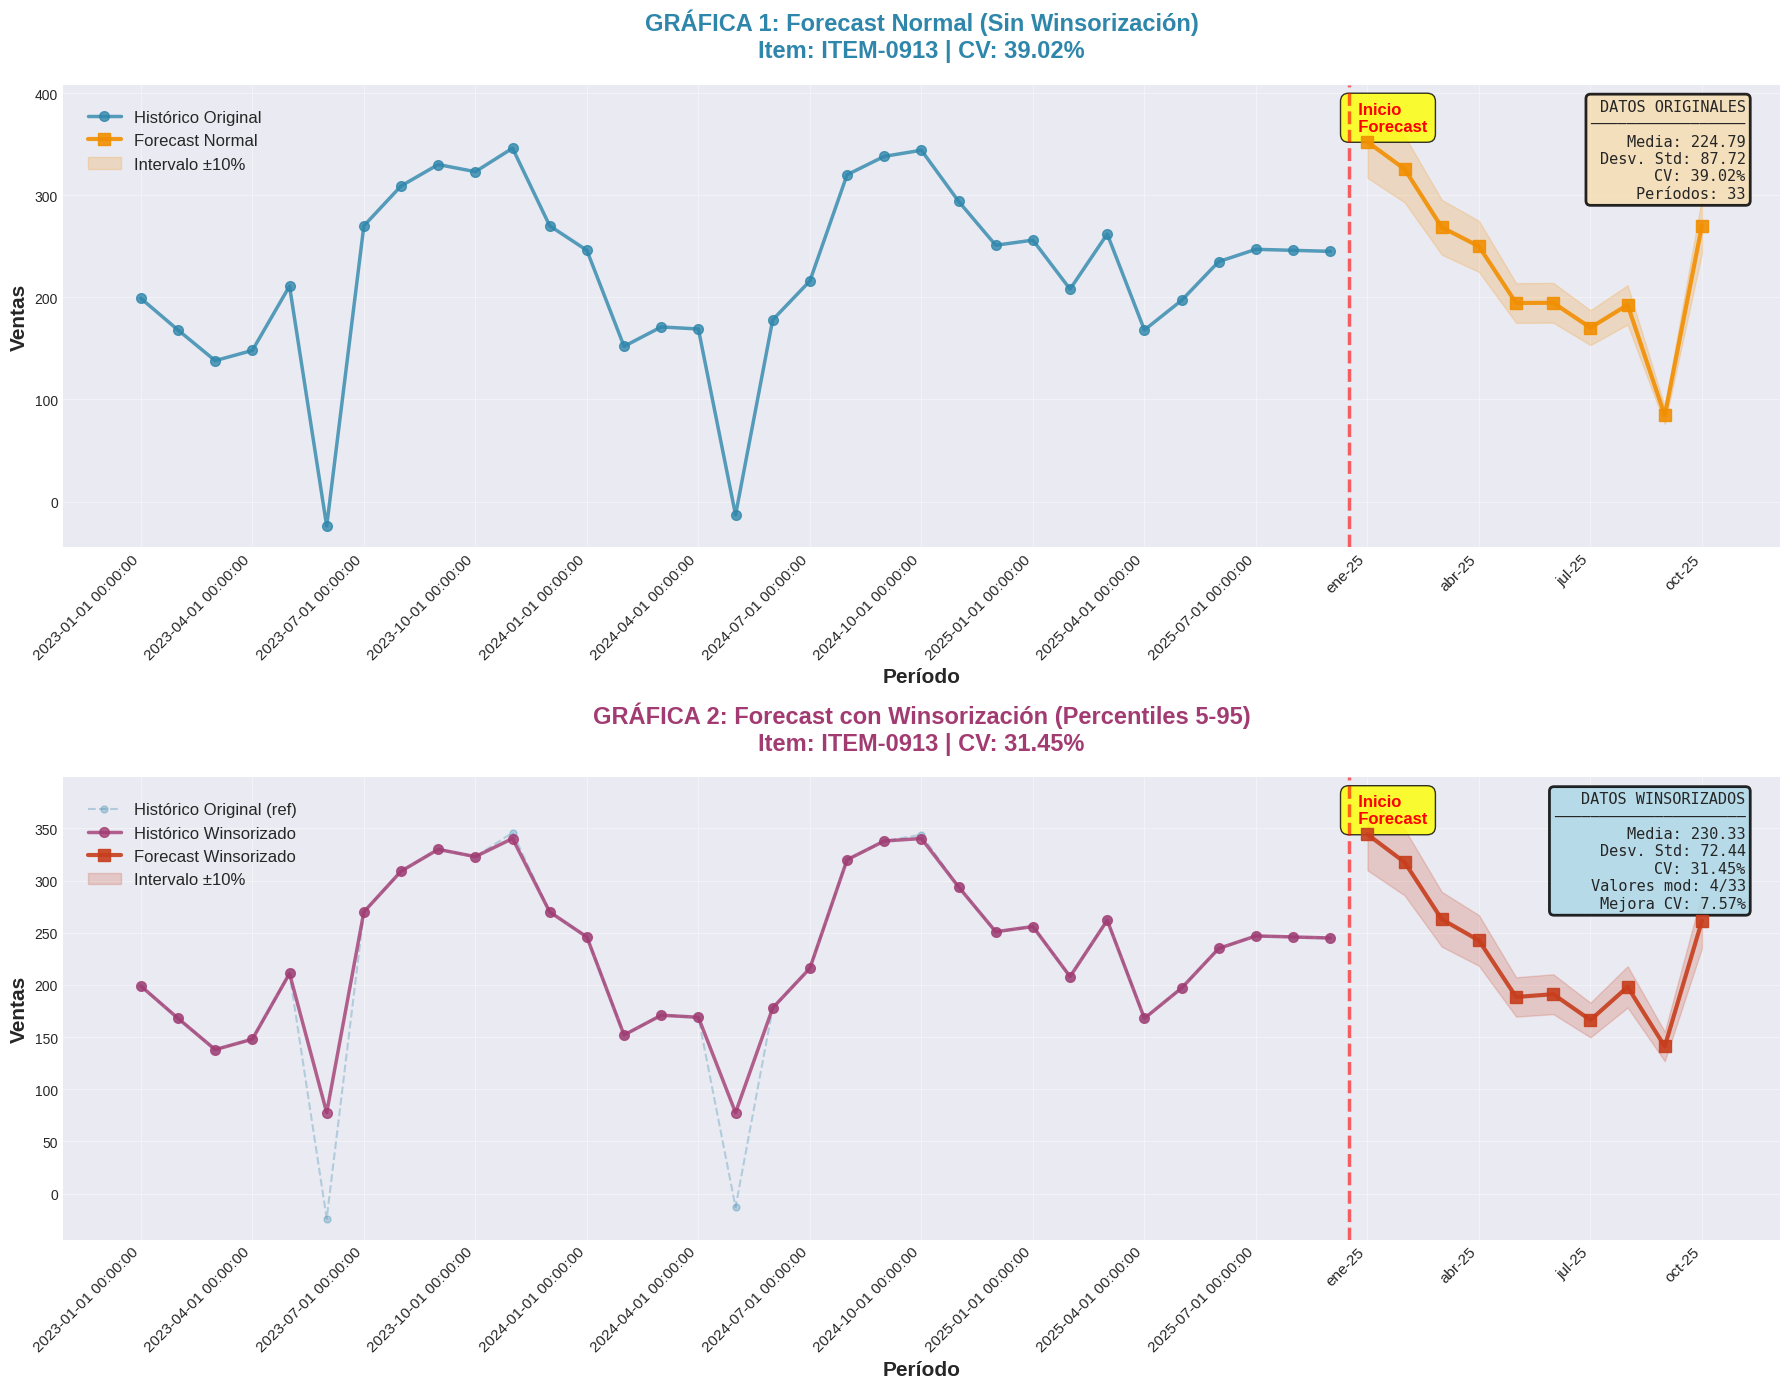


COMPARACIÓN DE COEFICIENTES DE VARIACIÓN

           Método      Media  Desv. Estándar  Coef. Variación (%)
Sin Winsorización 224.787879       87.717500            39.022344
Con Winsorización 230.333333       72.440315            31.450209

Reducción en coeficiente de variación: 7.57% (19.4% de mejora)

COMPARACIÓN DE FORECASTS

Período  Forecast Normal  Forecast Winsorizado  Diferencia  Dif. %
 ene-25            352.0                 344.0         8.0     2.2
 feb-25            326.0                 318.0         8.0     2.4
 mar-25            269.0                 263.0         6.0     2.1
 abr-25            250.0                 243.0         7.0     2.9
 may-25            194.0                 189.0         6.0     3.1
 jun-25            195.0                 191.0         4.0     1.8
 jul-25            170.0                 166.0         4.0     2.3
 ago-25            193.0                 198.0        -6.0    -2.9
 sep-25             84.0                 141.0       -57.0   -67.

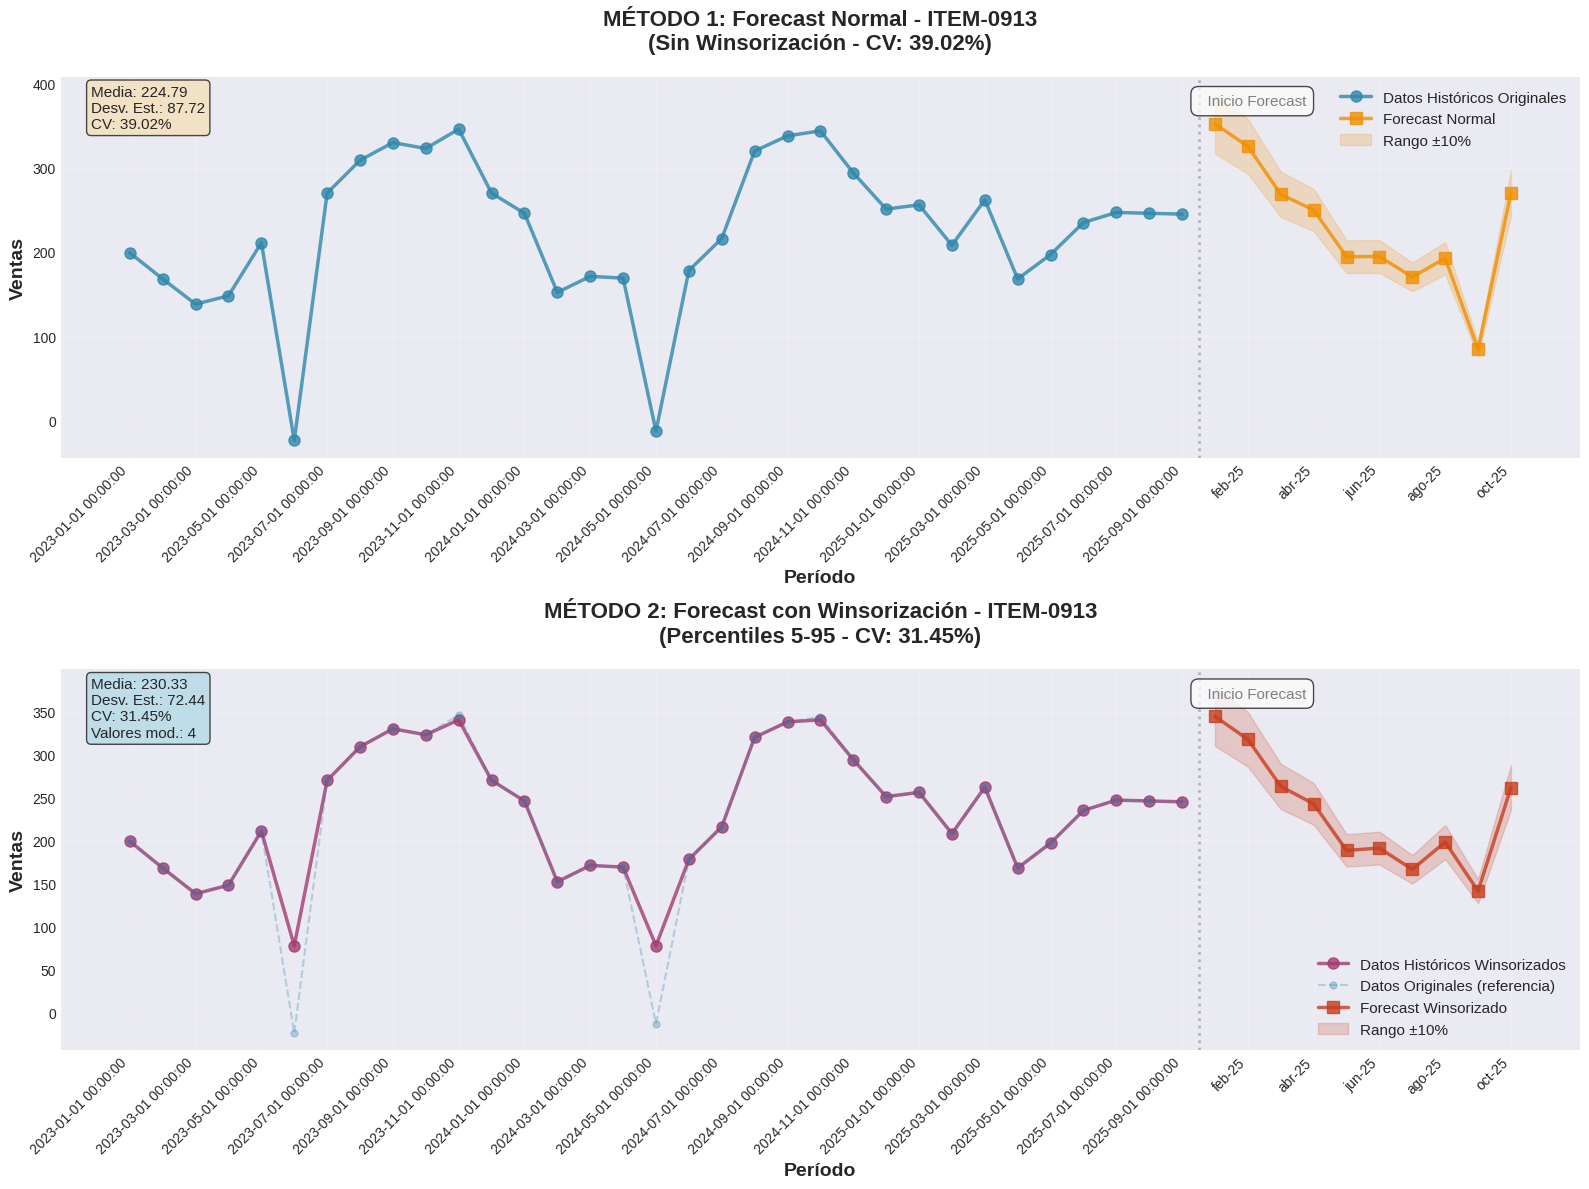

✓ Gráficas generadas

✓ Archivo generado: forecast_comparacion_ITEM-0913.xlsx

RESUMEN EJECUTIVO

Item analizado: ITEM-0913
Columna: AID

Resultados:
  • Coeficiente de variación se redujo de 39.02% a 31.45%
  • Mejora: 7.57 puntos porcentuales (19.4%)
  • La winsorización modificó 4 de 33 valores (12.1%)
  • Promedio de forecast normal: 230.29
  • Promedio de forecast winsorizado: 231.44


In [14]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
from scipy import stats as scipy_stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Suprimir mensajes de Prophet
import logging
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

# Intentar importar Prophet
try:
    from prophet import Prophet
    PROPHET_DISPONIBLE = True
except:
    try:
        from fbprophet import Prophet
        PROPHET_DISPONIBLE = True
    except:
        print("ERROR: Prophet no está instalado.")
        print("Instala con: pip install prophet")
        exit()

# URL del archivo
url = 'https://github.com/santiagonajera/PlanificacionProduccion/raw/refs/heads/main/ventas_mensuales_3500_items_2023_2025.xlsx'

# CONFIGURACIÓN
COLUMNA_ITEM = 'AID'  # Item 913

print("="*100)
print("COMPARACIÓN: FORECAST NORMAL vs FORECAST CON WINSORIZACIÓN")
print("="*100)

# Convertir letra de columna a índice
def columna_a_indice(letra):
    letra = letra.upper()
    indice = 0
    for i, char in enumerate(reversed(letra)):
        indice += (ord(char) - ord('A') + 1) * (26 ** i)
    return indice - 1

item_col = columna_a_indice(COLUMNA_ITEM)

print(f"\nLeyendo archivo...")
print(f"Analizando item en columna: {COLUMNA_ITEM} (índice {item_col})\n")

df = pd.read_excel(url, sheet_name='ITEMS', header=None)

# Obtener nombre del item
item_name = df.iloc[0, item_col]
print(f"Item: {item_name}\n")

# Función para convertir período a fecha
def periodo_a_fecha(periodo_str):
    periodo_str = str(periodo_str).strip().lower()
    meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
             'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

    if '-' in periodo_str:
        partes = periodo_str.split('-')
        mes_str = partes[0].strip()
        anio_str = partes[1].strip()

        for idx, mes_nombre in enumerate(meses):
            if mes_str.startswith(mes_nombre[:3]):
                if len(anio_str) == 2:
                    anio = int('20' + anio_str)
                else:
                    anio = int(anio_str)

                mes_num = idx + 1
                return datetime(anio, mes_num, 1)

    try:
        return pd.to_datetime(periodo_str)
    except:
        return None

# Extraer fechas (columna A)
dates = []
dates_dt = []

for i in range(1, df.shape[0]):
    period = df.iloc[i, 0]
    if pd.notna(period):
        period_str = str(period).strip()
        fecha = periodo_a_fecha(period_str)
        if fecha:
            dates.append(period_str)
            dates_dt.append(fecha)
    else:
        break

# Extraer datos del item
data = []
for i in range(1, len(dates) + 1):
    value = df.iloc[i, item_col]
    if pd.notna(value):
        try:
            data.append(float(value))
        except:
            data.append(0)
    else:
        data.append(0)

print(f"Datos históricos: {len(data)} períodos")
print(f"Rango: {min(data):.0f} - {max(data):.0f}")
print(f"Media: {np.mean(data):.2f}")
print(f"Desviación estándar: {np.std(data):.2f}")

# Generar períodos de forecast
ultimo_periodo = dates[-1]
meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
         'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

try:
    ultimo_mes_str, ultimo_anio_str = ultimo_periodo.split('-')
    ultimo_mes_str = ultimo_mes_str.lower()
    ultimo_anio = int('20' + ultimo_anio_str) if len(ultimo_anio_str) == 2 else int(ultimo_anio_str)
    ultimo_mes_num = meses.index(ultimo_mes_str) + 1 if ultimo_mes_str in meses else 12
except:
    ultimo_anio = 2024
    ultimo_mes_num = 12

fecha_inicio = datetime(ultimo_anio, ultimo_mes_num, 1)
periodos_forecast = []

for i in range(1, 11):
    nueva_fecha = fecha_inicio + relativedelta(months=i)
    mes_nombre = meses[nueva_fecha.month - 1]
    anio_corto = str(nueva_fecha.year)[2:]
    periodo = f"{mes_nombre}-{anio_corto}"
    periodos_forecast.append(periodo)

# ==============================================================================
# MÉTODO 1: FORECAST NORMAL (SIN WINSORIZACIÓN)
# ==============================================================================
print("\n" + "="*100)
print("MÉTODO 1: FORECAST NORMAL (SIN WINSORIZACIÓN)")
print("="*100)

# Calcular coeficiente de variación
mean_normal = np.mean(data)
std_normal = np.std(data, ddof=1)  # Usar ddof=1 para muestra
cv_normal = (std_normal / mean_normal) * 100

print(f"\nEstadísticas de datos originales:")
print(f"  Media:                    {mean_normal:.2f}")
print(f"  Desviación estándar:      {std_normal:.2f}")
print(f"  Coeficiente de variación: {cv_normal:.2f}%")

# Hacer forecast con Prophet
print(f"\nEjecutando Prophet con datos originales...")

df_prophet_normal = pd.DataFrame({
    'ds': dates_dt,
    'y': data
})

model_normal = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative'
)

model_normal.fit(df_prophet_normal)

last_date = dates_dt[-1]
future_dates = []

for i in range(1, 11):
    next_date = last_date + relativedelta(months=i)
    future_dates.append(next_date)

future_df = pd.DataFrame({'ds': future_dates})
forecast_normal = model_normal.predict(future_df)
forecast_values_normal = [max(0, val) for val in forecast_normal['yhat'].values]

print(f"✓ Forecast completado")

# ==============================================================================
# MÉTODO 2: FORECAST CON WINSORIZACIÓN
# ==============================================================================
print("\n" + "="*100)
print("MÉTODO 2: FORECAST CON WINSORIZACIÓN")
print("="*100)

# Aplicar winsorización (limitar valores extremos a los percentiles 5 y 95)
percentil_inferior = 5
percentil_superior = 95

limite_inferior = np.percentile(data, percentil_inferior)
limite_superior = np.percentile(data, percentil_superior)

print(f"\nWinsorización aplicada:")
print(f"  Percentil inferior ({percentil_inferior}%): {limite_inferior:.2f}")
print(f"  Percentil superior ({percentil_superior}%): {limite_superior:.2f}")

# Aplicar winsorización
data_winsorized = []
valores_modificados = 0

for valor in data:
    if valor < limite_inferior:
        data_winsorized.append(limite_inferior)
        valores_modificados += 1
    elif valor > limite_superior:
        data_winsorized.append(limite_superior)
        valores_modificados += 1
    else:
        data_winsorized.append(valor)

print(f"  Valores modificados: {valores_modificados} de {len(data)} ({valores_modificados/len(data)*100:.1f}%)")

# Calcular coeficiente de variación de datos winsorizados
mean_winsorized = np.mean(data_winsorized)
std_winsorized = np.std(data_winsorized, ddof=1)
cv_winsorized = (std_winsorized / mean_winsorized) * 100

print(f"\nEstadísticas de datos winsorizados:")
print(f"  Media:                    {mean_winsorized:.2f}")
print(f"  Desviación estándar:      {std_winsorized:.2f}")
print(f"  Coeficiente de variación: {cv_winsorized:.2f}%")

# Hacer forecast con datos winsorizados
print(f"\nEjecutando Prophet con datos winsorizados...")

df_prophet_winsorized = pd.DataFrame({
    'ds': dates_dt,
    'y': data_winsorized
})

model_winsorized = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative'
)

model_winsorized.fit(df_prophet_winsorized)

forecast_winsorized = model_winsorized.predict(future_df)
forecast_values_winsorized = [max(0, val) for val in forecast_winsorized['yhat'].values]

print(f"✓ Forecast completado")

# ==============================================================================
# GENERAR GRÁFICAS
# ==============================================================================
print("\n" + "="*100)
print("GENERANDO GRÁFICAS")
print("="*100)

# Configuración de estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Crear figura con 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 14))

# Preparar datos para el eje X
x_historical = np.arange(len(data))
x_forecast = np.arange(len(data), len(data) + len(forecast_values_normal))
todos_periodos = dates + periodos_forecast

# ==============================================================================
# GRÁFICA 1: FORECAST NORMAL (SIN WINSORIZACIÓN)
# ==============================================================================

# Datos históricos originales
ax1.plot(x_historical, data, 'o-', linewidth=2.5, markersize=7,
         label='Histórico Original', color='#2E86AB', alpha=0.8, zorder=3)

# Forecast normal
ax1.plot(x_forecast, forecast_values_normal, 's-', linewidth=3, markersize=9,
         label='Forecast Normal', color='#F18F01', alpha=0.9, zorder=4)

# Área sombreada para el forecast
ax1.fill_between(x_forecast,
                 np.array(forecast_values_normal) * 0.9,
                 np.array(forecast_values_normal) * 1.1,
                 alpha=0.2, color='#F18F01', label='Intervalo ±10%', zorder=2)

# Línea vertical separando histórico de forecast
ax1.axvline(x=len(data)-0.5, color='red', linestyle='--', linewidth=2.5, alpha=0.6, zorder=5)
ax1.text(len(data)-0.5, ax1.get_ylim()[1]*0.96, '  Inicio\n  Forecast',
         rotation=0, verticalalignment='top', fontsize=12, color='red', fontweight='bold',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8))

# Configuración de la gráfica 1
ax1.set_xlabel('Período', fontsize=15, fontweight='bold')
ax1.set_ylabel('Ventas', fontsize=15, fontweight='bold')
ax1.set_title(f'GRÁFICA 1: Forecast Normal (Sin Winsorización)\nItem: {item_name} | CV: {cv_normal:.2f}%',
              fontsize=17, fontweight='bold', pad=20, color='#2E86AB')

# Configurar etiquetas del eje x
x_ticks = list(range(0, len(todos_periodos), max(1, len(todos_periodos)//12)))
ax1.set_xticks(x_ticks)
ax1.set_xticklabels([todos_periodos[i] for i in x_ticks], rotation=45, ha='right', fontsize=11)

# Grid y leyenda
ax1.grid(True, alpha=0.4, linestyle='-', linewidth=0.8)
ax1.legend(loc='upper left', fontsize=12, framealpha=0.95, shadow=True,
           fancybox=True, borderpad=1)

# Información adicional
textstr1 = (f'DATOS ORIGINALES\n'
           f'─────────────────\n'
           f'Media: {mean_normal:.2f}\n'
           f'Desv. Std: {std_normal:.2f}\n'
           f'CV: {cv_normal:.2f}%\n'
           f'Períodos: {len(data)}')
props1 = dict(boxstyle='round', facecolor='wheat', alpha=0.85, edgecolor='black', linewidth=2)
ax1.text(0.98, 0.97, textstr1, transform=ax1.transAxes, fontsize=11,
         verticalalignment='top', horizontalalignment='right', bbox=props1, family='monospace')

# ==============================================================================
# GRÁFICA 2: FORECAST CON WINSORIZACIÓN
# ==============================================================================

# Datos originales como referencia (más tenue)
ax2.plot(x_historical, data, 'o--', linewidth=1.5, markersize=5,
         label='Histórico Original (ref)', color='#2E86AB', alpha=0.3, zorder=1)

# Datos históricos winsorizados
ax2.plot(x_historical, data_winsorized, 'o-', linewidth=2.5, markersize=7,
         label='Histórico Winsorizado', color='#A23B72', alpha=0.8, zorder=3)

# Forecast con winsorización
ax2.plot(x_forecast, forecast_values_winsorized, 's-', linewidth=3, markersize=9,
         label='Forecast Winsorizado', color='#C73E1D', alpha=0.9, zorder=4)

# Área sombreada para el forecast
ax2.fill_between(x_forecast,
                 np.array(forecast_values_winsorized) * 0.9,
                 np.array(forecast_values_winsorized) * 1.1,
                 alpha=0.2, color='#C73E1D', label='Intervalo ±10%', zorder=2)

# Línea vertical separando histórico de forecast
ax2.axvline(x=len(data)-0.5, color='red', linestyle='--', linewidth=2.5, alpha=0.6, zorder=5)
ax2.text(len(data)-0.5, ax2.get_ylim()[1]*0.96, '  Inicio\n  Forecast',
         rotation=0, verticalalignment='top', fontsize=12, color='red', fontweight='bold',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8))

# Configuración de la gráfica 2
ax2.set_xlabel('Período', fontsize=15, fontweight='bold')
ax2.set_ylabel('Ventas', fontsize=15, fontweight='bold')
ax2.set_title(f'GRÁFICA 2: Forecast con Winsorización (Percentiles {percentil_inferior}-{percentil_superior})\nItem: {item_name} | CV: {cv_winsorized:.2f}%',
              fontsize=17, fontweight='bold', pad=20, color='#A23B72')

# Configurar etiquetas del eje x
ax2.set_xticks(x_ticks)
ax2.set_xticklabels([todos_periodos[i] for i in x_ticks], rotation=45, ha='right', fontsize=11)

# Grid y leyenda
ax2.grid(True, alpha=0.4, linestyle='-', linewidth=0.8)
ax2.legend(loc='upper left', fontsize=12, framealpha=0.95, shadow=True,
           fancybox=True, borderpad=1)

# Información adicional
textstr2 = (f'DATOS WINSORIZADOS\n'
           f'─────────────────────\n'
           f'Media: {mean_winsorized:.2f}\n'
           f'Desv. Std: {std_winsorized:.2f}\n'
           f'CV: {cv_winsorized:.2f}%\n'
           f'Valores mod: {valores_modificados}/{len(data)}\n'
           f'Mejora CV: {cv_normal - cv_winsorized:.2f}%')
props2 = dict(boxstyle='round', facecolor='lightblue', alpha=0.85, edgecolor='black', linewidth=2)
ax2.text(0.98, 0.97, textstr2, transform=ax2.transAxes, fontsize=11,
         verticalalignment='top', horizontalalignment='right', bbox=props2, family='monospace')

plt.tight_layout()

# Guardar gráfica
grafico_file = f'forecast_comparacion_{item_name}.png'
plt.savefig(grafico_file, dpi=300, bbox_inches='tight')
print(f"✓ Gráfica guardada: {grafico_file}")

plt.show()

# ==============================================================================
# COMPARACIÓN DE RESULTADOS
# ==============================================================================
print("\n" + "="*100)
print("COMPARACIÓN DE COEFICIENTES DE VARIACIÓN")
print("="*100)

df_cv_comparison = pd.DataFrame({
    'Método': ['Sin Winsorización', 'Con Winsorización'],
    'Media': [mean_normal, mean_winsorized],
    'Desv. Estándar': [std_normal, std_winsorized],
    'Coef. Variación (%)': [cv_normal, cv_winsorized]
})

print("\n" + df_cv_comparison.to_string(index=False))

# Mejora en CV
mejora_cv = cv_normal - cv_winsorized
mejora_cv_pct = (mejora_cv / cv_normal) * 100

print(f"\n{'='*100}")
print(f"Reducción en coeficiente de variación: {mejora_cv:.2f}% ({mejora_cv_pct:.1f}% de mejora)")
print(f"{'='*100}")

# ==============================================================================
# COMPARACIÓN DE FORECASTS
# ==============================================================================
print("\n" + "="*100)
print("COMPARACIÓN DE FORECASTS")
print("="*100)

df_forecast_comparison = pd.DataFrame({
    'Período': periodos_forecast,
    'Forecast Normal': [round(v, 0) for v in forecast_values_normal],
    'Forecast Winsorizado': [round(v, 0) for v in forecast_values_winsorized],
    'Diferencia': [round(forecast_values_normal[i] - forecast_values_winsorized[i], 0)
                   for i in range(len(periodos_forecast))],
    'Dif. %': [round((forecast_values_normal[i] - forecast_values_winsorized[i]) /
                     forecast_values_normal[i] * 100, 1) if forecast_values_normal[i] != 0 else 0
               for i in range(len(periodos_forecast))]
})

print("\n" + df_forecast_comparison.to_string(index=False))

# Estadísticas de los forecasts
promedio_forecast_normal = np.mean(forecast_values_normal)
promedio_forecast_winsorized = np.mean(forecast_values_winsorized)

print(f"\n{'='*100}")
print(f"PROMEDIOS DE FORECAST")
print(f"{'='*100}")
print(f"Forecast Normal:      {promedio_forecast_normal:>10.2f}")
print(f"Forecast Winsorizado: {promedio_forecast_winsorized:>10.2f}")
print(f"Diferencia:           {promedio_forecast_normal - promedio_forecast_winsorized:>10.2f}")
print(f"{'='*100}")

# ==============================================================================
# GENERAR GRÁFICAS
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("\n" + "="*100)
print("GENERANDO GRÁFICAS")
print("="*100)

# Crear figura con 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Preparar datos para el eje X
x_historical = np.arange(len(data))
x_forecast = np.arange(len(data), len(data) + len(forecast_values_normal))
todos_periodos = dates + periodos_forecast

# ==============================================================================
# GRÁFICA 1: FORECAST NORMAL (SIN WINSORIZACIÓN)
# ==============================================================================

# Datos históricos originales
ax1.plot(x_historical, data, 'o-', linewidth=2.5, markersize=8,
         label='Datos Históricos Originales', color='#2E86AB', alpha=0.8)

# Forecast normal
ax1.plot(x_forecast, forecast_values_normal, 's-', linewidth=2.5, markersize=8,
         label='Forecast Normal', color='#F18F01', alpha=0.8)

# Área sombreada para el forecast
ax1.fill_between(x_forecast,
                 np.array(forecast_values_normal) * 0.9,
                 np.array(forecast_values_normal) * 1.1,
                 alpha=0.2, color='#F18F01', label='Rango ±10%')

# Línea vertical separando histórico de forecast
ax1.axvline(x=len(data)-0.5, color='gray', linestyle=':', linewidth=2, alpha=0.5)
ax1.text(len(data)-0.5, ax1.get_ylim()[1]*0.95, '  Inicio Forecast',
         rotation=0, verticalalignment='top', fontsize=11, color='gray',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7))

# Configuración de la gráfica 1
ax1.set_xlabel('Período', fontsize=14, fontweight='bold')
ax1.set_ylabel('Ventas', fontsize=14, fontweight='bold')
ax1.set_title(f'MÉTODO 1: Forecast Normal - {item_name}\n(Sin Winsorización - CV: {cv_normal:.2f}%)',
              fontsize=16, fontweight='bold', pad=20)

# Configurar etiquetas del eje x
x_ticks = list(range(0, len(todos_periodos), max(1, len(todos_periodos)//15)))
ax1.set_xticks(x_ticks)
ax1.set_xticklabels([todos_periodos[i] for i in x_ticks], rotation=45, ha='right')

# Grid y leyenda
ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax1.legend(loc='best', fontsize=11, framealpha=0.9, shadow=True)

# Información adicional
textstr1 = f'Media: {mean_normal:.2f}\nDesv. Est.: {std_normal:.2f}\nCV: {cv_normal:.2f}%'
props1 = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
ax1.text(0.02, 0.98, textstr1, transform=ax1.transAxes, fontsize=11,
         verticalalignment='top', bbox=props1)

# ==============================================================================
# GRÁFICA 2: FORECAST CON WINSORIZACIÓN
# ==============================================================================

# Datos históricos winsorizados
ax2.plot(x_historical, data_winsorized, 'o-', linewidth=2.5, markersize=8,
         label='Datos Históricos Winsorizados', color='#A23B72', alpha=0.8)

# Mostrar datos originales como referencia (más tenue)
ax2.plot(x_historical, data, 'o--', linewidth=1.5, markersize=5,
         label='Datos Originales (referencia)', color='#2E86AB', alpha=0.3)

# Forecast con winsorización
ax2.plot(x_forecast, forecast_values_winsorized, 's-', linewidth=2.5, markersize=8,
         label='Forecast Winsorizado', color='#C73E1D', alpha=0.8)

# Área sombreada para el forecast
ax2.fill_between(x_forecast,
                 np.array(forecast_values_winsorized) * 0.9,
                 np.array(forecast_values_winsorized) * 1.1,
                 alpha=0.2, color='#C73E1D', label='Rango ±10%')

# Línea vertical separando histórico de forecast
ax2.axvline(x=len(data)-0.5, color='gray', linestyle=':', linewidth=2, alpha=0.5)
ax2.text(len(data)-0.5, ax2.get_ylim()[1]*0.95, '  Inicio Forecast',
         rotation=0, verticalalignment='top', fontsize=11, color='gray',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7))

# Configuración de la gráfica 2
ax2.set_xlabel('Período', fontsize=14, fontweight='bold')
ax2.set_ylabel('Ventas', fontsize=14, fontweight='bold')
ax2.set_title(f'MÉTODO 2: Forecast con Winsorización - {item_name}\n(Percentiles {percentil_inferior}-{percentil_superior} - CV: {cv_winsorized:.2f}%)',
              fontsize=16, fontweight='bold', pad=20)

# Configurar etiquetas del eje x
ax2.set_xticks(x_ticks)
ax2.set_xticklabels([todos_periodos[i] for i in x_ticks], rotation=45, ha='right')

# Grid y leyenda
ax2.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax2.legend(loc='best', fontsize=11, framealpha=0.9, shadow=True)

# Información adicional
textstr2 = f'Media: {mean_winsorized:.2f}\nDesv. Est.: {std_winsorized:.2f}\nCV: {cv_winsorized:.2f}%\nValores mod.: {valores_modificados}'
props2 = dict(boxstyle='round', facecolor='lightblue', alpha=0.7)
ax2.text(0.02, 0.98, textstr2, transform=ax2.transAxes, fontsize=11,
         verticalalignment='top', bbox=props2)

plt.tight_layout()
plt.savefig(f'forecast_comparacion_{item_name}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Gráficas generadas")

# ==============================================================================
# GUARDAR RESULTADOS
# ==============================================================================
output_file = f'forecast_comparacion_{item_name}.xlsx'

with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    # Hoja 1: Comparación de CV
    df_cv_comparison.to_excel(writer, sheet_name='Coef_Variacion', index=False)

    # Hoja 2: Comparación de Forecasts
    df_forecast_comparison.to_excel(writer, sheet_name='Forecasts', index=False)

    # Hoja 3: Datos históricos
    df_historico = pd.DataFrame({
        'Período': dates,
        'Datos Originales': data,
        'Datos Winsorizados': data_winsorized,
        'Diferencia': [data[i] - data_winsorized[i] for i in range(len(data))]
    })
    df_historico.to_excel(writer, sheet_name='Datos_Historicos', index=False)

print(f"\n✓ Archivo generado: {output_file}")

# ==============================================================================
# RESUMEN EJECUTIVO
# ==============================================================================
print("\n" + "="*100)
print("RESUMEN EJECUTIVO")
print("="*100)
print(f"\nItem analizado: {item_name}")
print(f"Columna: {COLUMNA_ITEM}")
print(f"\nResultados:")
print(f"  • Coeficiente de variación se redujo de {cv_normal:.2f}% a {cv_winsorized:.2f}%")
print(f"  • Mejora: {mejora_cv:.2f} puntos porcentuales ({mejora_cv_pct:.1f}%)")
print(f"  • La winsorización modificó {valores_modificados} de {len(data)} valores ({valores_modificados/len(data)*100:.1f}%)")
print(f"  • Promedio de forecast normal: {promedio_forecast_normal:.2f}")
print(f"  • Promedio de forecast winsorizado: {promedio_forecast_winsorized:.2f}")
print("="*100)